In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

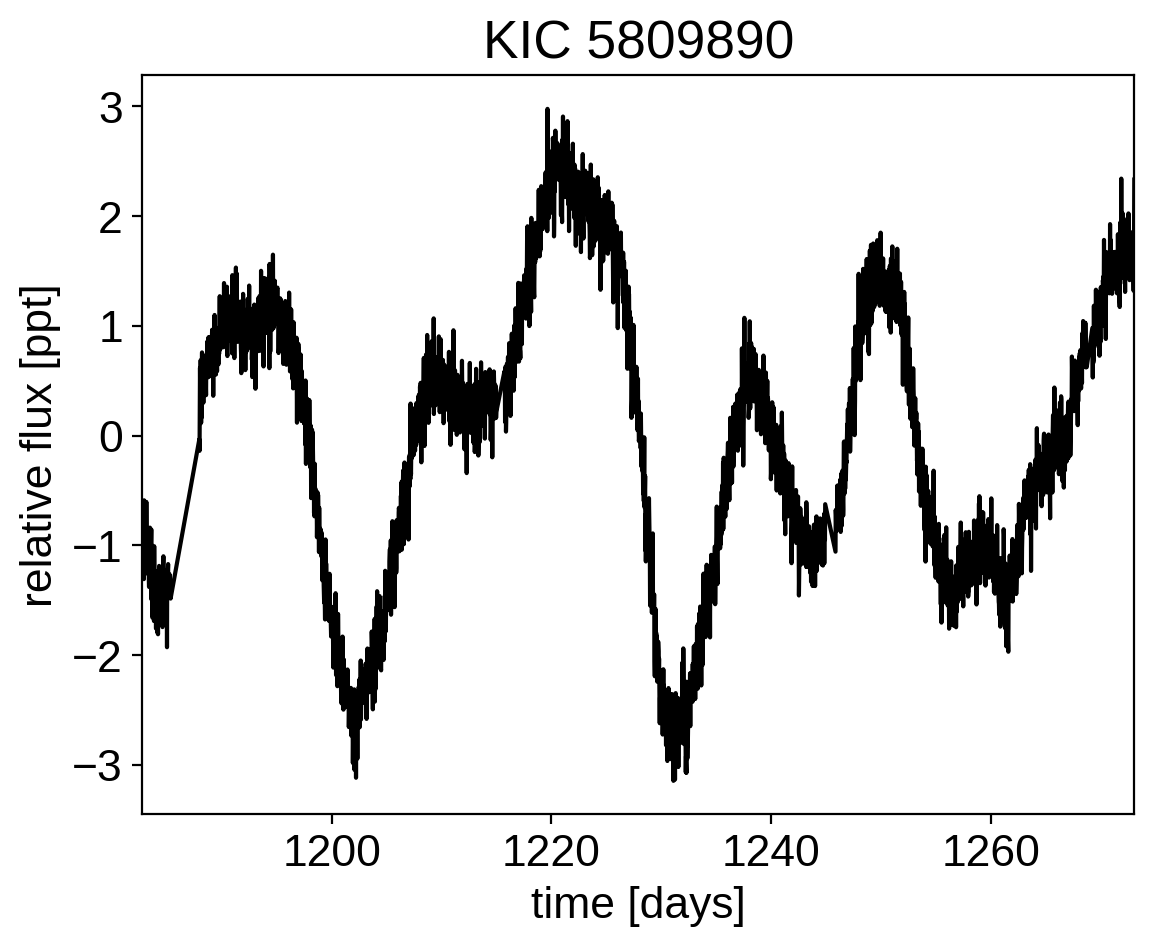

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcf = lk.search_lightcurvefile("KIC 5809890", quarter=13).download(
    quality_bitmask="hardest"
)
lc = lcf.PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

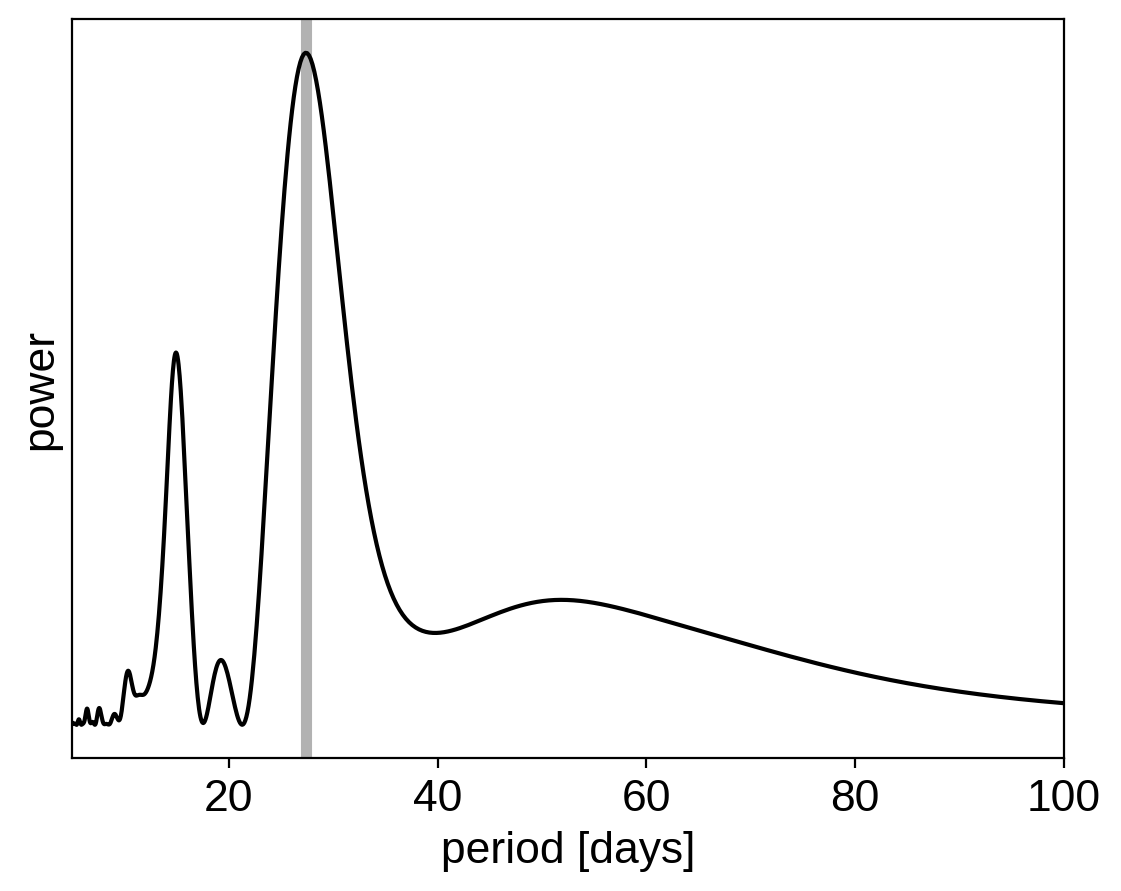

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.672569e+02]

1it [00:00, 38.89it/s, logp=2.672569e+02]

2it [00:00, 61.57it/s, logp=2.672569e+02]

3it [00:00, 76.41it/s, logp=5.136323e+02]

4it [00:00, 87.62it/s, logp=1.156425e+02]

5it [00:00, 85.34it/s, logp=5.979256e+02]

6it [00:00, 81.97it/s, logp=5.714984e+02]

7it [00:00, 85.19it/s, logp=6.326147e+02]

8it [00:00, 89.53it/s, logp=6.068474e+02]

9it [00:00, 92.93it/s, logp=6.417452e+02]

10it [00:00, 91.20it/s, logp=6.581322e+02]

11it [00:00, 99.56it/s, logp=6.581322e+02]

11it [00:00, 99.56it/s, logp=6.674794e+02]

12it [00:00, 99.56it/s, logp=6.613014e+02]

13it [00:00, 99.56it/s, logp=6.757355e+02]

14it [00:00, 99.56it/s, logp=6.789136e+02]

15it [00:00, 99.56it/s, logp=6.838594e+02]

16it [00:00, 99.56it/s, logp=6.861378e+02]

17it [00:00, 99.56it/s, logp=6.865861e+02]

18it [00:00, 99.56it/s, logp=6.871456e+02]

19it [00:00, 99.56it/s, logp=6.876705e+02]

20it [00:00, 99.56it/s, logp=6.876475e+02]

21it [00:00, 99.56it/s, logp=6.878897e+02]

22it [00:00, 99.56it/s, logp=6.881082e+02]

23it [00:00, 99.56it/s, logp=6.885047e+02]

24it [00:00, 99.56it/s, logp=6.891367e+02]

25it [00:00, 107.92it/s, logp=6.891367e+02]

25it [00:00, 107.92it/s, logp=6.901976e+02]

26it [00:00, 107.92it/s, logp=6.909579e+02]

27it [00:00, 107.92it/s, logp=6.916029e+02]

28it [00:00, 107.92it/s, logp=6.920778e+02]

29it [00:00, 107.92it/s, logp=6.924232e+02]

30it [00:00, 107.92it/s, logp=6.931739e+02]

31it [00:00, 107.92it/s, logp=6.904351e+02]

32it [00:00, 107.92it/s, logp=6.938593e+02]

33it [00:00, 107.92it/s, logp=6.905908e+02]

34it [00:00, 107.92it/s, logp=6.946127e+02]

35it [00:00, 107.92it/s, logp=6.956242e+02]

36it [00:00, 107.92it/s, logp=6.968903e+02]

37it [00:00, 107.92it/s, logp=6.985163e+02]

38it [00:00, 107.92it/s, logp=6.996495e+02]

39it [00:00, 107.92it/s, logp=6.999618e+02]

40it [00:00, 107.92it/s, logp=7.002774e+02]

41it [00:00, 107.92it/s, logp=7.005226e+02]

42it [00:00, 107.92it/s, logp=7.006902e+02]

43it [00:00, 107.92it/s, logp=7.009344e+02]

44it [00:00, 123.59it/s, logp=7.009344e+02]

44it [00:00, 123.59it/s, logp=7.010994e+02]

45it [00:00, 123.59it/s, logp=7.012373e+02]

46it [00:00, 123.59it/s, logp=7.013984e+02]

47it [00:00, 123.59it/s, logp=7.014793e+02]

48it [00:00, 123.59it/s, logp=7.015101e+02]

49it [00:00, 123.59it/s, logp=7.015675e+02]

50it [00:00, 123.59it/s, logp=7.016709e+02]

51it [00:00, 123.59it/s, logp=7.018428e+02]

52it [00:00, 123.59it/s, logp=7.020862e+02]

53it [00:00, 123.59it/s, logp=7.023418e+02]

54it [00:00, 123.59it/s, logp=7.026745e+02]

55it [00:00, 123.59it/s, logp=7.025408e+02]

56it [00:00, 123.59it/s, logp=7.010859e+02]

57it [00:00, 123.59it/s, logp=7.026189e+02]

58it [00:00, 123.59it/s, logp=7.025624e+02]

59it [00:00, 123.59it/s, logp=7.026910e+02]

60it [00:00, 123.59it/s, logp=7.025332e+02]

61it [00:00, 123.59it/s, logp=7.027220e+02]

62it [00:00, 123.59it/s, logp=7.027819e+02]

63it [00:00, 123.59it/s, logp=7.029662e+02]

64it [00:00, 123.59it/s, logp=7.029378e+02]

65it [00:00, 140.13it/s, logp=7.029378e+02]

65it [00:00, 140.13it/s, logp=7.031062e+02]

66it [00:00, 140.13it/s, logp=7.031349e+02]

67it [00:00, 140.13it/s, logp=7.031669e+02]

68it [00:00, 140.13it/s, logp=7.031683e+02]

69it [00:00, 140.13it/s, logp=7.031700e+02]

70it [00:00, 140.13it/s, logp=7.031704e+02]

71it [00:00, 140.13it/s, logp=7.031712e+02]

72it [00:00, 140.13it/s, logp=7.031720e+02]

73it [00:00, 140.13it/s, logp=7.031723e+02]

74it [00:00, 140.13it/s, logp=7.031724e+02]

75it [00:00, 140.13it/s, logp=7.031724e+02]

76it [00:00, 140.13it/s, logp=7.031724e+02]

77it [00:00, 140.13it/s, logp=7.031724e+02]

78it [00:00, 140.13it/s, logp=7.031724e+02]

79it [00:00, 140.13it/s, logp=7.031724e+02]

80it [00:00, 140.13it/s, logp=7.031724e+02]

81it [00:10,  7.60it/s, logp=7.031724e+02] 


message: Optimization terminated successfully.
logp: 267.25686032199354 -> 703.1723809089816


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

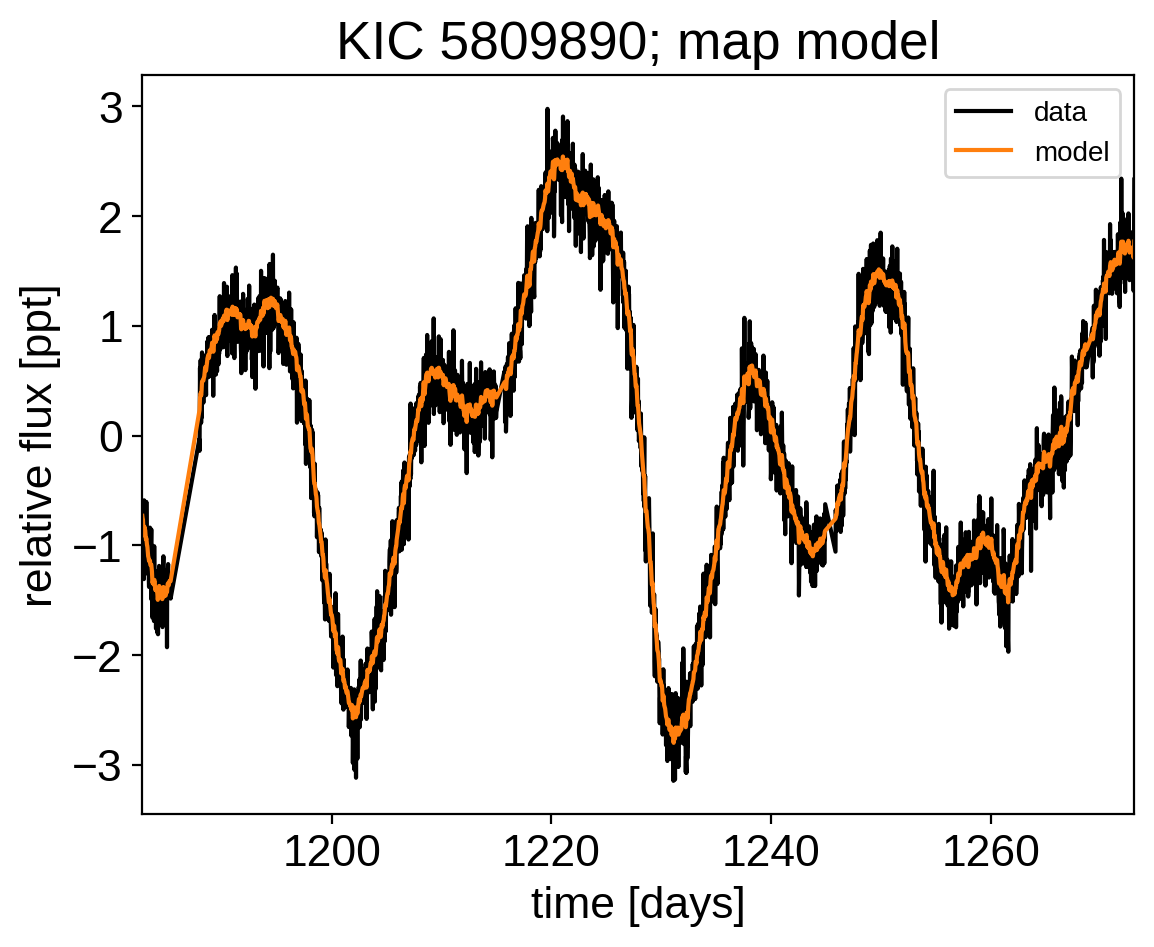

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(5809890)
with model:
    trace = xo.sample(tune=2500, draws=2000, start=map_soln, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 9/18000 [00:00<09:51, 30.40draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 10/18000 [00:01<1:11:39,  4.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 13/18000 [00:01<58:52,  5.09draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 14/18000 [00:01<58:03,  5.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 15/18000 [00:02<1:26:40,  3.46draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 17/18000 [00:02<1:13:40,  4.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 18/18000 [00:02<1:06:00,  4.54draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 19/18000 [00:02<1:33:03,  3.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/18000 [00:03<1:19:30,  3.77draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 22/18000 [00:03<1:07:03,  4.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 24/18000 [00:03<1:08:55,  4.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/18000 [00:04<59:07,  5.07draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 26/18000 [00:04<1:04:55,  4.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 27/18000 [00:04<57:32,  5.21draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 28/18000 [00:04<1:20:43,  3.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/18000 [00:05<1:07:31,  4.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 30/18000 [00:05<1:12:57,  4.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 31/18000 [00:05<1:00:42,  4.93draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 32/18000 [00:05<1:22:59,  3.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/18000 [00:05<1:09:25,  4.31draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 34/18000 [00:06<1:16:16,  3.93draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/18000 [00:06<1:09:16,  4.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/18000 [00:06<1:00:08,  4.98draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 39/18000 [00:07<1:11:36,  4.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/18000 [00:07<1:12:59,  4.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/18000 [00:07<56:53,  5.26draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 44/18000 [00:08<1:11:58,  4.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 46/18000 [00:08<1:11:54,  4.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/18000 [00:08<1:02:23,  4.80draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/18000 [00:09<56:30,  5.30draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 49/18000 [00:09<58:02,  5.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/18000 [00:09<53:04,  5.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/18000 [00:09<59:05,  5.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/18000 [00:10<56:25,  5.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/18000 [00:10<1:20:43,  3.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 58/18000 [00:10<1:01:05,  4.89draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/18000 [00:11<1:17:30,  3.86draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/18000 [00:11<1:10:27,  4.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/18000 [00:11<1:00:09,  4.97draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/18000 [00:12<59:33,  5.02draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 67/18000 [00:12<49:11,  6.08draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/18000 [00:12<45:18,  6.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 71/18000 [00:12<42:30,  7.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/18000 [00:13<37:05,  8.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/18000 [00:13<29:34, 10.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/18000 [00:13<28:11, 10.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/18000 [00:13<23:25, 12.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/18000 [00:13<38:43,  7.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 87/18000 [00:14<34:33,  8.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 90/18000 [00:14<27:21, 10.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 92/18000 [00:14<24:35, 12.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 95/18000 [00:14<23:32, 12.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 97/18000 [00:14<24:25, 12.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 101/18000 [00:14<19:53, 14.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 106/18000 [00:15<17:06, 17.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 109/18000 [00:15<15:36, 19.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 112/18000 [00:15<14:33, 20.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 117/18000 [00:15<12:22, 24.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 120/18000 [00:15<12:46, 23.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 124/18000 [00:15<11:22, 26.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 127/18000 [00:15<11:42, 25.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 130/18000 [00:16<12:27, 23.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 133/18000 [00:16<12:22, 24.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/18000 [00:16<12:20, 24.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/18000 [00:16<11:17, 26.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/18000 [00:16<09:50, 30.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/18000 [00:16<09:06, 32.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/18000 [00:16<08:29, 35.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 161/18000 [00:16<08:10, 36.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/18000 [00:17<07:15, 40.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/18000 [00:17<07:36, 39.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 179/18000 [00:17<07:12, 41.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/18000 [00:17<08:46, 33.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/18000 [00:17<09:02, 32.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/18000 [00:17<10:10, 29.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/18000 [00:17<09:38, 30.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/18000 [00:18<09:37, 30.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 204/18000 [00:18<10:32, 28.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/18000 [00:18<11:22, 26.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/18000 [00:18<11:41, 25.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 213/18000 [00:18<11:53, 24.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/18000 [00:18<10:26, 28.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/18000 [00:18<10:20, 28.64draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 226/18000 [00:18<10:02, 29.52draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 230/18000 [00:19<09:48, 30.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 234/18000 [00:19<09:26, 31.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 238/18000 [00:19<09:19, 31.77draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 242/18000 [00:19<09:11, 32.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 246/18000 [00:19<09:06, 32.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 250/18000 [00:19<09:02, 32.74draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 254/18000 [00:19<09:17, 31.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 258/18000 [00:20<11:37, 25.44draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 262/18000 [00:20<10:47, 27.38draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 265/18000 [00:20<13:34, 21.76draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 269/18000 [00:20<12:13, 24.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 273/18000 [00:20<11:18, 26.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 278/18000 [00:20<10:14, 28.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 282/18000 [00:20<10:25, 28.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 286/18000 [00:21<11:01, 26.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 291/18000 [00:21<10:52, 27.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 295/18000 [00:21<10:21, 28.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 299/18000 [00:21<09:57, 29.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 303/18000 [00:21<11:01, 26.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 306/18000 [00:21<11:17, 26.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 311/18000 [00:21<10:01, 29.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 315/18000 [00:22<09:40, 30.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 320/18000 [00:22<08:55, 32.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 324/18000 [00:22<08:58, 32.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 330/18000 [00:22<08:04, 36.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 335/18000 [00:22<07:47, 37.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 341/18000 [00:22<07:13, 40.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 347/18000 [00:22<06:42, 43.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 354/18000 [00:22<06:16, 46.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 360/18000 [00:23<06:19, 46.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 366/18000 [00:23<06:14, 47.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 371/18000 [00:23<06:29, 45.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 376/18000 [00:23<06:19, 46.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 381/18000 [00:23<08:22, 35.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 387/18000 [00:23<08:37, 34.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/18000 [00:23<08:50, 33.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/18000 [00:24<10:48, 27.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/18000 [00:24<09:54, 29.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/18000 [00:24<10:19, 28.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/18000 [00:24<09:53, 29.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/18000 [00:24<09:36, 30.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 416/18000 [00:24<08:53, 32.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/18000 [00:24<08:00, 36.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/18000 [00:24<07:22, 39.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/18000 [00:25<06:48, 43.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/18000 [00:25<06:32, 44.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 445/18000 [00:25<06:21, 46.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▎         | 450/18000 [00:25<06:37, 44.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 455/18000 [00:25<06:55, 42.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 460/18000 [00:25<07:00, 41.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 465/18000 [00:25<08:21, 34.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 469/18000 [00:26<09:10, 31.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 473/18000 [00:26<09:05, 32.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 477/18000 [00:26<09:02, 32.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 481/18000 [00:26<09:05, 32.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 485/18000 [00:26<09:00, 32.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 489/18000 [00:26<08:58, 32.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 493/18000 [00:26<08:48, 33.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 497/18000 [00:26<08:48, 33.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 501/18000 [00:27<08:52, 32.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 505/18000 [00:27<08:56, 32.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 509/18000 [00:27<09:30, 30.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 513/18000 [00:27<09:20, 31.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 517/18000 [00:27<08:50, 32.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 521/18000 [00:27<08:50, 32.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 525/18000 [00:27<08:45, 33.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 529/18000 [00:27<08:47, 33.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 533/18000 [00:28<08:47, 33.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 538/18000 [00:28<08:10, 35.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 542/18000 [00:28<09:41, 30.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 547/18000 [00:28<08:48, 33.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 551/18000 [00:28<08:52, 32.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 558/18000 [00:28<07:44, 37.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 563/18000 [00:28<07:42, 37.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 568/18000 [00:28<08:07, 35.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 572/18000 [00:29<10:00, 29.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 576/18000 [00:29<09:28, 30.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 580/18000 [00:29<09:35, 30.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 584/18000 [00:29<09:21, 31.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 588/18000 [00:29<09:53, 29.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 592/18000 [00:29<10:10, 28.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 596/18000 [00:29<10:11, 28.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 599/18000 [00:30<10:37, 27.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 602/18000 [00:30<12:24, 23.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 606/18000 [00:30<11:20, 25.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 610/18000 [00:30<11:56, 24.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 616/18000 [00:30<10:08, 28.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 621/18000 [00:30<09:15, 31.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 625/18000 [00:30<09:00, 32.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 631/18000 [00:31<08:05, 35.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 637/18000 [00:31<07:31, 38.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 643/18000 [00:31<07:13, 40.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 648/18000 [00:31<07:56, 36.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 652/18000 [00:31<08:11, 35.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 656/18000 [00:31<08:23, 34.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 661/18000 [00:31<07:57, 36.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 666/18000 [00:31<07:33, 38.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 671/18000 [00:32<07:06, 40.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 676/18000 [00:32<07:07, 40.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 681/18000 [00:32<07:07, 40.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 686/18000 [00:32<07:09, 40.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 691/18000 [00:32<07:19, 39.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 695/18000 [00:32<07:49, 36.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 699/18000 [00:32<08:17, 34.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 703/18000 [00:33<10:14, 28.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 707/18000 [00:33<10:35, 27.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 710/18000 [00:33<10:43, 26.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 714/18000 [00:33<10:05, 28.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 717/18000 [00:33<10:34, 27.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 721/18000 [00:33<10:01, 28.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 724/18000 [00:33<10:30, 27.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 729/18000 [00:33<09:28, 30.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 733/18000 [00:34<09:13, 31.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 737/18000 [00:34<09:03, 31.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 742/18000 [00:34<08:27, 34.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 746/18000 [00:34<08:07, 35.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 750/18000 [00:34<08:20, 34.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 754/18000 [00:34<08:49, 32.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 758/18000 [00:34<08:56, 32.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 762/18000 [00:34<08:45, 32.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 766/18000 [00:35<08:35, 33.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 771/18000 [00:35<08:08, 35.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 775/18000 [00:35<09:03, 31.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 779/18000 [00:35<10:55, 26.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 783/18000 [00:35<10:20, 27.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 786/18000 [00:35<10:46, 26.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 791/18000 [00:35<09:39, 29.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 795/18000 [00:36<09:18, 30.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 799/18000 [00:36<09:46, 29.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 803/18000 [00:36<10:49, 26.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 806/18000 [00:36<10:36, 27.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 812/18000 [00:36<10:11, 28.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 815/18000 [00:36<10:35, 27.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 818/18000 [00:36<11:39, 24.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 822/18000 [00:37<10:50, 26.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 826/18000 [00:37<10:23, 27.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 829/18000 [00:37<10:35, 27.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 832/18000 [00:37<11:04, 25.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 836/18000 [00:37<11:39, 24.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 839/18000 [00:37<11:31, 24.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 842/18000 [00:37<11:35, 24.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 845/18000 [00:37<11:36, 24.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 848/18000 [00:38<11:37, 24.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 851/18000 [00:38<11:12, 25.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 858/18000 [00:38<09:33, 29.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 863/18000 [00:38<08:43, 32.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 867/18000 [00:38<08:45, 32.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 871/18000 [00:38<08:39, 32.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 876/18000 [00:38<08:23, 33.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 880/18000 [00:38<08:06, 35.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 885/18000 [00:39<08:03, 35.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 890/18000 [00:39<07:25, 38.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 897/18000 [00:39<07:10, 39.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 902/18000 [00:39<07:44, 36.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 908/18000 [00:39<07:28, 38.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 913/18000 [00:39<07:20, 38.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 918/18000 [00:39<07:13, 39.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 923/18000 [00:40<07:28, 38.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 928/18000 [00:40<07:21, 38.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 933/18000 [00:40<07:27, 38.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 938/18000 [00:40<07:07, 39.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 943/18000 [00:40<07:12, 39.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 947/18000 [00:40<07:43, 36.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 951/18000 [00:40<07:52, 36.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 956/18000 [00:40<07:40, 37.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 963/18000 [00:41<07:09, 39.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 969/18000 [00:41<06:38, 42.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 974/18000 [00:41<06:23, 44.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 979/18000 [00:41<07:52, 36.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 984/18000 [00:41<07:16, 38.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 989/18000 [00:41<07:29, 37.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 995/18000 [00:41<06:58, 40.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1002/18000 [00:41<06:21, 44.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1007/18000 [00:42<07:03, 40.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1012/18000 [00:42<07:32, 37.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1016/18000 [00:42<08:30, 33.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1021/18000 [00:42<08:13, 34.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1026/18000 [00:42<08:07, 34.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1032/18000 [00:42<07:23, 38.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1037/18000 [00:42<07:21, 38.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1041/18000 [00:43<07:45, 36.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1045/18000 [00:43<09:09, 30.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1053/18000 [00:43<07:46, 36.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1058/18000 [00:43<08:32, 33.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1062/18000 [00:43<08:31, 33.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1066/18000 [00:43<08:30, 33.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1070/18000 [00:43<08:30, 33.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1075/18000 [00:44<07:59, 35.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1080/18000 [00:44<07:38, 36.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1085/18000 [00:44<07:24, 38.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1089/18000 [00:44<07:44, 36.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1094/18000 [00:44<07:27, 37.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1100/18000 [00:44<06:49, 41.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1105/18000 [00:44<06:49, 41.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1110/18000 [00:44<06:55, 40.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1115/18000 [00:45<07:47, 36.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1120/18000 [00:45<07:29, 37.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1126/18000 [00:45<06:59, 40.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1131/18000 [00:45<06:56, 40.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1136/18000 [00:45<07:09, 39.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1140/18000 [00:45<07:20, 38.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1145/18000 [00:45<07:40, 36.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1149/18000 [00:45<07:55, 35.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1155/18000 [00:46<07:10, 39.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1161/18000 [00:46<06:45, 41.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1167/18000 [00:46<06:26, 43.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1173/18000 [00:46<06:15, 44.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1178/18000 [00:46<06:55, 40.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1183/18000 [00:46<06:59, 40.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1188/18000 [00:46<07:21, 38.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1192/18000 [00:47<09:37, 29.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1198/18000 [00:47<08:52, 31.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1202/18000 [00:47<08:43, 32.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1206/18000 [00:47<09:57, 28.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1210/18000 [00:47<09:29, 29.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1214/18000 [00:47<11:47, 23.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1217/18000 [00:48<11:44, 23.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1220/18000 [00:48<11:30, 24.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1223/18000 [00:48<11:18, 24.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1228/18000 [00:48<10:33, 26.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1232/18000 [00:48<10:08, 27.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1236/18000 [00:48<09:41, 28.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1240/18000 [00:48<09:21, 29.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1244/18000 [00:48<09:25, 29.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1248/18000 [00:49<08:53, 31.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1252/18000 [00:49<10:12, 27.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1257/18000 [00:49<09:10, 30.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1264/18000 [00:49<07:56, 35.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1271/18000 [00:49<07:02, 39.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1277/18000 [00:49<06:36, 42.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1282/18000 [00:49<06:39, 41.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1287/18000 [00:49<07:09, 38.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1293/18000 [00:50<06:43, 41.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1299/18000 [00:50<06:23, 43.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1304/18000 [00:50<06:29, 42.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1309/18000 [00:50<06:41, 41.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1314/18000 [00:50<06:39, 41.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1319/18000 [00:50<06:44, 41.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1324/18000 [00:50<07:11, 38.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1330/18000 [00:50<06:29, 42.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1336/18000 [00:51<06:00, 46.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1341/18000 [00:51<06:27, 43.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1347/18000 [00:51<06:00, 46.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1352/18000 [00:51<05:54, 47.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1357/18000 [00:51<06:26, 43.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1362/18000 [00:51<06:30, 42.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1368/18000 [00:51<06:13, 44.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1373/18000 [00:51<06:11, 44.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1379/18000 [00:52<05:51, 47.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1384/18000 [00:52<06:30, 42.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1389/18000 [00:52<07:21, 37.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1394/18000 [00:52<07:24, 37.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1398/18000 [00:52<08:34, 32.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1402/18000 [00:52<08:55, 30.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1406/18000 [00:52<08:57, 30.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1411/18000 [00:53<08:18, 33.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1415/18000 [00:53<08:54, 31.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1419/18000 [00:53<08:43, 31.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1423/18000 [00:53<08:18, 33.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1428/18000 [00:53<07:40, 36.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1435/18000 [00:53<06:48, 40.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1440/18000 [00:53<07:10, 38.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1445/18000 [00:53<07:01, 39.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1450/18000 [00:54<06:56, 39.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1456/18000 [00:54<06:35, 41.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1463/18000 [00:54<06:03, 45.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1468/18000 [00:54<06:13, 44.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1473/18000 [00:54<06:32, 42.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1478/18000 [00:54<07:06, 38.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1484/18000 [00:54<07:02, 39.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1489/18000 [00:54<06:41, 41.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1494/18000 [00:55<07:43, 35.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1499/18000 [00:55<07:32, 36.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1504/18000 [00:55<07:06, 38.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1509/18000 [00:55<06:56, 39.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1514/18000 [00:55<06:53, 39.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1519/18000 [00:55<06:49, 40.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1524/18000 [00:55<06:26, 42.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1529/18000 [00:55<06:18, 43.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1535/18000 [00:56<05:48, 47.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1542/18000 [00:56<05:42, 48.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1548/18000 [00:56<05:38, 48.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1553/18000 [00:56<07:03, 38.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1558/18000 [00:56<07:08, 38.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1563/18000 [00:56<07:56, 34.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1567/18000 [00:56<07:56, 34.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1571/18000 [00:57<08:12, 33.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1575/18000 [00:57<09:14, 29.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1581/18000 [00:57<08:06, 33.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1585/18000 [00:57<08:10, 33.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1589/18000 [00:57<08:14, 33.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1594/18000 [00:57<07:47, 35.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1599/18000 [00:57<07:27, 36.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1604/18000 [00:57<07:12, 37.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1609/18000 [00:58<07:01, 38.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1616/18000 [00:58<06:19, 43.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1622/18000 [00:58<06:07, 44.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1627/18000 [00:58<06:29, 42.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1633/18000 [00:58<06:04, 44.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1641/18000 [00:58<05:30, 49.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1647/18000 [00:58<05:30, 49.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1653/18000 [00:58<05:15, 51.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1659/18000 [00:59<05:09, 52.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1665/18000 [00:59<05:54, 46.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1670/18000 [00:59<06:09, 44.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1675/18000 [00:59<06:17, 43.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1680/18000 [00:59<06:56, 39.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1685/18000 [00:59<07:39, 35.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1689/18000 [00:59<08:08, 33.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1693/18000 [01:00<08:21, 32.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1697/18000 [01:00<09:26, 28.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1701/18000 [01:00<09:09, 29.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1705/18000 [01:00<09:01, 30.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1709/18000 [01:00<08:42, 31.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1713/18000 [01:00<09:43, 27.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1716/18000 [01:00<09:43, 27.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1721/18000 [01:00<08:48, 30.82draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1725/18000 [01:01<08:37, 31.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1730/18000 [01:01<08:01, 33.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1734/18000 [01:01<08:05, 33.53draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1738/18000 [01:01<08:26, 32.11draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1742/18000 [01:01<08:03, 33.64draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1747/18000 [01:01<08:01, 33.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1752/18000 [01:01<07:28, 36.21draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1758/18000 [01:01<06:58, 38.84draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1762/18000 [01:02<08:38, 31.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1768/18000 [01:02<07:44, 34.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1773/18000 [01:02<07:24, 36.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1777/18000 [01:02<08:06, 33.37draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1781/18000 [01:02<08:08, 33.23draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1785/18000 [01:02<08:22, 32.29draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1789/18000 [01:02<08:57, 30.15draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1793/18000 [01:03<08:43, 30.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1797/18000 [01:03<09:08, 29.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1801/18000 [01:03<08:36, 31.39draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1806/18000 [01:03<07:40, 35.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1811/18000 [01:03<07:36, 35.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1816/18000 [01:03<07:43, 34.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1821/18000 [01:03<07:10, 37.54draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1826/18000 [01:03<06:57, 38.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1830/18000 [01:04<07:19, 36.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1835/18000 [01:04<07:23, 36.41draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1839/18000 [01:04<07:40, 35.13draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1843/18000 [01:04<08:34, 31.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1847/18000 [01:04<10:12, 26.36draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1850/18000 [01:04<13:04, 20.60draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1854/18000 [01:05<11:38, 23.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1857/18000 [01:05<12:06, 22.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1861/18000 [01:05<11:18, 23.78draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1864/18000 [01:05<11:11, 24.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1869/18000 [01:05<10:38, 25.26draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1872/18000 [01:05<10:53, 24.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1877/18000 [01:05<09:37, 27.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1881/18000 [01:06<09:11, 29.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1886/18000 [01:06<08:12, 32.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1891/18000 [01:06<07:25, 36.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1895/18000 [01:06<07:53, 34.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1899/18000 [01:06<08:21, 32.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1904/18000 [01:06<07:57, 33.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1908/18000 [01:06<08:26, 31.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1913/18000 [01:06<07:46, 34.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1918/18000 [01:07<07:36, 35.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1923/18000 [01:07<07:18, 36.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1928/18000 [01:07<07:09, 37.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1934/18000 [01:07<06:38, 40.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1939/18000 [01:07<06:42, 39.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1944/18000 [01:07<06:44, 39.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1949/18000 [01:07<06:44, 39.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1954/18000 [01:07<06:39, 40.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1962/18000 [01:08<05:52, 45.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1968/18000 [01:08<05:45, 46.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1974/18000 [01:08<06:31, 40.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1979/18000 [01:08<06:31, 40.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1984/18000 [01:08<06:30, 41.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1989/18000 [01:08<06:29, 41.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1995/18000 [01:08<06:00, 44.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2000/18000 [01:08<06:11, 43.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2005/18000 [01:09<06:28, 41.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2010/18000 [01:09<06:58, 38.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2017/18000 [01:09<06:17, 42.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2022/18000 [01:09<06:23, 41.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2027/18000 [01:09<06:27, 41.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2032/18000 [01:09<06:28, 41.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2037/18000 [01:09<06:31, 40.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2042/18000 [01:09<06:18, 42.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2048/18000 [01:10<05:54, 45.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2053/18000 [01:10<05:48, 45.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2058/18000 [01:10<05:46, 45.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2063/18000 [01:10<05:57, 44.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2068/18000 [01:10<06:22, 41.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2073/18000 [01:10<06:16, 42.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2079/18000 [01:10<06:02, 43.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2085/18000 [01:10<05:37, 47.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2090/18000 [01:11<05:51, 45.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2095/18000 [01:11<06:09, 43.07draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2100/18000 [01:11<06:43, 39.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2105/18000 [01:11<06:29, 40.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2110/18000 [01:11<06:29, 40.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2115/18000 [01:11<07:10, 36.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2119/18000 [01:11<07:31, 35.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2123/18000 [01:11<07:36, 34.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2129/18000 [01:12<06:56, 38.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2135/18000 [01:12<06:24, 41.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2140/18000 [01:12<06:28, 40.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2146/18000 [01:12<05:51, 45.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2153/18000 [01:12<05:48, 45.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2158/18000 [01:12<06:09, 42.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2163/18000 [01:12<07:10, 36.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2168/18000 [01:12<06:58, 37.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2172/18000 [01:13<08:18, 31.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2176/18000 [01:13<08:13, 32.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2180/18000 [01:13<08:31, 30.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2184/18000 [01:13<08:23, 31.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2190/18000 [01:13<07:32, 34.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2195/18000 [01:13<06:59, 37.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2199/18000 [01:13<08:06, 32.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2203/18000 [01:14<09:21, 28.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2208/18000 [01:14<08:31, 30.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2212/18000 [01:14<08:26, 31.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2216/18000 [01:14<09:05, 28.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2220/18000 [01:14<08:52, 29.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2224/18000 [01:14<08:42, 30.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2229/18000 [01:14<08:13, 31.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2234/18000 [01:15<07:28, 35.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2240/18000 [01:15<06:53, 38.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2245/18000 [01:15<06:48, 38.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2249/18000 [01:15<06:48, 38.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2254/18000 [01:15<06:42, 39.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2258/18000 [01:15<07:08, 36.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2263/18000 [01:15<06:47, 38.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2268/18000 [01:15<06:46, 38.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2273/18000 [01:16<06:42, 39.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2279/18000 [01:16<06:34, 39.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2287/18000 [01:16<05:58, 43.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2294/18000 [01:16<05:22, 48.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2300/18000 [01:16<06:08, 42.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2306/18000 [01:16<05:50, 44.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2312/18000 [01:16<05:42, 45.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2317/18000 [01:16<05:57, 43.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2322/18000 [01:17<05:45, 45.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2328/18000 [01:17<05:32, 47.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2334/18000 [01:17<05:17, 49.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2340/18000 [01:17<05:37, 46.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2346/18000 [01:17<05:14, 49.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2352/18000 [01:17<05:32, 47.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2357/18000 [01:17<05:49, 44.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2362/18000 [01:17<06:28, 40.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2367/18000 [01:18<06:30, 40.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2373/18000 [01:18<06:08, 42.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2379/18000 [01:18<05:53, 44.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2384/18000 [01:18<06:22, 40.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2389/18000 [01:18<06:38, 39.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2394/18000 [01:18<06:31, 39.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2399/18000 [01:18<06:28, 40.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2404/18000 [01:18<06:25, 40.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2410/18000 [01:19<06:04, 42.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2415/18000 [01:19<06:09, 42.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2420/18000 [01:19<06:38, 39.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2424/18000 [01:19<07:01, 36.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2430/18000 [01:19<06:35, 39.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2436/18000 [01:19<06:56, 37.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2443/18000 [01:19<06:27, 40.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2448/18000 [01:20<06:20, 40.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2453/18000 [01:20<06:07, 42.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2458/18000 [01:20<05:56, 43.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2463/18000 [01:20<07:26, 34.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2467/18000 [01:20<07:40, 33.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2471/18000 [01:20<09:13, 28.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2475/18000 [01:20<09:03, 28.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2479/18000 [01:21<08:37, 29.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2483/18000 [01:21<08:06, 31.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2487/18000 [01:21<08:06, 31.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2492/18000 [01:21<07:38, 33.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2497/18000 [01:21<07:13, 35.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2502/18000 [01:21<06:59, 36.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2508/18000 [01:21<06:27, 39.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2513/18000 [01:21<06:40, 38.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2517/18000 [01:22<07:03, 36.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2521/18000 [01:22<07:16, 35.46draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2525/18000 [01:22<07:31, 34.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2530/18000 [01:22<07:45, 33.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2536/18000 [01:22<07:39, 33.65draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2540/18000 [01:22<07:44, 33.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2544/18000 [01:22<07:58, 32.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2548/18000 [01:22<07:58, 32.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2552/18000 [01:23<08:13, 31.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2556/18000 [01:23<07:57, 32.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2562/18000 [01:23<07:31, 34.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2567/18000 [01:23<07:02, 36.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2571/18000 [01:23<07:02, 36.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2576/18000 [01:23<07:17, 35.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2580/18000 [01:23<07:52, 32.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2585/18000 [01:24<08:05, 31.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2590/18000 [01:24<07:45, 33.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2595/18000 [01:24<07:39, 33.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2599/18000 [01:24<07:38, 33.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2605/18000 [01:24<07:13, 35.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2610/18000 [01:24<06:52, 37.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2614/18000 [01:24<07:14, 35.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2618/18000 [01:25<07:50, 32.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2623/18000 [01:25<07:41, 33.29draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2629/18000 [01:25<07:10, 35.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2634/18000 [01:25<06:35, 38.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2639/18000 [01:25<06:24, 39.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2644/18000 [01:25<06:33, 38.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2649/18000 [01:25<06:54, 37.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2655/18000 [01:25<06:51, 37.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2660/18000 [01:26<06:31, 39.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2664/18000 [01:26<06:29, 39.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2668/18000 [01:26<06:54, 37.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2672/18000 [01:26<08:00, 31.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2676/18000 [01:26<08:11, 31.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2681/18000 [01:26<07:29, 34.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2685/18000 [01:26<08:21, 30.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2689/18000 [01:27<08:50, 28.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2693/18000 [01:27<08:30, 29.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2697/18000 [01:27<09:23, 27.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2701/18000 [01:27<09:17, 27.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2706/18000 [01:27<08:58, 28.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2709/18000 [01:27<09:12, 27.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2713/18000 [01:27<08:26, 30.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2717/18000 [01:28<09:20, 27.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2721/18000 [01:28<09:13, 27.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2724/18000 [01:28<09:31, 26.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2728/18000 [01:28<09:09, 27.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2733/18000 [01:28<08:21, 30.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2737/18000 [01:28<09:20, 27.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2743/18000 [01:28<08:27, 30.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2747/18000 [01:29<07:53, 32.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2751/18000 [01:29<07:50, 32.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2755/18000 [01:29<07:44, 32.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2759/18000 [01:29<07:39, 33.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2764/18000 [01:29<07:33, 33.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2768/18000 [01:29<07:25, 34.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2772/18000 [01:29<08:09, 31.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2776/18000 [01:29<09:03, 28.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2780/18000 [01:30<08:36, 29.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2784/18000 [01:30<08:09, 31.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2789/18000 [01:30<08:18, 30.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2793/18000 [01:30<08:55, 28.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2797/18000 [01:30<08:12, 30.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2801/18000 [01:30<08:44, 28.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2805/18000 [01:30<08:28, 29.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2809/18000 [01:31<08:19, 30.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2813/18000 [01:31<09:20, 27.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2817/18000 [01:31<08:37, 29.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2822/18000 [01:31<08:16, 30.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2826/18000 [01:31<08:36, 29.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2830/18000 [01:31<08:20, 30.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2834/18000 [01:31<08:41, 29.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2837/18000 [01:32<09:09, 27.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2841/18000 [01:32<09:44, 25.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2845/18000 [01:32<08:51, 28.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2849/18000 [01:32<09:35, 26.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2853/18000 [01:32<09:01, 27.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2857/18000 [01:32<09:14, 27.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2860/18000 [01:32<09:25, 26.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2864/18000 [01:32<08:51, 28.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2867/18000 [01:33<09:17, 27.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2870/18000 [01:33<09:41, 26.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2873/18000 [01:33<09:38, 26.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2876/18000 [01:33<09:24, 26.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2879/18000 [01:33<10:19, 24.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2883/18000 [01:33<09:14, 27.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2886/18000 [01:33<10:13, 24.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2890/18000 [01:33<09:10, 27.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2894/18000 [01:34<08:21, 30.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2899/18000 [01:34<08:01, 31.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2903/18000 [01:34<08:12, 30.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2907/18000 [01:34<08:44, 28.79draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2911/18000 [01:34<08:10, 30.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2915/18000 [01:34<08:09, 30.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2919/18000 [01:34<08:52, 28.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2922/18000 [01:35<09:35, 26.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2926/18000 [01:35<09:30, 26.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2929/18000 [01:35<09:22, 26.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2934/18000 [01:35<08:32, 29.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2938/18000 [01:35<08:20, 30.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2943/18000 [01:35<07:33, 33.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2948/18000 [01:35<07:05, 35.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2952/18000 [01:35<07:15, 34.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2957/18000 [01:36<07:21, 34.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2962/18000 [01:36<06:51, 36.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2966/18000 [01:36<07:41, 32.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2970/18000 [01:36<07:17, 34.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2974/18000 [01:36<07:57, 31.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2979/18000 [01:36<07:26, 33.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2984/18000 [01:36<07:54, 31.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2989/18000 [01:37<07:52, 31.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2993/18000 [01:37<08:47, 28.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2996/18000 [01:37<09:56, 25.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3000/18000 [01:37<09:10, 27.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3004/18000 [01:37<08:40, 28.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3008/18000 [01:37<08:50, 28.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3013/18000 [01:37<07:44, 32.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3017/18000 [01:37<07:24, 33.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3021/18000 [01:38<08:04, 30.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3025/18000 [01:38<08:06, 30.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3029/18000 [01:38<07:52, 31.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3033/18000 [01:38<07:23, 33.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3038/18000 [01:38<06:50, 36.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3042/18000 [01:38<06:40, 37.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3047/18000 [01:38<06:19, 39.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3052/18000 [01:38<06:21, 39.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3057/18000 [01:39<07:24, 33.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3061/18000 [01:39<08:46, 28.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3067/18000 [01:39<08:21, 29.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3071/18000 [01:39<07:50, 31.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3075/18000 [01:39<08:15, 30.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3079/18000 [01:39<07:39, 32.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3083/18000 [01:40<08:06, 30.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3087/18000 [01:40<08:59, 27.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3090/18000 [01:40<09:29, 26.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3094/18000 [01:40<08:33, 29.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3098/18000 [01:40<07:56, 31.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3102/18000 [01:40<08:23, 29.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3106/18000 [01:40<08:15, 30.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3111/18000 [01:40<08:06, 30.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3116/18000 [01:41<07:10, 34.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3121/18000 [01:41<06:41, 37.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3125/18000 [01:41<08:07, 30.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3129/18000 [01:41<09:36, 25.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3132/18000 [01:41<10:30, 23.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3136/18000 [01:41<09:59, 24.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3139/18000 [01:41<09:38, 25.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3142/18000 [01:42<10:29, 23.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 3146/18000 [01:42<10:31, 23.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3150/18000 [01:42<09:16, 26.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3153/18000 [01:42<12:17, 20.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3156/18000 [01:42<12:20, 20.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3159/18000 [01:42<12:47, 19.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3163/18000 [01:43<11:46, 21.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3166/18000 [01:43<12:17, 20.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3169/18000 [01:43<11:36, 21.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3173/18000 [01:43<10:31, 23.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3176/18000 [01:43<10:17, 24.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3180/18000 [01:43<09:24, 26.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3183/18000 [01:43<09:17, 26.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3186/18000 [01:43<09:13, 26.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3189/18000 [01:44<08:57, 27.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3193/18000 [01:44<08:24, 29.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3197/18000 [01:44<08:42, 28.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3200/18000 [01:44<08:34, 28.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3203/18000 [01:44<08:31, 28.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3206/18000 [01:44<09:09, 26.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3211/18000 [01:44<08:24, 29.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3215/18000 [01:44<08:26, 29.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3218/18000 [01:45<09:38, 25.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3221/18000 [01:45<09:15, 26.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3225/18000 [01:45<09:08, 26.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3228/18000 [01:45<09:52, 24.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3231/18000 [01:45<10:40, 23.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3234/18000 [01:45<12:05, 20.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3237/18000 [01:45<12:15, 20.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3241/18000 [01:46<11:20, 21.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3245/18000 [01:46<09:51, 24.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3248/18000 [01:46<10:16, 23.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3251/18000 [01:46<11:23, 21.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3254/18000 [01:46<11:17, 21.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3257/18000 [01:46<12:38, 19.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3260/18000 [01:46<11:51, 20.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3263/18000 [01:47<13:15, 18.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3267/18000 [01:47<11:24, 21.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3272/18000 [01:47<10:36, 23.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3275/18000 [01:47<11:25, 21.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3280/18000 [01:47<09:49, 24.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3284/18000 [01:47<08:56, 27.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3288/18000 [01:48<10:20, 23.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3291/18000 [01:48<09:41, 25.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3294/18000 [01:48<09:27, 25.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3297/18000 [01:48<10:15, 23.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3300/18000 [01:48<11:17, 21.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3303/18000 [01:48<11:25, 21.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3306/18000 [01:48<11:49, 20.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3309/18000 [01:49<10:50, 22.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3312/18000 [01:49<10:05, 24.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3316/18000 [01:49<09:13, 26.55draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3319/18000 [01:49<09:44, 25.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3322/18000 [01:49<09:39, 25.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3325/18000 [01:49<11:02, 22.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 3329/18000 [01:49<10:35, 23.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3332/18000 [01:50<11:32, 21.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3336/18000 [01:50<10:41, 22.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3341/18000 [01:50<09:00, 27.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3345/18000 [01:50<09:26, 25.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3352/18000 [01:50<08:13, 29.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3356/18000 [01:50<07:43, 31.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3361/18000 [01:50<06:52, 35.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3365/18000 [01:50<08:02, 30.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3369/18000 [01:51<08:29, 28.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 3373/18000 [01:51<10:35, 23.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3377/18000 [01:51<09:21, 26.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3381/18000 [01:51<10:19, 23.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3385/18000 [01:51<09:03, 26.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3389/18000 [01:51<08:47, 27.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3393/18000 [01:52<10:58, 22.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3396/18000 [01:52<10:24, 23.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3399/18000 [01:52<11:16, 21.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3402/18000 [01:52<11:25, 21.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3406/18000 [01:52<11:04, 21.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3411/18000 [01:52<10:12, 23.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3414/18000 [01:53<11:50, 20.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3417/18000 [01:53<12:32, 19.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3420/18000 [01:53<13:19, 18.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3422/18000 [01:53<13:23, 18.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3424/18000 [01:53<13:11, 18.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3427/18000 [01:53<11:58, 20.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3430/18000 [01:53<11:02, 22.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3433/18000 [01:54<12:00, 20.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3437/18000 [01:54<10:45, 22.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3441/18000 [01:54<09:21, 25.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3444/18000 [01:54<10:15, 23.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3448/18000 [01:54<09:30, 25.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3452/18000 [01:54<08:59, 26.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3456/18000 [01:54<08:28, 28.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3460/18000 [01:55<08:53, 27.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3463/18000 [01:55<10:02, 24.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3466/18000 [01:55<11:21, 21.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3469/18000 [01:55<11:10, 21.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3472/18000 [01:55<11:43, 20.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3475/18000 [01:55<12:07, 19.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3478/18000 [01:55<12:26, 19.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3481/18000 [01:56<12:25, 19.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3484/18000 [01:56<12:26, 19.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3487/18000 [01:56<11:12, 21.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3490/18000 [01:56<12:34, 19.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3493/18000 [01:56<13:02, 18.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3496/18000 [01:56<14:00, 17.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3499/18000 [01:57<14:10, 17.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3501/18000 [01:57<14:15, 16.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3505/18000 [01:57<13:26, 17.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3508/18000 [01:57<13:31, 17.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3512/18000 [01:57<11:48, 20.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3515/18000 [01:57<11:55, 20.25draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3518/18000 [01:58<11:31, 20.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3521/18000 [01:58<11:38, 20.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3525/18000 [01:58<10:35, 22.76draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3528/18000 [01:58<12:03, 19.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3531/18000 [01:58<11:11, 21.55draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3535/18000 [01:58<10:38, 22.66draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3538/18000 [01:58<11:47, 20.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3541/18000 [01:59<11:40, 20.64draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3544/18000 [01:59<10:39, 22.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3547/18000 [01:59<10:26, 23.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3550/18000 [01:59<09:54, 24.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3553/18000 [01:59<09:35, 25.12draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3557/18000 [01:59<09:38, 24.98draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3560/18000 [01:59<09:12, 26.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3564/18000 [02:00<09:29, 25.36draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3570/18000 [02:00<07:55, 30.35draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3574/18000 [02:00<08:30, 28.25draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3578/18000 [02:00<07:50, 30.67draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3582/18000 [02:00<08:48, 27.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3586/18000 [02:00<08:54, 26.96draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3590/18000 [02:00<08:28, 28.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3594/18000 [02:01<08:49, 27.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3597/18000 [02:01<08:40, 27.65draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3600/18000 [02:01<08:33, 28.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3603/18000 [02:01<08:29, 28.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3606/18000 [02:01<10:20, 23.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3609/18000 [02:01<11:13, 21.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3613/18000 [02:01<10:21, 23.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3618/18000 [02:02<10:35, 22.64draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3623/18000 [02:02<09:53, 24.22draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3629/18000 [02:02<08:28, 28.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3633/18000 [02:02<07:51, 30.47draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3637/18000 [02:02<08:27, 28.29draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3641/18000 [02:02<09:04, 26.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3644/18000 [02:02<11:01, 21.70draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3647/18000 [02:03<10:20, 23.14draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3650/18000 [02:03<12:10, 19.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3653/18000 [02:03<12:00, 19.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3658/18000 [02:03<11:12, 21.31draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3662/18000 [02:03<11:05, 21.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3665/18000 [02:03<10:12, 23.41draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3668/18000 [02:04<10:45, 22.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3671/18000 [02:04<10:24, 22.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3674/18000 [02:04<10:29, 22.74draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3677/18000 [02:04<10:13, 23.33draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3681/18000 [02:04<09:54, 24.08draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3684/18000 [02:04<10:40, 22.34draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3687/18000 [02:04<10:15, 23.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3691/18000 [02:05<10:42, 22.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3695/18000 [02:05<09:57, 23.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3699/18000 [02:05<09:08, 26.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3702/18000 [02:05<08:46, 27.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3705/18000 [02:05<09:08, 26.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3709/18000 [02:05<09:11, 25.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3713/18000 [02:05<08:18, 28.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3716/18000 [02:05<08:27, 28.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3720/18000 [02:06<08:09, 29.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3725/18000 [02:06<07:12, 33.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3730/18000 [02:06<06:51, 34.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3734/18000 [02:06<06:45, 35.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3738/18000 [02:06<06:40, 35.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3742/18000 [02:06<07:05, 33.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3747/18000 [02:06<06:50, 34.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3753/18000 [02:06<06:22, 37.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3757/18000 [02:07<07:11, 33.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3761/18000 [02:07<07:56, 29.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3766/18000 [02:07<07:06, 33.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3770/18000 [02:07<07:23, 32.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3775/18000 [02:07<06:45, 35.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3779/18000 [02:07<07:07, 33.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3783/18000 [02:07<07:30, 31.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3787/18000 [02:07<07:35, 31.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3792/18000 [02:08<07:29, 31.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3797/18000 [02:08<07:19, 32.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3801/18000 [02:08<07:00, 33.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3805/18000 [02:08<07:25, 31.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3809/18000 [02:08<08:12, 28.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3812/18000 [02:08<08:35, 27.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3815/18000 [02:08<09:05, 26.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3819/18000 [02:09<09:30, 24.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3823/18000 [02:09<08:29, 27.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3826/18000 [02:09<09:42, 24.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3829/18000 [02:09<11:17, 20.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3834/18000 [02:09<09:25, 25.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3838/18000 [02:09<09:45, 24.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3841/18000 [02:09<09:35, 24.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3846/18000 [02:10<08:13, 28.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3850/18000 [02:10<07:59, 29.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3855/18000 [02:10<07:44, 30.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3859/18000 [02:10<07:24, 31.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3863/18000 [02:10<07:01, 33.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3867/18000 [02:10<07:00, 33.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3871/18000 [02:10<08:16, 28.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3875/18000 [02:11<07:49, 30.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3880/18000 [02:11<08:16, 28.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3883/18000 [02:11<08:13, 28.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3886/18000 [02:11<08:16, 28.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3889/18000 [02:11<09:49, 23.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3892/18000 [02:11<09:27, 24.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3895/18000 [02:11<10:24, 22.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3900/18000 [02:12<09:47, 24.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3904/18000 [02:12<10:01, 23.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3908/18000 [02:12<08:46, 26.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3912/18000 [02:12<08:39, 27.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3915/18000 [02:12<09:36, 24.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3919/18000 [02:12<08:33, 27.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3922/18000 [02:12<08:57, 26.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3926/18000 [02:12<08:07, 28.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3931/18000 [02:13<07:23, 31.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3935/18000 [02:13<07:35, 30.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3939/18000 [02:13<08:42, 26.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3942/18000 [02:13<08:30, 27.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3946/18000 [02:13<08:43, 26.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3949/18000 [02:13<08:27, 27.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3952/18000 [02:13<09:31, 24.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3955/18000 [02:14<09:51, 23.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3959/18000 [02:14<08:58, 26.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3962/18000 [02:14<08:41, 26.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3965/18000 [02:14<08:55, 26.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3968/18000 [02:14<08:56, 26.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3971/18000 [02:14<10:30, 22.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3975/18000 [02:14<09:52, 23.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3979/18000 [02:14<09:03, 25.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3983/18000 [02:15<08:24, 27.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3986/18000 [02:15<08:19, 28.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3990/18000 [02:15<08:37, 27.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3993/18000 [02:15<08:33, 27.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3996/18000 [02:15<08:53, 26.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4000/18000 [02:15<08:32, 27.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4004/18000 [02:15<07:58, 29.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4008/18000 [02:15<07:39, 30.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4012/18000 [02:16<07:07, 32.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4016/18000 [02:16<08:28, 27.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4019/18000 [02:16<08:33, 27.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4025/18000 [02:16<07:18, 31.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4029/18000 [02:16<07:45, 29.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4033/18000 [02:16<08:01, 28.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4037/18000 [02:16<08:21, 27.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4041/18000 [02:17<07:36, 30.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4045/18000 [02:17<07:33, 30.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 4049/18000 [02:17<07:32, 30.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4054/18000 [02:17<07:23, 31.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4059/18000 [02:17<06:37, 35.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4063/18000 [02:17<07:07, 32.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4068/18000 [02:17<07:05, 32.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4073/18000 [02:17<06:31, 35.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4077/18000 [02:18<07:17, 31.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4081/18000 [02:18<06:51, 33.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4085/18000 [02:18<06:54, 33.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4089/18000 [02:18<07:06, 32.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4093/18000 [02:18<07:44, 29.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4097/18000 [02:18<07:20, 31.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4101/18000 [02:18<07:26, 31.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4105/18000 [02:19<07:39, 30.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4111/18000 [02:19<07:12, 32.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4116/18000 [02:19<06:35, 35.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4121/18000 [02:19<06:43, 34.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4125/18000 [02:19<06:31, 35.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4130/18000 [02:19<06:24, 36.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4135/18000 [02:19<05:56, 38.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4139/18000 [02:19<06:27, 35.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4143/18000 [02:20<06:35, 34.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4147/18000 [02:20<08:49, 26.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4152/18000 [02:20<08:12, 28.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4156/18000 [02:20<08:09, 28.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4161/18000 [02:20<07:44, 29.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4165/18000 [02:20<08:03, 28.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4168/18000 [02:20<08:41, 26.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4172/18000 [02:21<08:28, 27.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4177/18000 [02:21<07:58, 28.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4181/18000 [02:21<07:44, 29.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4186/18000 [02:21<07:20, 31.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4191/18000 [02:21<06:40, 34.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4195/18000 [02:21<06:54, 33.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4200/18000 [02:21<06:53, 33.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4205/18000 [02:22<07:04, 32.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4209/18000 [02:22<07:07, 32.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4213/18000 [02:22<07:43, 29.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4217/18000 [02:22<07:08, 32.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4222/18000 [02:22<06:45, 33.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 4226/18000 [02:22<07:12, 31.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4230/18000 [02:22<06:54, 33.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4234/18000 [02:22<06:54, 33.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4238/18000 [02:23<07:25, 30.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4242/18000 [02:23<08:08, 28.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4245/18000 [02:23<09:25, 24.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4251/18000 [02:23<08:39, 26.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4256/18000 [02:23<07:49, 29.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4260/18000 [02:23<08:12, 27.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4265/18000 [02:24<07:21, 31.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4270/18000 [02:24<07:15, 31.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 4274/18000 [02:24<07:32, 30.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4278/18000 [02:24<07:35, 30.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4282/18000 [02:24<08:14, 27.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4285/18000 [02:24<08:11, 27.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4288/18000 [02:24<08:36, 26.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4291/18000 [02:25<08:58, 25.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4297/18000 [02:25<07:47, 29.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4302/18000 [02:25<07:15, 31.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4306/18000 [02:25<07:02, 32.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4310/18000 [02:25<06:55, 32.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4316/18000 [02:25<06:32, 34.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4321/18000 [02:25<06:08, 37.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4326/18000 [02:25<05:52, 38.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4331/18000 [02:26<05:44, 39.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4336/18000 [02:26<06:19, 35.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4340/18000 [02:26<07:03, 32.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4344/18000 [02:26<07:15, 31.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4348/18000 [02:26<07:16, 31.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4354/18000 [02:26<07:00, 32.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4360/18000 [02:26<06:21, 35.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4365/18000 [02:26<05:50, 38.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4370/18000 [02:27<05:47, 39.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4375/18000 [02:27<05:25, 41.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4380/18000 [02:27<05:40, 39.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4385/18000 [02:27<05:52, 38.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4390/18000 [02:27<05:55, 38.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4394/18000 [02:27<05:56, 38.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4398/18000 [02:27<06:31, 34.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4403/18000 [02:28<06:25, 35.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 4408/18000 [02:28<06:21, 35.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4413/18000 [02:28<06:00, 37.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4417/18000 [02:28<06:19, 35.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4421/18000 [02:28<06:52, 32.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4425/18000 [02:28<07:12, 31.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4429/18000 [02:28<07:48, 28.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4432/18000 [02:28<08:39, 26.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4435/18000 [02:29<09:31, 23.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4439/18000 [02:29<08:59, 25.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4442/18000 [02:29<09:28, 23.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4445/18000 [02:29<09:12, 24.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4450/18000 [02:29<08:31, 26.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4455/18000 [02:29<07:45, 29.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4459/18000 [02:29<07:35, 29.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4463/18000 [02:30<08:23, 26.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4468/18000 [02:30<07:49, 28.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4473/18000 [02:30<07:24, 30.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4477/18000 [02:30<07:05, 31.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4481/18000 [02:30<07:07, 31.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4485/18000 [02:30<07:39, 29.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4490/18000 [02:30<07:39, 29.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4494/18000 [02:31<07:28, 30.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 4498/18000 [02:31<07:56, 28.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4502/18000 [02:31<07:26, 30.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4507/18000 [02:31<06:57, 32.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4511/18000 [02:31<07:30, 29.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4516/18000 [02:31<07:19, 30.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4520/18000 [02:31<06:48, 32.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4524/18000 [02:32<06:43, 33.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4528/18000 [02:32<06:46, 33.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4532/18000 [02:32<06:47, 33.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4537/18000 [02:32<06:13, 36.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4542/18000 [02:32<06:00, 37.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4547/18000 [02:32<05:32, 40.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4552/18000 [02:32<05:56, 37.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4557/18000 [02:32<06:05, 36.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4562/18000 [02:33<05:43, 39.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4567/18000 [02:33<06:02, 37.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4571/18000 [02:33<05:59, 37.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4575/18000 [02:33<06:06, 36.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4579/18000 [02:33<06:30, 34.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4583/18000 [02:33<06:22, 35.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4588/18000 [02:33<06:32, 34.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4592/18000 [02:33<06:17, 35.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4596/18000 [02:34<07:05, 31.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4601/18000 [02:34<06:24, 34.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4605/18000 [02:34<07:21, 30.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4609/18000 [02:34<07:29, 29.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4613/18000 [02:34<07:34, 29.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4617/18000 [02:34<07:36, 29.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4622/18000 [02:34<07:01, 31.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4626/18000 [02:34<06:46, 32.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4630/18000 [02:35<07:07, 31.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4635/18000 [02:35<06:31, 34.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4640/18000 [02:35<06:28, 34.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4645/18000 [02:35<05:55, 37.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4649/18000 [02:35<06:23, 34.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4654/18000 [02:35<06:03, 36.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4659/18000 [02:35<06:10, 35.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4663/18000 [02:35<06:07, 36.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4667/18000 [02:36<06:08, 36.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4671/18000 [02:36<06:34, 33.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4675/18000 [02:36<07:06, 31.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4679/18000 [02:36<06:50, 32.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4683/18000 [02:36<06:57, 31.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4687/18000 [02:36<06:40, 33.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4693/18000 [02:36<06:12, 35.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4697/18000 [02:37<06:26, 34.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4701/18000 [02:37<06:35, 33.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4705/18000 [02:37<07:38, 29.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4710/18000 [02:37<07:32, 29.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4714/18000 [02:37<07:18, 30.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4718/18000 [02:37<07:05, 31.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4722/18000 [02:37<06:40, 33.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4727/18000 [02:37<06:41, 33.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4731/18000 [02:38<06:58, 31.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4737/18000 [02:38<06:07, 36.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4742/18000 [02:38<06:34, 33.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4747/18000 [02:38<06:23, 34.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4751/18000 [02:38<07:00, 31.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4755/18000 [02:38<06:55, 31.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4760/18000 [02:38<06:42, 32.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4764/18000 [02:39<07:17, 30.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4768/18000 [02:39<06:57, 31.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4772/18000 [02:39<07:30, 29.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4776/18000 [02:39<07:49, 28.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4781/18000 [02:39<06:57, 31.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4785/18000 [02:39<06:33, 33.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4789/18000 [02:39<06:40, 33.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4793/18000 [02:40<07:31, 29.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4797/18000 [02:40<07:42, 28.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4802/18000 [02:40<06:57, 31.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4806/18000 [02:40<06:32, 33.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4810/18000 [02:40<06:39, 33.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4814/18000 [02:40<06:58, 31.54draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4818/18000 [02:40<07:15, 30.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4824/18000 [02:40<06:24, 34.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4828/18000 [02:41<06:49, 32.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4834/18000 [02:41<06:34, 33.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4838/18000 [02:41<06:44, 32.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4843/18000 [02:41<06:38, 33.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4848/18000 [02:41<06:01, 36.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4852/18000 [02:41<06:41, 32.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4856/18000 [02:41<07:40, 28.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4862/18000 [02:42<06:55, 31.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4867/18000 [02:42<06:11, 35.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4871/18000 [02:42<06:52, 31.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4875/18000 [02:42<07:04, 30.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4879/18000 [02:42<07:25, 29.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4884/18000 [02:42<06:51, 31.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4888/18000 [02:42<06:55, 31.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4893/18000 [02:43<06:25, 34.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4897/18000 [02:43<06:56, 31.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4902/18000 [02:43<06:50, 31.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4908/18000 [02:43<06:24, 34.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4912/18000 [02:43<06:33, 33.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4917/18000 [02:43<06:10, 35.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4922/18000 [02:43<05:40, 38.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4926/18000 [02:43<06:10, 35.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4930/18000 [02:44<06:59, 31.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4934/18000 [02:44<06:45, 32.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4938/18000 [02:44<06:59, 31.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4942/18000 [02:44<07:10, 30.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4947/18000 [02:44<07:05, 30.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4951/18000 [02:44<07:29, 29.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4955/18000 [02:44<07:03, 30.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4959/18000 [02:45<07:52, 27.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4965/18000 [02:45<07:03, 30.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4970/18000 [02:45<06:15, 34.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4975/18000 [02:45<06:10, 35.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4979/18000 [02:45<06:00, 36.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4984/18000 [02:45<05:37, 38.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4989/18000 [02:45<05:16, 41.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4994/18000 [02:45<05:20, 40.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4999/18000 [02:46<06:02, 35.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5003/18000 [02:46<06:31, 33.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5009/18000 [02:46<06:09, 35.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5015/18000 [02:46<05:24, 40.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5020/18000 [02:46<05:44, 37.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5025/18000 [02:46<06:18, 34.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5030/18000 [02:47<06:36, 32.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5036/18000 [02:47<06:27, 33.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5041/18000 [02:47<06:21, 33.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5047/18000 [02:47<05:46, 37.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5051/18000 [02:47<05:53, 36.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5055/18000 [02:47<06:56, 31.06draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5060/18000 [02:47<06:58, 30.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5064/18000 [02:48<06:42, 32.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5068/18000 [02:48<07:36, 28.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5072/18000 [02:48<07:36, 28.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5076/18000 [02:48<07:30, 28.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5079/18000 [02:48<08:45, 24.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5084/18000 [02:48<07:45, 27.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5088/18000 [02:48<07:44, 27.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5091/18000 [02:49<07:50, 27.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5094/18000 [02:49<07:41, 27.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5097/18000 [02:49<08:50, 24.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5100/18000 [02:49<08:37, 24.94draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5104/18000 [02:49<07:52, 27.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5107/18000 [02:49<08:12, 26.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5110/18000 [02:49<08:17, 25.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5114/18000 [02:49<08:20, 25.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5118/18000 [02:50<07:49, 27.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5122/18000 [02:50<07:54, 27.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 5127/18000 [02:50<07:20, 29.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5131/18000 [02:50<06:53, 31.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5137/18000 [02:50<06:34, 32.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5141/18000 [02:50<06:45, 31.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5146/18000 [02:50<06:21, 33.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5151/18000 [02:51<06:18, 33.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5155/18000 [02:51<06:45, 31.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5159/18000 [02:51<06:46, 31.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5163/18000 [02:51<07:26, 28.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5168/18000 [02:51<06:50, 31.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 5172/18000 [02:51<07:02, 30.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5178/18000 [02:51<06:38, 32.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5183/18000 [02:52<06:33, 32.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5189/18000 [02:52<06:02, 35.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5193/18000 [02:52<05:50, 36.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5197/18000 [02:52<05:58, 35.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5201/18000 [02:52<06:23, 33.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5206/18000 [02:52<06:31, 32.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5210/18000 [02:52<06:38, 32.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5214/18000 [02:52<06:35, 32.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5218/18000 [02:53<06:54, 30.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5223/18000 [02:53<06:16, 33.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5227/18000 [02:53<06:13, 34.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5231/18000 [02:53<06:12, 34.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5235/18000 [02:53<06:51, 30.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5239/18000 [02:53<06:50, 31.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5244/18000 [02:53<06:51, 31.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5248/18000 [02:53<06:51, 31.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5254/18000 [02:54<06:10, 34.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5260/18000 [02:54<05:40, 37.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5264/18000 [02:54<05:56, 35.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5268/18000 [02:54<06:23, 33.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5272/18000 [02:54<06:40, 31.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5276/18000 [02:54<06:57, 30.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5281/18000 [02:54<06:31, 32.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5285/18000 [02:55<06:17, 33.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5290/18000 [02:55<05:46, 36.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5294/18000 [02:55<06:19, 33.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5300/18000 [02:55<05:50, 36.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5304/18000 [02:55<05:43, 36.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 5308/18000 [02:55<06:12, 34.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5312/18000 [02:55<07:00, 30.14draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5317/18000 [02:55<06:57, 30.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5321/18000 [02:56<06:36, 32.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5325/18000 [02:56<06:38, 31.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5329/18000 [02:56<06:39, 31.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5334/18000 [02:56<06:17, 33.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5339/18000 [02:56<06:03, 34.82draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5343/18000 [02:56<06:17, 33.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5347/18000 [02:56<06:22, 33.07draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5352/18000 [02:56<05:49, 36.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5356/18000 [02:57<06:43, 31.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5360/18000 [02:57<06:37, 31.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5365/18000 [02:57<06:49, 30.86draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5370/18000 [02:57<06:08, 34.31draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5374/18000 [02:57<06:12, 33.94draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5378/18000 [02:57<06:14, 33.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5382/18000 [02:57<06:16, 33.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5386/18000 [02:58<06:18, 33.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5392/18000 [02:58<06:01, 34.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 5397/18000 [02:58<05:55, 35.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5401/18000 [02:58<06:15, 33.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5405/18000 [02:58<06:37, 31.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5409/18000 [02:58<06:17, 33.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5414/18000 [02:58<05:58, 35.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5419/18000 [02:58<05:45, 36.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5424/18000 [02:59<05:53, 35.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5430/18000 [02:59<05:32, 37.76draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5435/18000 [02:59<05:39, 36.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5440/18000 [02:59<05:32, 37.79draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5444/18000 [02:59<05:51, 35.69draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5448/18000 [02:59<06:50, 30.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5453/18000 [02:59<06:08, 34.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5459/18000 [03:00<05:26, 38.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5464/18000 [03:00<05:21, 38.97draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5469/18000 [03:00<05:19, 39.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5474/18000 [03:00<05:15, 39.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5479/18000 [03:00<05:19, 39.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5484/18000 [03:00<05:18, 39.34draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 5488/18000 [03:00<05:32, 37.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5492/18000 [03:00<05:47, 35.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5496/18000 [03:01<06:03, 34.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5501/18000 [03:01<05:43, 36.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5505/18000 [03:01<06:02, 34.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5509/18000 [03:01<06:01, 34.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5513/18000 [03:01<06:04, 34.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5517/18000 [03:01<06:12, 33.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5522/18000 [03:01<05:57, 34.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5527/18000 [03:01<05:38, 36.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5533/18000 [03:02<05:15, 39.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5539/18000 [03:02<05:22, 38.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5545/18000 [03:02<04:53, 42.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5550/18000 [03:02<05:00, 41.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5555/18000 [03:02<05:12, 39.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5560/18000 [03:02<05:12, 39.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5565/18000 [03:02<05:16, 39.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5569/18000 [03:02<05:45, 36.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5574/18000 [03:03<05:21, 38.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5579/18000 [03:03<05:14, 39.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5584/18000 [03:03<04:56, 41.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5591/18000 [03:03<04:37, 44.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5597/18000 [03:03<04:44, 43.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5602/18000 [03:03<04:57, 41.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5608/18000 [03:03<04:46, 43.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5613/18000 [03:03<04:35, 44.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5618/18000 [03:04<05:06, 40.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 5624/18000 [03:04<04:52, 42.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5629/18000 [03:04<04:45, 43.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5634/18000 [03:04<04:52, 42.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5640/18000 [03:04<04:40, 44.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5645/18000 [03:04<04:39, 44.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5652/18000 [03:04<04:22, 46.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5657/18000 [03:04<04:27, 46.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5662/18000 [03:04<04:26, 46.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5667/18000 [03:05<04:38, 44.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5672/18000 [03:05<04:46, 43.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5677/18000 [03:05<04:44, 43.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5682/18000 [03:05<04:57, 41.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5687/18000 [03:05<04:52, 42.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5692/18000 [03:05<05:06, 40.14draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5699/18000 [03:05<04:41, 43.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5704/18000 [03:05<04:49, 42.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5711/18000 [03:06<04:39, 43.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5716/18000 [03:06<04:30, 45.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5722/18000 [03:06<04:13, 48.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5727/18000 [03:06<04:33, 44.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5732/18000 [03:06<04:41, 43.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5738/18000 [03:06<04:24, 46.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5743/18000 [03:06<04:25, 46.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5749/18000 [03:06<04:22, 46.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5755/18000 [03:07<04:20, 46.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5761/18000 [03:07<04:21, 46.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5766/18000 [03:07<04:54, 41.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5772/18000 [03:07<04:37, 44.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5777/18000 [03:07<04:47, 42.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5782/18000 [03:07<05:17, 38.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5786/18000 [03:07<05:50, 34.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5790/18000 [03:08<05:59, 33.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5794/18000 [03:08<05:59, 33.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5799/18000 [03:08<05:46, 35.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5804/18000 [03:08<05:33, 36.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5808/18000 [03:08<05:45, 35.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5813/18000 [03:08<05:48, 34.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5817/18000 [03:08<05:55, 34.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5821/18000 [03:08<05:59, 33.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5825/18000 [03:09<06:48, 29.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5829/18000 [03:09<06:40, 30.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5834/18000 [03:09<06:11, 32.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5838/18000 [03:09<06:15, 32.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5843/18000 [03:09<05:53, 34.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5847/18000 [03:09<06:00, 33.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5851/18000 [03:09<06:07, 33.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5857/18000 [03:09<05:51, 34.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5861/18000 [03:10<06:30, 31.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5866/18000 [03:10<05:48, 34.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5871/18000 [03:10<05:27, 37.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5875/18000 [03:10<06:32, 30.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5879/18000 [03:10<06:30, 31.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5885/18000 [03:10<05:53, 34.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5889/18000 [03:10<06:24, 31.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5893/18000 [03:11<06:08, 32.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5898/18000 [03:11<05:41, 35.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5902/18000 [03:11<05:56, 33.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5906/18000 [03:11<06:20, 31.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5910/18000 [03:11<05:58, 33.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5915/18000 [03:11<05:40, 35.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5920/18000 [03:11<05:32, 36.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5924/18000 [03:11<05:45, 34.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5931/18000 [03:12<05:09, 39.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5936/18000 [03:12<04:52, 41.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5942/18000 [03:12<04:26, 45.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5947/18000 [03:12<04:31, 44.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5952/18000 [03:12<04:42, 42.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5957/18000 [03:12<05:30, 36.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5961/18000 [03:12<05:50, 34.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5965/18000 [03:12<05:57, 33.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5969/18000 [03:13<06:04, 33.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5973/18000 [03:13<06:00, 33.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5978/18000 [03:13<05:41, 35.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5983/18000 [03:13<05:31, 36.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5988/18000 [03:13<05:16, 37.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5993/18000 [03:13<05:16, 37.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5998/18000 [03:13<05:15, 38.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 6003/18000 [03:14<05:55, 33.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 6008/18000 [03:14<05:40, 35.25draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 6013/18000 [03:14<05:19, 37.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 6018/18000 [03:14<05:18, 37.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 6025/18000 [03:14<04:34, 43.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6030/18000 [03:14<04:27, 44.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6036/18000 [03:14<04:23, 45.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6042/18000 [03:14<04:04, 48.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6048/18000 [03:14<03:57, 50.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6054/18000 [03:15<03:54, 50.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6060/18000 [03:15<04:02, 49.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6066/18000 [03:15<04:09, 47.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 6072/18000 [03:15<04:07, 48.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6077/18000 [03:15<04:24, 45.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6083/18000 [03:15<04:06, 48.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6088/18000 [03:15<04:22, 45.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6093/18000 [03:15<04:52, 40.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6098/18000 [03:16<04:53, 40.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6104/18000 [03:16<04:31, 43.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6109/18000 [03:16<05:02, 39.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6114/18000 [03:16<05:20, 37.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6120/18000 [03:16<04:45, 41.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6125/18000 [03:16<05:11, 38.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6130/18000 [03:16<05:05, 38.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6135/18000 [03:16<05:04, 38.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6140/18000 [03:17<05:07, 38.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6145/18000 [03:17<04:59, 39.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6151/18000 [03:17<04:42, 41.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6156/18000 [03:17<04:46, 41.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6161/18000 [03:17<04:33, 43.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6166/18000 [03:17<04:43, 41.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6171/18000 [03:17<04:53, 40.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6177/18000 [03:17<04:40, 42.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6182/18000 [03:18<04:45, 41.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6189/18000 [03:18<04:25, 44.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6194/18000 [03:18<04:37, 42.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6200/18000 [03:18<04:28, 43.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 6206/18000 [03:18<04:26, 44.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6211/18000 [03:18<04:21, 45.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6216/18000 [03:18<04:38, 42.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6221/18000 [03:19<05:01, 39.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6225/18000 [03:19<05:21, 36.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6230/18000 [03:19<04:55, 39.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6235/18000 [03:19<05:19, 36.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6239/18000 [03:19<05:36, 34.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6245/18000 [03:19<05:08, 38.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6250/18000 [03:19<05:03, 38.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6257/18000 [03:19<04:36, 42.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6262/18000 [03:20<04:42, 41.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6267/18000 [03:20<05:09, 37.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6272/18000 [03:20<04:50, 40.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6277/18000 [03:20<04:56, 39.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6282/18000 [03:20<04:56, 39.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6288/18000 [03:20<04:47, 40.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6293/18000 [03:20<05:00, 38.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 6299/18000 [03:20<04:42, 41.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6306/18000 [03:21<04:25, 43.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6313/18000 [03:21<04:07, 47.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6320/18000 [03:21<04:00, 48.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6325/18000 [03:21<04:13, 46.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6331/18000 [03:21<04:15, 45.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6336/18000 [03:21<04:31, 43.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6344/18000 [03:21<04:05, 47.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6349/18000 [03:22<04:30, 43.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6354/18000 [03:22<04:39, 41.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6359/18000 [03:22<04:51, 39.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6364/18000 [03:22<04:55, 39.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6369/18000 [03:22<05:05, 38.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6373/18000 [03:22<05:02, 38.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6379/18000 [03:22<04:31, 42.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6384/18000 [03:22<04:25, 43.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 6389/18000 [03:23<05:01, 38.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6394/18000 [03:23<05:20, 36.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6398/18000 [03:23<05:34, 34.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6402/18000 [03:23<05:47, 33.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6407/18000 [03:23<05:21, 36.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6412/18000 [03:23<05:48, 33.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6416/18000 [03:23<05:44, 33.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6422/18000 [03:23<05:15, 36.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6426/18000 [03:24<05:30, 34.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6430/18000 [03:24<05:25, 35.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6435/18000 [03:24<05:00, 38.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6440/18000 [03:24<04:47, 40.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6445/18000 [03:24<05:10, 37.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6449/18000 [03:24<05:25, 35.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6455/18000 [03:24<04:53, 39.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6460/18000 [03:24<04:56, 38.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6465/18000 [03:25<05:40, 33.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6469/18000 [03:25<05:44, 33.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6473/18000 [03:25<06:37, 29.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6478/18000 [03:25<05:53, 32.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6482/18000 [03:25<05:55, 32.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6487/18000 [03:25<05:19, 36.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6491/18000 [03:25<05:33, 34.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6497/18000 [03:26<05:14, 36.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6502/18000 [03:26<04:51, 39.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6507/18000 [03:26<05:00, 38.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6512/18000 [03:26<04:57, 38.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6519/18000 [03:26<04:43, 40.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 6524/18000 [03:26<04:33, 42.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6529/18000 [03:26<04:47, 39.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6534/18000 [03:27<05:28, 34.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6539/18000 [03:27<05:21, 35.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6544/18000 [03:27<05:23, 35.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6550/18000 [03:27<04:59, 38.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6555/18000 [03:27<04:57, 38.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6560/18000 [03:27<04:52, 39.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6565/18000 [03:27<04:49, 39.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 6570/18000 [03:27<04:58, 38.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6575/18000 [03:28<04:59, 38.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6580/18000 [03:28<04:49, 39.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6586/18000 [03:28<04:19, 43.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6591/18000 [03:28<04:31, 42.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6596/18000 [03:28<04:28, 42.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6601/18000 [03:28<04:38, 40.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6606/18000 [03:28<04:59, 38.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6611/18000 [03:28<04:47, 39.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6617/18000 [03:29<04:47, 39.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6622/18000 [03:29<04:46, 39.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6627/18000 [03:29<04:51, 38.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6631/18000 [03:29<05:11, 36.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6635/18000 [03:29<05:18, 35.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6639/18000 [03:29<05:30, 34.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6644/18000 [03:29<05:18, 35.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6649/18000 [03:29<04:51, 38.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6654/18000 [03:30<05:10, 36.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6659/18000 [03:30<05:21, 35.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6663/18000 [03:30<06:07, 30.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6667/18000 [03:30<05:45, 32.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6671/18000 [03:30<06:32, 28.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6675/18000 [03:30<06:21, 29.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6679/18000 [03:30<05:55, 31.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6683/18000 [03:31<05:59, 31.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6687/18000 [03:31<05:53, 32.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6691/18000 [03:31<05:56, 31.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6695/18000 [03:31<05:57, 31.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6701/18000 [03:31<05:19, 35.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6705/18000 [03:31<05:27, 34.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6710/18000 [03:31<05:06, 36.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6714/18000 [03:31<05:21, 35.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6718/18000 [03:32<05:33, 33.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6722/18000 [03:32<05:40, 33.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6726/18000 [03:32<05:46, 32.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6730/18000 [03:32<05:32, 33.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6736/18000 [03:32<05:41, 33.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6740/18000 [03:32<05:40, 33.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 6746/18000 [03:32<05:09, 36.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6750/18000 [03:32<05:23, 34.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6756/18000 [03:33<04:58, 37.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6761/18000 [03:33<05:26, 34.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6767/18000 [03:33<05:03, 36.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6771/18000 [03:33<05:36, 33.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6775/18000 [03:33<05:37, 33.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6781/18000 [03:33<05:13, 35.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6785/18000 [03:33<05:31, 33.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6790/18000 [03:34<05:18, 35.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6794/18000 [03:34<05:23, 34.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6798/18000 [03:34<06:46, 27.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6803/18000 [03:34<06:12, 30.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6807/18000 [03:34<06:09, 30.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6811/18000 [03:34<06:03, 30.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6815/18000 [03:34<06:04, 30.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6819/18000 [03:35<06:51, 27.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6825/18000 [03:35<06:01, 30.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6829/18000 [03:35<06:01, 30.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6835/18000 [03:35<05:40, 32.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6839/18000 [03:35<05:46, 32.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6844/18000 [03:35<05:20, 34.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6849/18000 [03:35<05:08, 36.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6855/18000 [03:36<04:39, 39.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6860/18000 [03:36<04:43, 39.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6865/18000 [03:36<04:53, 37.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6869/18000 [03:36<05:02, 36.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6874/18000 [03:36<04:56, 37.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6878/18000 [03:36<05:12, 35.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6882/18000 [03:36<05:14, 35.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6887/18000 [03:36<05:04, 36.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6891/18000 [03:37<05:19, 34.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6896/18000 [03:37<05:06, 36.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6902/18000 [03:37<04:44, 39.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6907/18000 [03:37<04:59, 37.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6912/18000 [03:37<04:37, 40.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6917/18000 [03:37<04:35, 40.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6922/18000 [03:37<04:33, 40.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6927/18000 [03:37<04:36, 40.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6932/18000 [03:38<04:32, 40.66draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6939/18000 [03:38<04:13, 43.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6945/18000 [03:38<04:05, 45.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6950/18000 [03:38<04:14, 43.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6955/18000 [03:38<04:04, 45.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6960/18000 [03:38<04:14, 43.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6966/18000 [03:38<03:57, 46.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6972/18000 [03:38<03:55, 46.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6977/18000 [03:38<03:52, 47.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6982/18000 [03:39<03:59, 45.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6987/18000 [03:39<04:13, 43.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6992/18000 [03:39<04:25, 41.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6997/18000 [03:39<04:19, 42.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7002/18000 [03:39<05:02, 36.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7007/18000 [03:39<04:45, 38.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7013/18000 [03:39<04:14, 43.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7018/18000 [03:39<04:15, 43.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7023/18000 [03:40<04:18, 42.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7028/18000 [03:40<04:48, 38.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7032/18000 [03:40<05:09, 35.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7036/18000 [03:40<05:08, 35.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7043/18000 [03:40<04:36, 39.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7048/18000 [03:40<04:28, 40.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7053/18000 [03:40<04:29, 40.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7058/18000 [03:41<04:29, 40.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7064/18000 [03:41<04:16, 42.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7069/18000 [03:41<04:20, 41.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7075/18000 [03:41<04:13, 43.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7080/18000 [03:41<04:21, 41.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7085/18000 [03:41<04:25, 41.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7090/18000 [03:41<04:29, 40.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7095/18000 [03:41<04:41, 38.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7099/18000 [03:42<04:53, 37.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7104/18000 [03:42<04:50, 37.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 7109/18000 [03:42<04:46, 37.97draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7114/18000 [03:42<04:45, 38.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7119/18000 [03:42<05:01, 36.06draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7125/18000 [03:42<04:56, 36.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7132/18000 [03:42<04:24, 41.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7137/18000 [03:42<04:26, 40.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7143/18000 [03:43<04:34, 39.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7148/18000 [03:43<04:33, 39.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7153/18000 [03:43<04:49, 37.49draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7157/18000 [03:43<05:08, 35.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7162/18000 [03:43<04:57, 36.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7167/18000 [03:43<04:51, 37.22draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7171/18000 [03:43<05:05, 35.49draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7175/18000 [03:44<05:18, 33.98draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7179/18000 [03:44<05:22, 33.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7183/18000 [03:44<05:27, 33.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7188/18000 [03:44<05:03, 35.58draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 7193/18000 [03:44<04:53, 36.76draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7200/18000 [03:44<04:38, 38.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7205/18000 [03:44<04:29, 40.10draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7210/18000 [03:44<04:29, 40.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7217/18000 [03:45<04:10, 42.98draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7222/18000 [03:45<04:16, 42.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7227/18000 [03:45<04:16, 42.07draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7232/18000 [03:45<04:24, 40.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7237/18000 [03:45<04:24, 40.64draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7242/18000 [03:45<04:42, 38.07draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7246/18000 [03:45<04:59, 35.96draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7250/18000 [03:45<05:11, 34.53draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7254/18000 [03:46<05:03, 35.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7259/18000 [03:46<04:41, 38.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7263/18000 [03:46<04:39, 38.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7269/18000 [03:46<04:32, 39.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7274/18000 [03:46<04:31, 39.49draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7279/18000 [03:46<04:34, 39.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7285/18000 [03:46<04:20, 41.09draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 7290/18000 [03:46<04:23, 40.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7297/18000 [03:47<03:54, 45.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7304/18000 [03:47<03:53, 45.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7309/18000 [03:47<04:13, 42.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7314/18000 [03:47<04:38, 38.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7321/18000 [03:47<04:12, 42.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7326/18000 [03:47<04:25, 40.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7331/18000 [03:47<04:35, 38.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7336/18000 [03:48<04:39, 38.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7340/18000 [03:48<04:48, 36.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7344/18000 [03:48<05:03, 35.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7350/18000 [03:48<04:28, 39.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7355/18000 [03:48<04:45, 37.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7362/18000 [03:48<04:19, 41.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7367/18000 [03:48<04:25, 40.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7372/18000 [03:48<04:17, 41.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7378/18000 [03:49<04:02, 43.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7385/18000 [03:49<03:55, 45.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7392/18000 [03:49<03:30, 50.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7398/18000 [03:49<03:44, 47.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7403/18000 [03:49<04:02, 43.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7408/18000 [03:49<04:11, 42.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7414/18000 [03:49<04:03, 43.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7419/18000 [03:49<04:09, 42.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 7424/18000 [03:50<04:14, 41.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7429/18000 [03:50<04:20, 40.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7434/18000 [03:50<04:21, 40.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7439/18000 [03:50<04:24, 39.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7444/18000 [03:50<05:19, 33.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7449/18000 [03:50<05:02, 34.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7453/18000 [03:50<05:38, 31.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7457/18000 [03:51<05:21, 32.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7462/18000 [03:51<05:20, 32.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 7466/18000 [03:51<05:24, 32.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7470/18000 [03:51<05:29, 31.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7474/18000 [03:51<05:09, 33.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7478/18000 [03:51<05:21, 32.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7484/18000 [03:51<04:51, 36.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7489/18000 [03:51<04:42, 37.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7494/18000 [03:52<04:33, 38.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7499/18000 [03:52<04:31, 38.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7504/18000 [03:52<04:25, 39.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7509/18000 [03:52<04:29, 38.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7513/18000 [03:52<04:44, 36.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7518/18000 [03:52<04:36, 37.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7523/18000 [03:52<04:20, 40.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7528/18000 [03:52<04:25, 39.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7533/18000 [03:53<04:26, 39.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7537/18000 [03:53<04:42, 37.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7542/18000 [03:53<04:35, 37.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7549/18000 [03:53<03:58, 43.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7554/18000 [03:53<03:51, 45.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7559/18000 [03:53<03:58, 43.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7565/18000 [03:53<03:43, 46.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7570/18000 [03:53<04:03, 42.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7575/18000 [03:53<03:59, 43.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7580/18000 [03:54<04:01, 43.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7586/18000 [03:54<03:54, 44.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7591/18000 [03:54<04:03, 42.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7596/18000 [03:54<04:08, 41.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7601/18000 [03:54<04:10, 41.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7606/18000 [03:54<04:13, 40.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7612/18000 [03:54<04:04, 42.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7618/18000 [03:55<04:01, 43.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7623/18000 [03:55<04:06, 42.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7629/18000 [03:55<04:04, 42.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7634/18000 [03:55<04:07, 41.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7640/18000 [03:55<03:57, 43.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 7646/18000 [03:55<03:48, 45.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7652/18000 [03:55<03:51, 44.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7658/18000 [03:55<03:50, 44.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7663/18000 [03:56<03:59, 43.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7668/18000 [03:56<04:09, 41.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7673/18000 [03:56<04:16, 40.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7678/18000 [03:56<04:23, 39.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7685/18000 [03:56<03:50, 44.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7690/18000 [03:56<03:48, 45.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7695/18000 [03:56<04:24, 38.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7700/18000 [03:56<04:09, 41.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7705/18000 [03:57<04:04, 42.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7710/18000 [03:57<04:06, 41.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7715/18000 [03:57<04:03, 42.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7720/18000 [03:57<04:33, 37.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7725/18000 [03:57<04:27, 38.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7730/18000 [03:57<04:10, 40.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7735/18000 [03:57<04:11, 40.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7740/18000 [03:57<04:31, 37.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7745/18000 [03:58<04:25, 38.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7749/18000 [03:58<04:22, 39.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7753/18000 [03:58<04:21, 39.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7758/18000 [03:58<04:25, 38.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7764/18000 [03:58<04:18, 39.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7770/18000 [03:58<04:15, 40.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7775/18000 [03:58<04:42, 36.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7779/18000 [03:58<04:52, 34.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7783/18000 [03:59<04:58, 34.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7788/18000 [03:59<04:44, 35.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7792/18000 [03:59<05:00, 33.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7796/18000 [03:59<05:50, 29.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7800/18000 [03:59<05:46, 29.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7805/18000 [03:59<05:17, 32.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7809/18000 [03:59<05:20, 31.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7814/18000 [04:00<05:00, 33.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7818/18000 [04:00<05:10, 32.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7822/18000 [04:00<05:10, 32.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 7828/18000 [04:00<04:42, 36.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7832/18000 [04:00<04:55, 34.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7836/18000 [04:00<05:03, 33.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7841/18000 [04:00<04:53, 34.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7845/18000 [04:00<04:46, 35.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7850/18000 [04:01<04:23, 38.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7854/18000 [04:01<04:43, 35.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7858/18000 [04:01<05:05, 33.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7862/18000 [04:01<05:02, 33.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7867/18000 [04:01<04:41, 36.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 7873/18000 [04:01<04:21, 38.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7878/18000 [04:01<04:31, 37.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7883/18000 [04:01<04:15, 39.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7888/18000 [04:02<04:03, 41.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7893/18000 [04:02<04:06, 40.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7898/18000 [04:02<04:06, 41.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7903/18000 [04:02<04:07, 40.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7908/18000 [04:02<04:02, 41.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7913/18000 [04:02<04:04, 41.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7919/18000 [04:02<03:55, 42.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7924/18000 [04:02<04:02, 41.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7930/18000 [04:03<03:53, 43.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7936/18000 [04:03<03:47, 44.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7941/18000 [04:03<03:53, 43.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7949/18000 [04:03<03:30, 47.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7954/18000 [04:03<03:45, 44.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7959/18000 [04:03<03:55, 42.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7964/18000 [04:03<03:57, 42.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7969/18000 [04:03<04:01, 41.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7974/18000 [04:04<03:53, 42.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7979/18000 [04:04<03:56, 42.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7984/18000 [04:04<04:03, 41.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7989/18000 [04:04<04:26, 37.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7994/18000 [04:04<04:20, 38.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7999/18000 [04:04<04:30, 36.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 8004/18000 [04:04<04:14, 39.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 8009/18000 [04:04<04:22, 37.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8013/18000 [04:05<04:41, 35.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8019/18000 [04:05<04:23, 37.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8023/18000 [04:05<04:37, 35.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8027/18000 [04:05<04:47, 34.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8031/18000 [04:05<04:56, 33.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8035/18000 [04:05<05:04, 32.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8039/18000 [04:05<05:05, 32.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8047/18000 [04:05<04:19, 38.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8053/18000 [04:06<04:05, 40.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8058/18000 [04:06<04:10, 39.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8063/18000 [04:06<04:02, 40.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8069/18000 [04:06<03:53, 42.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8074/18000 [04:06<03:56, 41.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8079/18000 [04:06<04:00, 41.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8085/18000 [04:06<03:50, 42.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8090/18000 [04:06<04:00, 41.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 8095/18000 [04:07<04:02, 40.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8100/18000 [04:07<03:58, 41.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8105/18000 [04:07<04:02, 40.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8111/18000 [04:07<04:08, 39.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8117/18000 [04:07<04:09, 39.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8121/18000 [04:07<04:26, 37.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8125/18000 [04:07<04:37, 35.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8131/18000 [04:08<04:15, 38.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8137/18000 [04:08<03:59, 41.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8143/18000 [04:08<03:55, 41.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8149/18000 [04:08<03:47, 43.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8154/18000 [04:08<03:48, 43.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8162/18000 [04:08<03:27, 47.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8167/18000 [04:08<03:38, 45.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8172/18000 [04:08<03:48, 42.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8177/18000 [04:09<03:52, 42.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8182/18000 [04:09<03:49, 42.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 8187/18000 [04:09<03:55, 41.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8192/18000 [04:09<03:59, 41.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8198/18000 [04:09<03:49, 42.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8203/18000 [04:09<03:40, 44.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8208/18000 [04:09<04:05, 39.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8214/18000 [04:09<03:44, 43.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8220/18000 [04:10<03:45, 43.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8225/18000 [04:10<03:57, 41.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8230/18000 [04:10<03:56, 41.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8235/18000 [04:10<03:55, 41.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8240/18000 [04:10<04:01, 40.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8245/18000 [04:10<04:05, 39.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8250/18000 [04:10<04:05, 39.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8254/18000 [04:10<04:14, 38.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8258/18000 [04:11<04:27, 36.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8262/18000 [04:11<04:20, 37.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8268/18000 [04:11<03:54, 41.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8273/18000 [04:11<03:45, 43.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8278/18000 [04:11<03:49, 42.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8283/18000 [04:11<04:06, 39.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8288/18000 [04:11<04:05, 39.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8293/18000 [04:11<04:07, 39.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8299/18000 [04:11<03:42, 43.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8304/18000 [04:12<03:42, 43.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8310/18000 [04:12<03:34, 45.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8315/18000 [04:12<03:46, 42.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 8320/18000 [04:12<03:55, 41.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8325/18000 [04:12<03:59, 40.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8330/18000 [04:12<03:46, 42.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8336/18000 [04:12<03:39, 44.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8342/18000 [04:12<03:42, 43.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8347/18000 [04:13<03:35, 44.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8353/18000 [04:13<03:30, 45.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8358/18000 [04:13<03:25, 46.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8363/18000 [04:13<03:28, 46.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 8368/18000 [04:13<03:37, 44.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8373/18000 [04:13<04:00, 39.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8378/18000 [04:13<04:00, 40.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8383/18000 [04:13<03:46, 42.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8388/18000 [04:14<03:46, 42.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8393/18000 [04:14<03:57, 40.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8398/18000 [04:14<04:10, 38.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8403/18000 [04:14<04:07, 38.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8408/18000 [04:14<04:05, 39.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8414/18000 [04:14<03:51, 41.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8420/18000 [04:14<03:42, 43.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8427/18000 [04:14<03:27, 46.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8432/18000 [04:15<03:40, 43.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8438/18000 [04:15<03:34, 44.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8443/18000 [04:15<03:42, 43.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8449/18000 [04:15<04:00, 39.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8454/18000 [04:15<03:58, 40.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8459/18000 [04:15<04:11, 37.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8463/18000 [04:15<04:21, 36.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8468/18000 [04:15<04:02, 39.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8473/18000 [04:16<03:56, 40.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8478/18000 [04:16<03:54, 40.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8483/18000 [04:16<04:00, 39.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8488/18000 [04:16<04:30, 35.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8492/18000 [04:16<05:15, 30.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8496/18000 [04:16<05:14, 30.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8500/18000 [04:16<05:07, 30.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8505/18000 [04:17<04:45, 33.21draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8510/18000 [04:17<04:30, 35.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8515/18000 [04:17<04:20, 36.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8522/18000 [04:17<03:51, 40.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8527/18000 [04:17<03:56, 40.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8532/18000 [04:17<03:50, 41.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8537/18000 [04:17<03:51, 40.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 8544/18000 [04:17<03:31, 44.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8550/18000 [04:18<03:15, 48.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8556/18000 [04:18<03:25, 45.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8561/18000 [04:18<03:35, 43.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8566/18000 [04:18<03:41, 42.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8572/18000 [04:18<03:29, 44.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8577/18000 [04:18<03:36, 43.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8582/18000 [04:18<03:47, 41.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8587/18000 [04:18<03:44, 41.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8592/18000 [04:19<03:44, 41.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8597/18000 [04:19<03:44, 41.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8602/18000 [04:19<03:48, 41.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8607/18000 [04:19<04:08, 37.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8614/18000 [04:19<03:50, 40.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8619/18000 [04:19<03:49, 40.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8624/18000 [04:19<03:54, 40.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8630/18000 [04:19<03:41, 42.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8637/18000 [04:20<03:33, 43.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8643/18000 [04:20<03:27, 45.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8648/18000 [04:20<03:34, 43.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8654/18000 [04:20<03:28, 44.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8660/18000 [04:20<03:22, 46.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8665/18000 [04:20<03:31, 44.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8670/18000 [04:20<03:38, 42.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8676/18000 [04:20<03:27, 45.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8681/18000 [04:21<03:38, 42.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8686/18000 [04:21<03:40, 42.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8691/18000 [04:21<03:42, 41.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8696/18000 [04:21<03:34, 43.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8701/18000 [04:21<03:29, 44.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8707/18000 [04:21<03:24, 45.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8713/18000 [04:21<03:16, 47.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8718/18000 [04:21<03:25, 45.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8723/18000 [04:22<03:35, 43.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 8728/18000 [04:22<03:34, 43.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 8733/18000 [04:22<03:34, 43.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 8740/18000 [04:22<03:22, 45.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 8746/18000 [04:22<03:18, 46.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 8752/18000 [04:22<03:15, 47.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 8759/18000 [04:22<03:06, 49.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 8765/18000 [04:22<03:10, 48.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 8771/18000 [04:23<03:04, 50.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8777/18000 [04:23<03:06, 49.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8783/18000 [04:23<03:03, 50.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8790/18000 [04:23<02:58, 51.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8796/18000 [04:23<03:13, 47.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8801/18000 [04:23<03:12, 47.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8806/18000 [04:23<03:43, 41.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8811/18000 [04:23<03:34, 42.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8816/18000 [04:24<03:31, 43.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8823/18000 [04:24<03:20, 45.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8828/18000 [04:24<03:27, 44.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8835/18000 [04:24<03:10, 48.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8840/18000 [04:24<03:09, 48.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8845/18000 [04:24<03:33, 42.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8850/18000 [04:24<03:41, 41.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8856/18000 [04:24<03:27, 44.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8862/18000 [04:25<03:21, 45.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8867/18000 [04:25<04:02, 37.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8874/18000 [04:25<03:53, 39.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8881/18000 [04:25<03:39, 41.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8886/18000 [04:25<03:40, 41.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8891/18000 [04:25<03:45, 40.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8896/18000 [04:25<03:43, 40.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8902/18000 [04:26<03:30, 43.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 8907/18000 [04:26<03:33, 42.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8912/18000 [04:26<03:33, 42.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8918/18000 [04:26<03:25, 44.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8923/18000 [04:26<03:29, 43.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8928/18000 [04:26<03:37, 41.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8934/18000 [04:26<03:27, 43.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8939/18000 [04:26<03:25, 44.13draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8944/18000 [04:26<03:29, 43.21draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8949/18000 [04:27<03:31, 42.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8954/18000 [04:27<03:34, 42.23draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8959/18000 [04:27<03:32, 42.56draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8964/18000 [04:27<03:34, 42.05draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8970/18000 [04:27<03:17, 45.67draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8977/18000 [04:27<02:58, 50.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8984/18000 [04:27<02:55, 51.37draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8990/18000 [04:27<02:50, 52.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 8996/18000 [04:28<03:23, 44.27draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9001/18000 [04:28<03:29, 42.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9008/18000 [04:28<03:14, 46.26draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9015/18000 [04:28<03:03, 49.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9022/18000 [04:28<02:59, 50.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9028/18000 [04:28<03:01, 49.48draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9034/18000 [04:28<03:01, 49.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9040/18000 [04:29<03:26, 43.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9046/18000 [04:29<03:24, 43.81draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9051/18000 [04:29<03:35, 41.48draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9056/18000 [04:29<03:29, 42.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9061/18000 [04:29<03:29, 42.76draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9066/18000 [04:29<03:37, 41.05draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9071/18000 [04:29<03:35, 41.53draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9076/18000 [04:29<03:39, 40.59draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9081/18000 [04:30<03:38, 40.88draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 9086/18000 [04:30<03:41, 40.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9091/18000 [04:30<04:26, 33.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9096/18000 [04:30<04:13, 35.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9100/18000 [04:30<04:37, 32.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9104/18000 [04:30<04:32, 32.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9108/18000 [04:30<04:23, 33.81draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9114/18000 [04:30<03:59, 37.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9121/18000 [04:31<03:38, 40.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9126/18000 [04:31<03:38, 40.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9131/18000 [04:31<03:36, 41.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9137/18000 [04:31<03:29, 42.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9142/18000 [04:31<03:39, 40.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9147/18000 [04:31<03:33, 41.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9152/18000 [04:31<03:30, 42.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9157/18000 [04:32<04:00, 36.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9162/18000 [04:32<03:52, 38.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9166/18000 [04:32<04:03, 36.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9171/18000 [04:32<03:54, 37.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9178/18000 [04:32<03:31, 41.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9183/18000 [04:32<03:31, 41.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9189/18000 [04:32<03:34, 41.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9194/18000 [04:32<03:24, 43.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9199/18000 [04:33<03:37, 40.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9204/18000 [04:33<03:40, 39.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9209/18000 [04:33<03:38, 40.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9214/18000 [04:33<03:41, 39.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 9220/18000 [04:33<03:38, 40.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9225/18000 [04:33<03:36, 40.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9230/18000 [04:33<03:33, 41.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9235/18000 [04:33<03:32, 41.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9241/18000 [04:34<03:16, 44.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9246/18000 [04:34<03:22, 43.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9251/18000 [04:34<03:29, 41.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9256/18000 [04:34<03:38, 40.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9261/18000 [04:34<03:48, 38.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 9266/18000 [04:34<03:43, 39.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9272/18000 [04:34<03:33, 40.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9278/18000 [04:34<03:32, 41.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9283/18000 [04:35<03:21, 43.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9288/18000 [04:35<03:29, 41.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9293/18000 [04:35<03:38, 39.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9298/18000 [04:35<04:19, 33.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9302/18000 [04:35<04:21, 33.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9306/18000 [04:35<04:20, 33.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9310/18000 [04:35<04:17, 33.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9315/18000 [04:36<04:07, 35.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9319/18000 [04:36<04:10, 34.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9324/18000 [04:36<03:59, 36.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9328/18000 [04:36<04:12, 34.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9332/18000 [04:36<04:12, 34.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9337/18000 [04:36<04:02, 35.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9343/18000 [04:36<03:43, 38.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9347/18000 [04:36<03:56, 36.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9352/18000 [04:37<03:48, 37.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9357/18000 [04:37<03:43, 38.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9362/18000 [04:37<03:29, 41.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9367/18000 [04:37<03:32, 40.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9373/18000 [04:37<03:16, 43.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9378/18000 [04:37<03:36, 39.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9383/18000 [04:37<04:00, 35.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9387/18000 [04:37<04:02, 35.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9392/18000 [04:38<03:52, 37.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9397/18000 [04:38<03:44, 38.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9402/18000 [04:38<03:47, 37.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9410/18000 [04:38<03:19, 43.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9415/18000 [04:38<03:24, 42.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9420/18000 [04:38<03:22, 42.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9425/18000 [04:38<03:27, 41.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9430/18000 [04:38<03:26, 41.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9435/18000 [04:39<03:31, 40.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9440/18000 [04:39<03:58, 35.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9444/18000 [04:39<04:06, 34.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 9449/18000 [04:39<04:02, 35.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9456/18000 [04:39<03:33, 39.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9461/18000 [04:39<03:31, 40.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9467/18000 [04:39<03:24, 41.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9473/18000 [04:39<03:10, 44.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9481/18000 [04:40<02:56, 48.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9487/18000 [04:40<02:55, 48.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9493/18000 [04:40<02:53, 48.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9498/18000 [04:40<03:04, 46.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9503/18000 [04:40<03:19, 42.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9508/18000 [04:40<03:13, 43.81draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9514/18000 [04:40<03:02, 46.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9520/18000 [04:40<03:03, 46.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9525/18000 [04:41<03:10, 44.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9531/18000 [04:41<03:14, 43.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9536/18000 [04:41<03:18, 42.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9541/18000 [04:41<03:16, 43.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9546/18000 [04:41<03:19, 42.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9552/18000 [04:41<03:04, 45.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9557/18000 [04:41<03:06, 45.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9563/18000 [04:41<02:54, 48.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9568/18000 [04:42<03:31, 39.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9573/18000 [04:42<03:26, 40.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9578/18000 [04:42<03:21, 41.81draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9583/18000 [04:42<03:14, 43.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9588/18000 [04:42<03:17, 42.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9593/18000 [04:42<03:11, 43.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9598/18000 [04:42<03:23, 41.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9603/18000 [04:42<03:14, 43.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9608/18000 [04:42<03:17, 42.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9613/18000 [04:43<03:20, 41.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9619/18000 [04:43<03:10, 43.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9624/18000 [04:43<03:14, 43.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 9629/18000 [04:43<03:27, 40.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 9635/18000 [04:43<03:24, 40.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 9641/18000 [04:43<03:13, 43.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 9646/18000 [04:43<03:16, 42.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 9652/18000 [04:44<03:08, 44.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 9657/18000 [04:44<03:14, 42.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 9663/18000 [04:44<03:13, 43.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 9668/18000 [04:44<03:09, 43.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9675/18000 [04:44<03:00, 46.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9680/18000 [04:44<03:14, 42.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9685/18000 [04:44<03:09, 43.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9690/18000 [04:44<03:17, 42.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9695/18000 [04:45<03:39, 37.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9701/18000 [04:45<03:28, 39.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9707/18000 [04:45<03:17, 41.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9714/18000 [04:45<02:59, 46.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9721/18000 [04:45<02:55, 47.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9726/18000 [04:45<03:03, 44.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9731/18000 [04:45<03:29, 39.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9736/18000 [04:45<03:36, 38.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9740/18000 [04:46<03:35, 38.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9745/18000 [04:46<03:30, 39.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9750/18000 [04:46<03:39, 37.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9755/18000 [04:46<03:22, 40.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9760/18000 [04:46<03:32, 38.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9764/18000 [04:46<03:42, 36.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9769/18000 [04:46<03:35, 38.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9773/18000 [04:46<03:47, 36.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9778/18000 [04:47<03:38, 37.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9785/18000 [04:47<03:11, 42.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9791/18000 [04:47<03:05, 44.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9797/18000 [04:47<02:53, 47.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9802/18000 [04:47<03:13, 42.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 9807/18000 [04:47<03:34, 38.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9812/18000 [04:47<03:48, 35.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9817/18000 [04:48<03:40, 37.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9821/18000 [04:48<03:49, 35.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9827/18000 [04:48<03:30, 38.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9832/18000 [04:48<03:40, 37.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9837/18000 [04:48<03:33, 38.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9843/18000 [04:48<03:19, 40.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9849/18000 [04:48<03:01, 44.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9854/18000 [04:48<03:05, 43.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9859/18000 [04:49<03:07, 43.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9864/18000 [04:49<03:10, 42.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9870/18000 [04:49<03:06, 43.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9875/18000 [04:49<03:04, 44.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9880/18000 [04:49<03:13, 42.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9885/18000 [04:49<03:14, 41.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9890/18000 [04:49<03:29, 38.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9894/18000 [04:49<04:08, 32.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 9898/18000 [04:50<04:11, 32.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9905/18000 [04:50<03:39, 36.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9910/18000 [04:50<03:35, 37.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9914/18000 [04:50<03:41, 36.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9920/18000 [04:50<03:25, 39.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9925/18000 [04:50<03:24, 39.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9930/18000 [04:50<03:23, 39.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9936/18000 [04:50<03:09, 42.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9941/18000 [04:51<03:28, 38.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9946/18000 [04:51<03:41, 36.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9950/18000 [04:51<03:48, 35.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9955/18000 [04:51<03:34, 37.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9960/18000 [04:51<03:30, 38.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9964/18000 [04:51<03:41, 36.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9970/18000 [04:51<03:20, 40.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9975/18000 [04:51<03:23, 39.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9980/18000 [04:52<03:22, 39.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 9985/18000 [04:52<03:24, 39.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 9990/18000 [04:52<03:17, 40.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 9997/18000 [04:52<03:00, 44.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10002/18000 [04:52<03:29, 38.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10007/18000 [04:52<03:24, 39.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10013/18000 [04:52<03:11, 41.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10019/18000 [04:52<03:02, 43.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10024/18000 [04:53<03:41, 35.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10028/18000 [04:53<03:47, 35.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10034/18000 [04:53<03:24, 38.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10039/18000 [04:53<03:21, 39.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10044/18000 [04:53<03:47, 34.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10050/18000 [04:53<03:27, 38.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10055/18000 [04:53<03:13, 41.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10061/18000 [04:54<03:03, 43.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10067/18000 [04:54<02:57, 44.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10072/18000 [04:54<03:03, 43.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10077/18000 [04:54<03:07, 42.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10084/18000 [04:54<02:49, 46.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10089/18000 [04:54<02:47, 47.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10094/18000 [04:54<03:17, 39.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10099/18000 [04:54<03:31, 37.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10105/18000 [04:55<03:29, 37.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10110/18000 [04:55<03:14, 40.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10115/18000 [04:55<03:13, 40.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 10120/18000 [04:55<03:21, 39.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10125/18000 [04:55<03:18, 39.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10131/18000 [04:55<03:10, 41.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10136/18000 [04:55<03:00, 43.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10141/18000 [04:55<03:04, 42.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10146/18000 [04:56<03:06, 42.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10151/18000 [04:56<03:05, 42.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10156/18000 [04:56<03:08, 41.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10161/18000 [04:56<03:08, 41.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 10166/18000 [04:56<03:08, 41.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10171/18000 [04:56<03:08, 41.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10176/18000 [04:56<03:24, 38.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10181/18000 [04:56<03:19, 39.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10187/18000 [04:57<03:23, 38.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10191/18000 [04:57<03:35, 36.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10197/18000 [04:57<03:10, 41.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10202/18000 [04:57<03:22, 38.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10207/18000 [04:57<03:22, 38.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10211/18000 [04:57<03:30, 37.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10215/18000 [04:57<03:40, 35.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10220/18000 [04:58<03:29, 37.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10225/18000 [04:58<03:23, 38.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10230/18000 [04:58<03:18, 39.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10235/18000 [04:58<03:14, 39.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10240/18000 [04:58<03:05, 41.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10246/18000 [04:58<02:58, 43.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10252/18000 [04:58<02:52, 44.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10257/18000 [04:58<03:00, 42.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10262/18000 [04:59<03:18, 38.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10267/18000 [04:59<03:14, 39.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10272/18000 [04:59<03:12, 40.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10277/18000 [04:59<03:11, 40.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10282/18000 [04:59<03:21, 38.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10287/18000 [04:59<03:07, 41.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10292/18000 [04:59<03:01, 42.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10297/18000 [04:59<02:59, 42.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10302/18000 [04:59<03:05, 41.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10307/18000 [05:00<03:04, 41.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10312/18000 [05:00<03:04, 41.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10318/18000 [05:00<02:54, 44.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10324/18000 [05:00<02:49, 45.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10329/18000 [05:00<03:02, 42.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10334/18000 [05:00<03:13, 39.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10339/18000 [05:00<03:23, 37.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 10345/18000 [05:01<03:09, 40.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▊    | 10350/18000 [05:01<03:09, 40.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10356/18000 [05:01<02:58, 42.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10362/18000 [05:01<02:51, 44.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10367/18000 [05:01<03:01, 41.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10372/18000 [05:01<03:05, 41.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10377/18000 [05:01<03:04, 41.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10382/18000 [05:01<03:05, 41.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10387/18000 [05:02<03:06, 40.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10392/18000 [05:02<03:06, 40.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10397/18000 [05:02<03:06, 40.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10402/18000 [05:02<03:26, 36.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10408/18000 [05:02<03:09, 40.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10413/18000 [05:02<03:11, 39.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10418/18000 [05:02<03:21, 37.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10422/18000 [05:02<03:27, 36.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10426/18000 [05:03<03:36, 34.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10431/18000 [05:03<03:23, 37.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10436/18000 [05:03<03:10, 39.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10441/18000 [05:03<03:09, 39.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10446/18000 [05:03<03:06, 40.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10452/18000 [05:03<02:51, 44.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10457/18000 [05:03<03:02, 41.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10462/18000 [05:03<03:16, 38.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10468/18000 [05:04<03:03, 41.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10474/18000 [05:04<03:18, 37.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10480/18000 [05:04<03:06, 40.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10485/18000 [05:04<03:08, 39.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10490/18000 [05:04<03:03, 40.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10495/18000 [05:04<03:06, 40.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10500/18000 [05:04<03:07, 39.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10505/18000 [05:04<03:01, 41.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10510/18000 [05:05<03:02, 41.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10515/18000 [05:05<03:04, 40.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10520/18000 [05:05<03:03, 40.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10525/18000 [05:05<03:14, 38.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 10530/18000 [05:05<03:15, 38.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10534/18000 [05:05<03:25, 36.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10538/18000 [05:05<03:31, 35.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10545/18000 [05:05<03:07, 39.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10550/18000 [05:06<03:05, 40.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10555/18000 [05:06<03:04, 40.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10560/18000 [05:06<02:55, 42.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10565/18000 [05:06<02:47, 44.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 10570/18000 [05:06<03:01, 40.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10575/18000 [05:06<03:13, 38.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10580/18000 [05:06<03:10, 38.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10585/18000 [05:06<03:09, 39.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10591/18000 [05:07<02:58, 41.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10596/18000 [05:07<03:09, 39.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10600/18000 [05:07<03:20, 36.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10605/18000 [05:07<03:13, 38.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10610/18000 [05:07<03:08, 39.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10616/18000 [05:07<02:59, 41.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10621/18000 [05:07<03:02, 40.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10627/18000 [05:07<02:51, 43.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10633/18000 [05:08<02:38, 46.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10638/18000 [05:08<02:52, 42.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10643/18000 [05:08<03:04, 39.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10650/18000 [05:08<02:51, 42.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10655/18000 [05:08<02:52, 42.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10660/18000 [05:08<02:59, 40.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10665/18000 [05:08<02:58, 41.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10670/18000 [05:09<02:59, 40.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10675/18000 [05:09<02:59, 40.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10680/18000 [05:09<03:14, 37.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10686/18000 [05:09<03:03, 39.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10691/18000 [05:09<03:02, 40.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10696/18000 [05:09<03:09, 38.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10702/18000 [05:09<02:49, 43.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 10707/18000 [05:09<03:01, 40.16draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10712/18000 [05:10<03:01, 40.11draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10718/18000 [05:10<02:52, 42.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10723/18000 [05:10<02:53, 41.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10728/18000 [05:10<02:54, 41.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10733/18000 [05:10<02:56, 41.22draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10738/18000 [05:10<02:57, 40.97draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10744/18000 [05:10<02:45, 43.82draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10749/18000 [05:10<02:48, 43.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10754/18000 [05:11<02:56, 41.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10759/18000 [05:11<02:49, 42.61draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10764/18000 [05:11<02:45, 43.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10769/18000 [05:11<02:53, 41.57draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10774/18000 [05:11<02:57, 40.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10779/18000 [05:11<02:53, 41.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10784/18000 [05:11<02:53, 41.53draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10789/18000 [05:11<02:59, 40.15draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10794/18000 [05:12<03:00, 39.95draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 10799/18000 [05:12<02:55, 40.93draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10804/18000 [05:12<03:14, 36.95draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10809/18000 [05:12<03:11, 37.62draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10815/18000 [05:12<02:57, 40.57draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10820/18000 [05:12<02:55, 40.82draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10825/18000 [05:12<02:57, 40.35draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10831/18000 [05:12<02:46, 43.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10836/18000 [05:13<02:48, 42.61draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10841/18000 [05:13<02:50, 42.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10846/18000 [05:13<02:52, 41.39draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10851/18000 [05:13<02:57, 40.34draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10856/18000 [05:13<02:56, 40.53draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10861/18000 [05:13<02:55, 40.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10868/18000 [05:13<02:35, 45.88draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10873/18000 [05:13<02:52, 41.24draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10878/18000 [05:14<02:46, 42.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10883/18000 [05:14<02:49, 42.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 10889/18000 [05:14<02:37, 45.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10894/18000 [05:14<02:48, 42.13draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10899/18000 [05:14<03:00, 39.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10904/18000 [05:14<03:05, 38.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10908/18000 [05:14<03:05, 38.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10913/18000 [05:14<03:01, 39.13draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10918/18000 [05:15<03:00, 39.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10922/18000 [05:15<03:12, 36.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10927/18000 [05:15<03:06, 37.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10933/18000 [05:15<02:53, 40.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10939/18000 [05:15<02:46, 42.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10944/18000 [05:15<02:56, 40.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10949/18000 [05:15<02:55, 40.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10954/18000 [05:15<02:57, 39.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10959/18000 [05:16<03:11, 36.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10964/18000 [05:16<03:00, 38.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10972/18000 [05:16<02:38, 44.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10977/18000 [05:16<02:48, 41.76draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10982/18000 [05:16<02:49, 41.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10987/18000 [05:16<02:50, 41.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10992/18000 [05:16<02:50, 41.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 10997/18000 [05:16<02:48, 41.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 11002/18000 [05:17<02:51, 40.76draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 11007/18000 [05:17<02:47, 41.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 11013/18000 [05:17<02:36, 44.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 11018/18000 [05:17<02:39, 43.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 11024/18000 [05:17<02:41, 43.27draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11029/18000 [05:17<02:56, 39.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11035/18000 [05:17<02:45, 42.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11040/18000 [05:17<02:46, 41.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11045/18000 [05:18<02:47, 41.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11050/18000 [05:18<02:51, 40.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11055/18000 [05:18<02:52, 40.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11060/18000 [05:18<03:13, 35.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 11066/18000 [05:18<02:56, 39.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11071/18000 [05:18<02:53, 39.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11076/18000 [05:18<02:58, 38.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11080/18000 [05:18<03:06, 37.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11086/18000 [05:19<02:52, 40.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11091/18000 [05:19<02:50, 40.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11096/18000 [05:19<02:53, 39.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11101/18000 [05:19<02:52, 40.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11106/18000 [05:19<02:56, 38.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11110/18000 [05:19<03:07, 36.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11115/18000 [05:19<02:52, 39.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11120/18000 [05:19<02:50, 40.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11125/18000 [05:20<02:48, 40.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11131/18000 [05:20<02:45, 41.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11136/18000 [05:20<02:37, 43.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11141/18000 [05:20<02:40, 42.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11146/18000 [05:20<02:37, 43.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11151/18000 [05:20<02:39, 42.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11156/18000 [05:20<02:41, 42.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11161/18000 [05:20<02:42, 41.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11166/18000 [05:21<02:47, 40.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11171/18000 [05:21<02:45, 41.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11177/18000 [05:21<02:41, 42.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11183/18000 [05:21<02:29, 45.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11188/18000 [05:21<02:33, 44.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11194/18000 [05:21<02:28, 45.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11199/18000 [05:21<02:42, 41.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11204/18000 [05:21<02:57, 38.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11209/18000 [05:22<02:53, 39.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11214/18000 [05:22<02:53, 39.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11218/18000 [05:22<03:03, 37.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11222/18000 [05:22<03:09, 35.72draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11227/18000 [05:22<03:00, 37.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11231/18000 [05:22<03:01, 37.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11235/18000 [05:22<03:13, 34.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11239/18000 [05:22<03:18, 34.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 11245/18000 [05:23<03:07, 35.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▎   | 11250/18000 [05:23<02:53, 38.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11256/18000 [05:23<02:40, 41.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11261/18000 [05:23<02:42, 41.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11266/18000 [05:23<02:42, 41.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11271/18000 [05:23<02:42, 41.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11276/18000 [05:23<02:42, 41.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11281/18000 [05:23<02:44, 40.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11286/18000 [05:24<02:40, 41.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11292/18000 [05:24<02:52, 38.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11297/18000 [05:24<02:49, 39.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11303/18000 [05:24<02:32, 43.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11308/18000 [05:24<02:46, 40.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11313/18000 [05:24<02:47, 40.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11318/18000 [05:24<02:38, 42.14draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11323/18000 [05:24<02:40, 41.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11328/18000 [05:25<02:47, 39.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11333/18000 [05:25<03:01, 36.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11339/18000 [05:25<02:45, 40.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11344/18000 [05:25<02:44, 40.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11349/18000 [05:25<02:44, 40.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11355/18000 [05:25<02:35, 42.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11360/18000 [05:25<02:36, 42.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11365/18000 [05:25<02:36, 42.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11370/18000 [05:26<02:55, 37.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11376/18000 [05:26<02:46, 39.88draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11381/18000 [05:26<02:46, 39.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11386/18000 [05:26<02:45, 39.88draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11391/18000 [05:26<02:43, 40.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11397/18000 [05:26<02:33, 42.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11402/18000 [05:26<02:36, 42.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11408/18000 [05:26<02:30, 43.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11413/18000 [05:27<02:28, 44.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11418/18000 [05:27<02:32, 43.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11423/18000 [05:27<02:34, 42.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 11428/18000 [05:27<02:40, 41.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11433/18000 [05:27<02:44, 39.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11438/18000 [05:27<02:37, 41.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11443/18000 [05:27<02:37, 41.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11448/18000 [05:27<02:36, 41.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11453/18000 [05:28<02:46, 39.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11458/18000 [05:28<02:38, 41.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11463/18000 [05:28<02:43, 39.99draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11468/18000 [05:28<02:41, 40.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 11473/18000 [05:28<02:39, 40.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11478/18000 [05:28<02:43, 39.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11483/18000 [05:28<02:37, 41.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11488/18000 [05:28<02:34, 42.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11493/18000 [05:29<02:37, 41.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11498/18000 [05:29<02:43, 39.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11503/18000 [05:29<02:41, 40.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11508/18000 [05:29<02:47, 38.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11513/18000 [05:29<02:36, 41.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11518/18000 [05:29<02:36, 41.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11523/18000 [05:29<02:37, 41.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11528/18000 [05:29<02:52, 37.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11532/18000 [05:30<02:59, 36.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11537/18000 [05:30<02:52, 37.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11541/18000 [05:30<03:07, 34.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11545/18000 [05:30<03:00, 35.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11551/18000 [05:30<02:45, 38.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11556/18000 [05:30<02:50, 37.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11560/18000 [05:30<02:49, 38.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11564/18000 [05:30<02:51, 37.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11568/18000 [05:31<02:54, 36.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11572/18000 [05:31<02:50, 37.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11576/18000 [05:31<02:59, 35.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11581/18000 [05:31<02:53, 37.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11585/18000 [05:31<03:00, 35.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11589/18000 [05:31<03:15, 32.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11593/18000 [05:31<03:14, 32.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11598/18000 [05:31<03:03, 34.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11602/18000 [05:32<03:06, 34.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 11608/18000 [05:32<02:49, 37.70draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11614/18000 [05:32<02:37, 40.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11619/18000 [05:32<02:36, 40.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11625/18000 [05:32<02:32, 41.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11630/18000 [05:32<02:29, 42.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11635/18000 [05:32<02:31, 42.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11640/18000 [05:32<02:33, 41.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11646/18000 [05:32<02:21, 44.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11653/18000 [05:33<02:16, 46.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11658/18000 [05:33<02:21, 44.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11663/18000 [05:33<02:25, 43.63draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11668/18000 [05:33<02:44, 38.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11675/18000 [05:33<02:28, 42.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11680/18000 [05:33<02:33, 41.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11685/18000 [05:33<02:28, 42.57draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11690/18000 [05:34<02:35, 40.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 11695/18000 [05:34<02:35, 40.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11700/18000 [05:34<02:35, 40.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11705/18000 [05:34<02:37, 39.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11710/18000 [05:34<02:36, 40.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11715/18000 [05:34<02:45, 37.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11720/18000 [05:34<02:41, 38.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11724/18000 [05:34<02:49, 37.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11730/18000 [05:35<02:36, 40.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11735/18000 [05:35<02:34, 40.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11740/18000 [05:35<02:44, 38.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11747/18000 [05:35<02:37, 39.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11752/18000 [05:35<02:35, 40.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11757/18000 [05:35<02:34, 40.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11762/18000 [05:35<02:34, 40.29draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11767/18000 [05:35<02:34, 40.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11772/18000 [05:36<02:34, 40.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11777/18000 [05:36<02:30, 41.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11782/18000 [05:36<02:25, 42.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 11788/18000 [05:36<02:38, 39.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11792/18000 [05:36<02:39, 38.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11798/18000 [05:36<02:29, 41.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11803/18000 [05:36<02:44, 37.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11808/18000 [05:36<02:43, 37.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11813/18000 [05:37<02:43, 37.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11818/18000 [05:37<02:42, 37.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11824/18000 [05:37<02:33, 40.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11830/18000 [05:37<02:20, 43.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11835/18000 [05:37<02:22, 43.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11840/18000 [05:37<02:42, 37.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11846/18000 [05:37<02:31, 40.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11852/18000 [05:38<02:17, 44.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11857/18000 [05:38<02:41, 38.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11862/18000 [05:38<02:39, 38.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11867/18000 [05:38<02:44, 37.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11872/18000 [05:38<02:32, 40.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11877/18000 [05:38<02:31, 40.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11882/18000 [05:38<02:30, 40.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11887/18000 [05:38<02:32, 40.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11892/18000 [05:39<02:46, 36.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11897/18000 [05:39<02:49, 35.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11901/18000 [05:39<02:54, 34.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11905/18000 [05:39<02:58, 34.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11910/18000 [05:39<02:54, 34.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11914/18000 [05:39<02:56, 34.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11918/18000 [05:39<02:58, 34.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 11924/18000 [05:39<02:41, 37.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11929/18000 [05:40<02:38, 38.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11934/18000 [05:40<02:29, 40.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11939/18000 [05:40<02:29, 40.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11945/18000 [05:40<02:19, 43.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11950/18000 [05:40<02:25, 41.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11955/18000 [05:40<02:26, 41.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11960/18000 [05:40<02:20, 42.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 11968/18000 [05:40<02:10, 46.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 11974/18000 [05:41<02:02, 49.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 11980/18000 [05:41<02:16, 44.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 11985/18000 [05:41<02:19, 43.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 11990/18000 [05:41<02:23, 41.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 11995/18000 [05:41<02:23, 41.71draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12000/18000 [05:41<02:24, 41.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12005/18000 [05:41<02:17, 43.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12010/18000 [05:41<02:22, 41.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12015/18000 [05:42<02:22, 41.95draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12020/18000 [05:42<02:24, 41.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12026/18000 [05:42<02:25, 41.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12031/18000 [05:42<02:38, 37.63draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12037/18000 [05:42<02:28, 40.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12043/18000 [05:42<02:20, 42.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12048/18000 [05:42<02:21, 42.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12053/18000 [05:42<02:20, 42.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12059/18000 [05:43<02:14, 44.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12064/18000 [05:43<02:20, 42.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12069/18000 [05:43<02:27, 40.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12074/18000 [05:43<02:21, 41.76draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12079/18000 [05:43<02:23, 41.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12084/18000 [05:43<02:36, 37.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12088/18000 [05:43<02:43, 36.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12093/18000 [05:44<02:45, 35.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12099/18000 [05:44<02:31, 39.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12105/18000 [05:44<02:23, 40.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12111/18000 [05:44<02:16, 42.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12116/18000 [05:44<02:17, 42.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12121/18000 [05:44<02:18, 42.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12126/18000 [05:44<02:23, 41.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12131/18000 [05:44<02:27, 39.68draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12136/18000 [05:45<02:42, 36.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12141/18000 [05:45<02:37, 37.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 12146/18000 [05:45<02:33, 38.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12150/18000 [05:45<02:40, 36.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12156/18000 [05:45<02:29, 39.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12161/18000 [05:45<02:26, 39.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12167/18000 [05:45<02:34, 37.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12172/18000 [05:45<02:30, 38.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12176/18000 [05:46<02:38, 36.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12182/18000 [05:46<02:30, 38.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12186/18000 [05:46<02:40, 36.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12192/18000 [05:46<02:26, 39.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12199/18000 [05:46<02:13, 43.41draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12204/18000 [05:46<02:14, 42.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12210/18000 [05:46<02:03, 46.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12215/18000 [05:46<02:08, 45.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12220/18000 [05:47<02:17, 41.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12225/18000 [05:47<02:21, 40.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12230/18000 [05:47<02:21, 40.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12235/18000 [05:47<02:22, 40.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12240/18000 [05:47<02:36, 36.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12245/18000 [05:47<02:30, 38.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12249/18000 [05:47<02:37, 36.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12254/18000 [05:48<02:31, 37.83draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12259/18000 [05:48<02:27, 38.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12265/18000 [05:48<02:13, 43.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12270/18000 [05:48<02:12, 43.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12275/18000 [05:48<02:13, 42.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12280/18000 [05:48<02:16, 41.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12286/18000 [05:48<02:11, 43.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12291/18000 [05:48<02:17, 41.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12296/18000 [05:48<02:11, 43.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12301/18000 [05:49<02:14, 42.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12306/18000 [05:49<02:10, 43.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12311/18000 [05:49<02:23, 39.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12316/18000 [05:49<02:21, 40.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12321/18000 [05:49<02:17, 41.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 12326/18000 [05:49<02:19, 40.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12331/18000 [05:49<02:17, 41.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12336/18000 [05:49<02:28, 38.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12340/18000 [05:50<02:30, 37.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12346/18000 [05:50<02:19, 40.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12351/18000 [05:50<02:19, 40.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12356/18000 [05:50<02:29, 37.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12361/18000 [05:50<02:18, 40.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12366/18000 [05:50<02:16, 41.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 12371/18000 [05:50<02:15, 41.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12376/18000 [05:50<02:15, 41.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12383/18000 [05:51<02:03, 45.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12389/18000 [05:51<02:11, 42.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12394/18000 [05:51<02:19, 40.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12399/18000 [05:51<02:13, 41.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12405/18000 [05:51<02:10, 43.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12410/18000 [05:51<02:12, 42.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12415/18000 [05:51<02:12, 42.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12421/18000 [05:51<02:06, 44.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12426/18000 [05:52<02:11, 42.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12431/18000 [05:52<02:10, 42.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12436/18000 [05:52<02:11, 42.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12441/18000 [05:52<02:05, 44.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12446/18000 [05:52<02:11, 42.18draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12451/18000 [05:52<02:13, 41.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12456/18000 [05:52<02:14, 41.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12461/18000 [05:52<02:17, 40.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12466/18000 [05:53<02:15, 40.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12471/18000 [05:53<02:33, 36.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12475/18000 [05:53<02:35, 35.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12480/18000 [05:53<02:28, 37.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12485/18000 [05:53<02:23, 38.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12490/18000 [05:53<02:29, 36.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12494/18000 [05:53<02:35, 35.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12499/18000 [05:53<02:25, 37.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 12505/18000 [05:54<02:11, 41.91draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12510/18000 [05:54<02:09, 42.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12516/18000 [05:54<02:19, 39.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12521/18000 [05:54<02:18, 39.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12526/18000 [05:54<02:15, 40.35draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12531/18000 [05:54<02:18, 39.55draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12536/18000 [05:54<02:22, 38.38draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12542/18000 [05:55<02:12, 41.24draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12548/18000 [05:55<02:05, 43.42draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12553/18000 [05:55<02:16, 39.95draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12558/18000 [05:55<02:14, 40.35draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12564/18000 [05:55<02:14, 40.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12571/18000 [05:55<02:03, 43.95draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12576/18000 [05:55<02:05, 43.29draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12581/18000 [05:55<02:08, 42.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12586/18000 [05:56<02:11, 41.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12591/18000 [05:56<02:08, 42.00draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 12597/18000 [05:56<02:00, 44.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12604/18000 [05:56<01:52, 47.87draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12610/18000 [05:56<01:51, 48.51draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12615/18000 [05:56<02:03, 43.50draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12620/18000 [05:56<02:06, 42.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12626/18000 [05:56<02:00, 44.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12633/18000 [05:57<01:53, 47.39draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12639/18000 [05:57<01:53, 47.37draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12644/18000 [05:57<02:03, 43.25draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12649/18000 [05:57<02:20, 38.11draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12654/18000 [05:57<02:35, 34.36draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12659/18000 [05:57<02:27, 36.30draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12663/18000 [05:57<02:36, 34.03draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12667/18000 [05:58<02:38, 33.55draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12671/18000 [05:58<02:38, 33.52draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12676/18000 [05:58<02:25, 36.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12682/18000 [05:58<02:17, 38.66draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 12687/18000 [05:58<02:14, 39.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12692/18000 [05:58<02:07, 41.59draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12698/18000 [05:58<02:01, 43.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12703/18000 [05:58<02:04, 42.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12708/18000 [05:58<02:08, 41.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12713/18000 [05:59<02:07, 41.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12718/18000 [05:59<02:03, 42.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12723/18000 [05:59<02:10, 40.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12728/18000 [05:59<02:22, 36.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12734/18000 [05:59<02:11, 40.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12739/18000 [05:59<02:10, 40.18draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 12744/18000 [05:59<02:09, 40.47draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12746/18000 [05:59<02:09, 40.47draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12751/18000 [06:00<02:04, 42.13draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12756/18000 [06:00<02:01, 43.24draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12761/18000 [06:00<02:04, 41.97draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12766/18000 [06:00<02:00, 43.40draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12771/18000 [06:00<02:22, 36.74draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12777/18000 [06:00<02:11, 39.64draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12783/18000 [06:00<02:04, 41.90draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12788/18000 [06:00<02:04, 41.80draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12793/18000 [06:01<02:04, 41.71draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12798/18000 [06:01<02:04, 41.76draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12804/18000 [06:01<01:58, 43.94draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12809/18000 [06:01<02:07, 40.59draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12814/18000 [06:01<02:08, 40.39draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12819/18000 [06:01<02:17, 37.78draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 12824/18000 [06:01<02:15, 38.08draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 12831/18000 [06:01<02:00, 42.94draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 12836/18000 [06:02<02:11, 39.32draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 12842/18000 [06:02<02:03, 41.72draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 12847/18000 [06:02<02:04, 41.33draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 12853/18000 [06:02<01:59, 43.25draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 12859/18000 [06:02<01:53, 45.28draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 12864/18000 [06:02<01:59, 42.94draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12870/18000 [06:02<01:52, 45.53draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12876/18000 [06:02<02:01, 42.21draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12882/18000 [06:03<01:56, 43.80draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12889/18000 [06:03<01:49, 46.61draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12894/18000 [06:03<01:55, 44.20draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12899/18000 [06:03<01:58, 43.20draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12904/18000 [06:03<01:58, 42.93draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12909/18000 [06:03<02:01, 41.96draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12914/18000 [06:03<02:04, 40.95draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12919/18000 [06:03<02:03, 40.98draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12924/18000 [06:04<02:06, 40.28draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12929/18000 [06:04<02:01, 41.89draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12934/18000 [06:04<02:02, 41.31draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12939/18000 [06:04<02:02, 41.15draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12945/18000 [06:04<01:57, 43.18draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12951/18000 [06:04<02:07, 39.52draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12957/18000 [06:04<02:06, 39.73draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12964/18000 [06:05<02:04, 40.53draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12970/18000 [06:05<01:58, 42.49draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12975/18000 [06:05<02:02, 40.97draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12980/18000 [06:05<01:59, 41.93draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12986/18000 [06:05<01:54, 43.79draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12991/18000 [06:05<01:58, 42.13draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 12996/18000 [06:05<01:58, 42.28draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13002/18000 [06:05<01:53, 44.20draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13007/18000 [06:06<01:59, 41.89draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13012/18000 [06:06<01:55, 43.28draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13017/18000 [06:06<01:59, 41.84draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13022/18000 [06:06<02:01, 41.08draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13027/18000 [06:06<01:59, 41.55draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13032/18000 [06:06<01:58, 41.78draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13037/18000 [06:06<01:59, 41.61draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13043/18000 [06:06<01:53, 43.80draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 13049/18000 [06:07<02:03, 40.07draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13055/18000 [06:07<02:03, 39.97draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13060/18000 [06:07<02:04, 39.65draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13065/18000 [06:07<02:11, 37.67draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13069/18000 [06:07<02:15, 36.31draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13074/18000 [06:07<02:10, 37.78draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13078/18000 [06:07<02:15, 36.30draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13082/18000 [06:08<02:19, 35.23draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13086/18000 [06:08<02:22, 34.57draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13091/18000 [06:08<02:15, 36.28draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13096/18000 [06:08<02:09, 37.79draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13100/18000 [06:08<02:14, 36.31draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13104/18000 [06:08<02:18, 35.37draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13108/18000 [06:08<02:21, 34.61draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13114/18000 [06:08<02:03, 39.49draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13120/18000 [06:08<01:55, 42.16draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13125/18000 [06:09<02:09, 37.59draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13130/18000 [06:09<02:08, 37.97draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13135/18000 [06:09<02:05, 38.72draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13140/18000 [06:09<01:59, 40.57draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13146/18000 [06:09<01:53, 42.88draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13153/18000 [06:09<01:44, 46.59draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13158/18000 [06:09<01:53, 42.62draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13163/18000 [06:09<01:55, 41.90draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13168/18000 [06:10<01:58, 40.71draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13173/18000 [06:10<01:56, 41.31draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13178/18000 [06:10<01:57, 40.99draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13183/18000 [06:10<01:57, 40.92draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13188/18000 [06:10<01:59, 40.39draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13193/18000 [06:10<02:03, 38.80draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13197/18000 [06:10<02:09, 36.99draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13201/18000 [06:10<02:09, 36.95draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13205/18000 [06:11<02:11, 36.35draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13209/18000 [06:11<02:15, 35.27draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13214/18000 [06:11<02:10, 36.60draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13218/18000 [06:11<02:15, 35.30draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13222/18000 [06:11<02:15, 35.21draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 13226/18000 [06:11<02:18, 34.59draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13230/18000 [06:11<02:14, 35.35draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13237/18000 [06:11<01:58, 40.10draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13242/18000 [06:12<02:03, 38.67draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13247/18000 [06:12<01:54, 41.37draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13252/18000 [06:12<01:54, 41.48draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13257/18000 [06:12<02:16, 34.79draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13261/18000 [06:12<02:17, 34.36draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13266/18000 [06:12<02:05, 37.61draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 13272/18000 [06:12<01:52, 41.87draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13277/18000 [06:12<02:07, 37.02draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13283/18000 [06:13<01:58, 39.93draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13288/18000 [06:13<01:55, 40.74draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13295/18000 [06:13<01:45, 44.61draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13300/18000 [06:13<01:50, 42.43draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13305/18000 [06:13<01:57, 39.88draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13311/18000 [06:13<01:49, 42.95draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13316/18000 [06:13<01:54, 40.92draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13321/18000 [06:14<01:54, 40.84draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13326/18000 [06:14<01:55, 40.32draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13331/18000 [06:14<01:55, 40.54draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13336/18000 [06:14<01:57, 39.74draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13341/18000 [06:14<01:57, 39.82draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13346/18000 [06:14<02:03, 37.55draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13350/18000 [06:14<02:02, 37.93draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13356/18000 [06:14<01:54, 40.39draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13361/18000 [06:15<01:55, 39.99draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13366/18000 [06:15<01:49, 42.15draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13371/18000 [06:15<01:52, 41.22draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13376/18000 [06:15<01:53, 40.66draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13382/18000 [06:15<01:48, 42.70draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13388/18000 [06:15<01:44, 44.11draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13394/18000 [06:15<01:43, 44.59draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13400/18000 [06:15<01:42, 44.88draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 13406/18000 [06:16<01:42, 45.02draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13411/18000 [06:16<01:46, 43.02draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13416/18000 [06:16<01:54, 40.02draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13421/18000 [06:16<01:55, 39.59draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13427/18000 [06:16<01:46, 42.88draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13432/18000 [06:16<01:49, 41.57draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13437/18000 [06:16<01:52, 40.68draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13442/18000 [06:16<02:10, 34.94draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13447/18000 [06:17<02:06, 35.98draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13451/18000 [06:17<02:10, 34.90draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13455/18000 [06:17<02:12, 34.22draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13459/18000 [06:17<02:15, 33.54draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13463/18000 [06:17<02:16, 33.18draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13469/18000 [06:17<02:05, 36.23draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13474/18000 [06:17<02:04, 36.41draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13480/18000 [06:18<02:01, 37.10draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13485/18000 [06:18<01:59, 37.74draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13489/18000 [06:18<02:06, 35.77draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 13496/18000 [06:18<01:53, 39.58draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13501/18000 [06:18<02:08, 34.88draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13506/18000 [06:18<02:05, 35.84draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13511/18000 [06:18<01:57, 38.26draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13517/18000 [06:18<01:52, 39.76draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13522/18000 [06:19<01:58, 37.68draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13527/18000 [06:19<01:55, 38.76draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13532/18000 [06:19<01:55, 38.55draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13537/18000 [06:19<01:56, 38.18draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13542/18000 [06:19<01:58, 37.74draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13547/18000 [06:19<01:58, 37.43draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13552/18000 [06:19<01:53, 39.30draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13557/18000 [06:20<02:03, 35.99draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13562/18000 [06:20<02:01, 36.50draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13568/18000 [06:20<01:49, 40.45draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13574/18000 [06:20<01:46, 41.68draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13579/18000 [06:20<01:49, 40.44draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13584/18000 [06:20<01:42, 42.89draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 13589/18000 [06:20<01:47, 41.20draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13594/18000 [06:20<01:55, 38.17draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13598/18000 [06:21<01:54, 38.54draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13603/18000 [06:21<01:53, 38.75draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13607/18000 [06:21<01:53, 38.84draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13611/18000 [06:21<01:55, 38.08draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13617/18000 [06:21<01:44, 41.80draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13622/18000 [06:21<01:50, 39.50draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13627/18000 [06:21<01:47, 40.67draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13632/18000 [06:21<01:48, 40.42draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13637/18000 [06:22<01:51, 39.22draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13641/18000 [06:22<01:58, 36.63draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13645/18000 [06:22<02:00, 36.26draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13650/18000 [06:22<01:50, 39.44draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13655/18000 [06:22<01:53, 38.43draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13659/18000 [06:22<02:02, 35.30draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13665/18000 [06:22<01:54, 37.80draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13669/18000 [06:22<02:01, 35.62draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13673/18000 [06:23<02:08, 33.70draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13677/18000 [06:23<02:11, 32.91draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13681/18000 [06:23<02:12, 32.49draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13685/18000 [06:23<02:13, 32.34draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13689/18000 [06:23<02:07, 33.83draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13694/18000 [06:23<02:04, 34.52draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13699/18000 [06:23<01:58, 36.24draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13705/18000 [06:23<01:47, 39.77draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13710/18000 [06:24<01:53, 37.65draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13714/18000 [06:24<02:01, 35.15draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13718/18000 [06:24<02:06, 33.75draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 13722/18000 [06:24<02:10, 32.83draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13726/18000 [06:24<02:12, 32.21draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13730/18000 [06:24<02:14, 31.85draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13734/18000 [06:24<02:14, 31.81draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13740/18000 [06:24<02:03, 34.50draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13745/18000 [06:25<02:00, 35.23draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13749/18000 [06:25<02:01, 34.88draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13753/18000 [06:25<02:06, 33.58draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13758/18000 [06:25<02:00, 35.18draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13764/18000 [06:25<01:52, 37.78draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 13769/18000 [06:25<01:52, 37.66draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13774/18000 [06:25<01:52, 37.65draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13781/18000 [06:25<01:42, 41.22draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13786/18000 [06:26<01:57, 35.88draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13790/18000 [06:26<02:01, 34.55draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13796/18000 [06:26<01:51, 37.59draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13800/18000 [06:26<01:57, 35.64draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13805/18000 [06:26<01:59, 35.03draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13809/18000 [06:26<02:04, 33.61draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13813/18000 [06:26<02:07, 32.79draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13818/18000 [06:27<02:01, 34.28draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13822/18000 [06:27<02:05, 33.18draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13827/18000 [06:27<01:53, 36.83draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13832/18000 [06:27<01:52, 37.11draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13837/18000 [06:27<01:58, 35.25draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13842/18000 [06:27<01:54, 36.28draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13847/18000 [06:27<01:51, 37.21draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13852/18000 [06:27<01:50, 37.53draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13857/18000 [06:28<01:49, 37.77draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13863/18000 [06:28<01:43, 40.10draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13868/18000 [06:28<01:45, 39.32draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13872/18000 [06:28<01:49, 37.62draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13876/18000 [06:28<01:48, 38.00draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13881/18000 [06:28<01:48, 37.97draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13887/18000 [06:28<01:42, 40.03draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13892/18000 [06:29<01:49, 37.44draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13898/18000 [06:29<01:44, 39.19draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13902/18000 [06:29<01:53, 36.18draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13908/18000 [06:29<01:59, 34.25draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13913/18000 [06:29<01:55, 35.43draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13918/18000 [06:29<01:51, 36.50draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13923/18000 [06:29<01:50, 36.94draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13930/18000 [06:29<01:35, 42.51draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13935/18000 [06:30<01:36, 42.03draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13940/18000 [06:30<01:38, 41.04draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 13946/18000 [06:30<01:38, 41.31draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13951/18000 [06:30<01:40, 40.27draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13956/18000 [06:30<01:41, 39.69draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13963/18000 [06:30<01:30, 44.72draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13969/18000 [06:30<01:28, 45.51draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13974/18000 [06:31<01:33, 42.93draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13979/18000 [06:31<01:37, 41.09draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13984/18000 [06:31<01:38, 40.83draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13989/18000 [06:31<01:51, 36.13draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 13995/18000 [06:31<01:44, 38.45draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14000/18000 [06:31<01:44, 38.14draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14008/18000 [06:31<01:32, 43.08draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14013/18000 [06:31<01:34, 41.98draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14018/18000 [06:32<01:36, 41.23draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14023/18000 [06:32<01:37, 40.68draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14028/18000 [06:32<01:43, 38.55draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14032/18000 [06:32<01:49, 36.18draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14038/18000 [06:32<01:43, 38.44draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14043/18000 [06:32<01:44, 37.92draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14049/18000 [06:32<01:38, 40.31draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14054/18000 [06:33<01:36, 41.02draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14059/18000 [06:33<01:40, 39.09draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14063/18000 [06:33<01:45, 37.22draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14068/18000 [06:33<01:45, 37.37draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14073/18000 [06:33<01:43, 37.82draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14077/18000 [06:33<01:49, 35.84draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14082/18000 [06:33<01:51, 35.16draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14086/18000 [06:33<01:54, 34.13draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14091/18000 [06:34<01:53, 34.43draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14096/18000 [06:34<01:50, 35.44draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14101/18000 [06:34<01:49, 35.46draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14106/18000 [06:34<01:47, 36.06draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14111/18000 [06:34<01:45, 36.97draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14117/18000 [06:34<01:36, 40.03draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14122/18000 [06:34<01:38, 39.53draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 14129/18000 [06:34<01:26, 44.97draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14134/18000 [06:35<01:31, 42.30draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14139/18000 [06:35<01:32, 41.96draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14144/18000 [06:35<01:29, 43.23draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14149/18000 [06:35<01:38, 38.97draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14154/18000 [06:35<01:40, 38.22draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14158/18000 [06:35<01:47, 35.72draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14162/18000 [06:35<01:52, 34.10draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14166/18000 [06:35<01:53, 33.83draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 14171/18000 [06:36<01:48, 35.39draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14177/18000 [06:36<01:41, 37.68draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14182/18000 [06:36<01:38, 38.59draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14188/18000 [06:36<01:32, 40.99draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14193/18000 [06:36<01:37, 39.18draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14197/18000 [06:36<01:45, 36.21draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14201/18000 [06:36<01:50, 34.38draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14205/18000 [06:37<01:54, 33.29draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14209/18000 [06:37<01:50, 34.30draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14213/18000 [06:37<01:53, 33.47draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14217/18000 [06:37<01:47, 35.15draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14221/18000 [06:37<01:51, 33.98draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14225/18000 [06:37<01:50, 34.26draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14230/18000 [06:37<01:45, 35.77draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14235/18000 [06:37<01:42, 36.80draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14240/18000 [06:37<01:40, 37.52draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14244/18000 [06:38<01:46, 35.43draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14249/18000 [06:38<01:42, 36.52draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14254/18000 [06:38<01:35, 39.29draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14259/18000 [06:38<01:40, 37.30draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14263/18000 [06:38<01:45, 35.35draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14268/18000 [06:38<01:42, 36.48draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14273/18000 [06:38<01:40, 37.20draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14277/18000 [06:39<01:45, 35.29draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14282/18000 [06:39<01:41, 36.51draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14288/18000 [06:39<01:30, 41.11draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14293/18000 [06:39<01:33, 39.77draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14298/18000 [06:39<01:28, 41.91draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14303/18000 [06:39<01:25, 43.25draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 14308/18000 [06:39<01:27, 41.99draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14313/18000 [06:39<01:33, 39.58draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14318/18000 [06:39<01:36, 38.25draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14322/18000 [06:40<01:38, 37.36draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14327/18000 [06:40<01:35, 38.61draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14331/18000 [06:40<01:35, 38.24draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14337/18000 [06:40<01:30, 40.33draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14342/18000 [06:40<01:39, 36.71draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14348/18000 [06:40<01:34, 38.84draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14354/18000 [06:40<01:28, 41.19draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14359/18000 [06:41<01:30, 40.37draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14364/18000 [06:41<01:31, 39.81draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14369/18000 [06:41<01:31, 39.57draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14373/18000 [06:41<01:40, 36.17draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14377/18000 [06:41<01:40, 36.21draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14382/18000 [06:41<01:34, 38.44draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14387/18000 [06:41<01:31, 39.36draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14392/18000 [06:41<01:32, 38.89draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 14396/18000 [06:42<01:40, 35.86draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14400/18000 [06:42<01:48, 33.32draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14404/18000 [06:42<01:50, 32.50draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14408/18000 [06:42<01:54, 31.44draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14412/18000 [06:42<01:51, 32.09draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14416/18000 [06:42<01:52, 31.85draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14423/18000 [06:42<01:41, 35.28draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14428/18000 [06:42<01:36, 36.91draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14433/18000 [06:43<01:36, 37.01draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14438/18000 [06:43<01:33, 37.93draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14442/18000 [06:43<01:39, 35.91draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14446/18000 [06:43<01:38, 36.11draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14453/18000 [06:43<01:28, 40.07draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14458/18000 [06:43<01:29, 39.42draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14464/18000 [06:43<01:26, 40.82draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14470/18000 [06:43<01:24, 41.79draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14476/18000 [06:44<01:21, 43.40draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14481/18000 [06:44<01:25, 40.99draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 14486/18000 [06:44<01:27, 40.29draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14491/18000 [06:44<01:22, 42.34draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14496/18000 [06:44<01:24, 41.30draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14501/18000 [06:44<01:28, 39.54draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14506/18000 [06:44<01:27, 39.99draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14511/18000 [06:45<01:41, 34.25draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14515/18000 [06:45<01:43, 33.63draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14519/18000 [06:45<01:39, 34.94draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14523/18000 [06:45<01:42, 33.82draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14527/18000 [06:45<01:46, 32.73draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 14531/18000 [06:45<01:40, 34.39draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14535/18000 [06:45<01:40, 34.39draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14536/18000 [06:45<01:32, 37.26draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14540/18000 [06:45<01:38, 35.08draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14544/18000 [06:45<01:38, 34.91draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14549/18000 [06:46<01:30, 38.20draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14553/18000 [06:46<01:30, 38.20draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14557/18000 [06:46<01:31, 37.46draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14562/18000 [06:46<01:30, 37.90draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14567/18000 [06:46<01:25, 40.24draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14572/18000 [06:46<01:27, 39.06draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14576/18000 [06:46<01:35, 35.95draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14580/18000 [06:46<01:32, 37.05draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14585/18000 [06:47<01:27, 38.92draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14592/18000 [06:47<01:21, 41.90draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14597/18000 [06:47<01:23, 40.65draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14602/18000 [06:47<01:25, 39.95draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14607/18000 [06:47<01:26, 39.24draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14611/18000 [06:47<01:32, 36.60draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14616/18000 [06:47<01:29, 37.62draws/s]

Sampling 4 chains, 2 divergences:  81%|████████  | 14622/18000 [06:47<01:29, 37.61draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14626/18000 [06:48<01:28, 38.17draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14631/18000 [06:48<01:27, 38.52draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14637/18000 [06:48<01:23, 40.31draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14642/18000 [06:48<01:23, 40.24draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14647/18000 [06:48<01:20, 41.72draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14652/18000 [06:48<01:21, 40.86draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14657/18000 [06:48<01:18, 42.51draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14663/18000 [06:48<01:17, 43.24draws/s]

Sampling 4 chains, 2 divergences:  81%|████████▏ | 14668/18000 [06:49<01:21, 41.11draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14674/18000 [06:49<01:16, 43.74draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14679/18000 [06:49<01:18, 42.46draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14684/18000 [06:49<01:19, 41.66draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14689/18000 [06:49<01:28, 37.51draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14693/18000 [06:49<01:35, 34.76draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14698/18000 [06:49<01:34, 34.82draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14703/18000 [06:50<01:36, 34.01draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14708/18000 [06:50<01:33, 35.32draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14714/18000 [06:50<01:26, 38.14draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14719/18000 [06:50<01:32, 35.29draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14723/18000 [06:50<01:35, 34.14draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14729/18000 [06:50<01:27, 37.23draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14733/18000 [06:50<01:33, 34.91draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14738/18000 [06:50<01:31, 35.61draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14744/18000 [06:51<01:28, 36.92draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14749/18000 [06:51<01:33, 34.71draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14753/18000 [06:51<01:29, 36.15draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14757/18000 [06:51<01:34, 34.19draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14761/18000 [06:51<01:37, 33.10draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14766/18000 [06:51<01:28, 36.34draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14771/18000 [06:51<01:27, 36.97draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14776/18000 [06:52<01:25, 37.50draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14781/18000 [06:52<01:19, 40.36draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14786/18000 [06:52<01:20, 39.92draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14791/18000 [06:52<01:21, 39.23draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14795/18000 [06:52<01:28, 36.07draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14799/18000 [06:52<01:34, 33.96draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14804/18000 [06:52<01:31, 35.01draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14809/18000 [06:52<01:30, 35.43draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14813/18000 [06:53<01:35, 33.47draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14819/18000 [06:53<01:27, 36.37draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14825/18000 [06:53<01:21, 38.81draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14831/18000 [06:53<01:17, 41.12draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14836/18000 [06:53<01:15, 41.84draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14841/18000 [06:53<01:17, 40.79draws/s]

Sampling 4 chains, 2 divergences:  82%|████████▏ | 14846/18000 [06:53<01:18, 40.33draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14851/18000 [06:53<01:22, 38.25draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14856/18000 [06:54<01:17, 40.43draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14862/18000 [06:54<01:15, 41.82draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14868/18000 [06:54<01:12, 42.91draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14873/18000 [06:54<01:15, 41.65draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14878/18000 [06:54<01:19, 39.33draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14885/18000 [06:54<01:14, 41.82draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14891/18000 [06:54<01:07, 45.97draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14896/18000 [06:54<01:09, 44.53draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14901/18000 [06:55<01:14, 41.81draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14906/18000 [06:55<01:15, 41.02draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14912/18000 [06:55<01:08, 44.86draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14917/18000 [06:55<01:21, 37.93draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14923/18000 [06:55<01:13, 41.69draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14928/18000 [06:55<01:15, 40.90draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14933/18000 [06:55<01:17, 39.40draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14938/18000 [06:56<01:20, 38.23draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14942/18000 [06:56<01:21, 37.69draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14946/18000 [06:56<01:27, 35.08draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14950/18000 [06:56<01:30, 33.76draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14954/18000 [06:56<01:31, 33.24draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14959/18000 [06:56<01:28, 34.34draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14963/18000 [06:56<01:31, 33.17draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14967/18000 [06:56<01:29, 34.05draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14972/18000 [06:57<01:29, 33.85draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14978/18000 [06:57<01:18, 38.26draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14983/18000 [06:57<01:29, 33.78draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14988/18000 [06:57<01:25, 35.05draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14993/18000 [06:57<01:23, 36.19draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 14999/18000 [06:57<01:16, 39.09draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 15004/18000 [06:57<01:18, 38.09draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 15009/18000 [06:57<01:20, 37.13draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 15015/18000 [06:58<01:12, 41.12draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 15020/18000 [06:58<01:10, 42.16draws/s]

Sampling 4 chains, 2 divergences:  83%|████████▎ | 15025/18000 [06:58<01:22, 36.22draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15030/18000 [06:58<01:19, 37.49draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15036/18000 [06:58<01:19, 37.35draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15040/18000 [06:58<01:18, 37.61draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15045/18000 [06:58<01:17, 38.06draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15050/18000 [06:59<01:19, 37.01draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15057/18000 [06:59<01:10, 41.91draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15062/18000 [06:59<01:11, 40.86draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15068/18000 [06:59<01:08, 42.53draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▎ | 15073/18000 [06:59<01:10, 41.50draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15078/18000 [06:59<01:11, 40.97draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15083/18000 [06:59<01:12, 40.41draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15089/18000 [06:59<01:05, 44.74draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15094/18000 [07:00<01:12, 39.85draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15099/18000 [07:00<01:14, 38.74draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15104/18000 [07:00<01:22, 35.22draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15110/18000 [07:00<01:15, 38.08draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15116/18000 [07:00<01:11, 40.48draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15121/18000 [07:00<01:23, 34.61draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15125/18000 [07:00<01:21, 35.37draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15131/18000 [07:01<01:17, 37.13draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15136/18000 [07:01<01:28, 32.51draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15143/18000 [07:01<01:17, 36.91draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15148/18000 [07:01<01:15, 37.62draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15153/18000 [07:01<01:14, 38.35draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15158/18000 [07:01<01:09, 41.04draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15163/18000 [07:01<01:12, 39.40draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15168/18000 [07:02<01:14, 37.91draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15173/18000 [07:02<01:12, 38.83draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15177/18000 [07:02<01:13, 38.48draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15181/18000 [07:02<01:16, 36.78draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15187/18000 [07:02<01:12, 38.63draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15192/18000 [07:02<01:13, 38.27draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15198/18000 [07:02<01:09, 40.23draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15203/18000 [07:02<01:13, 37.95draws/s]

Sampling 4 chains, 2 divergences:  84%|████████▍ | 15207/18000 [07:03<01:18, 35.53draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15212/18000 [07:03<01:16, 36.46draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15216/18000 [07:03<01:20, 34.65draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15220/18000 [07:03<01:23, 33.20draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15226/18000 [07:03<01:16, 36.03draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15230/18000 [07:03<01:18, 35.51draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15234/18000 [07:03<01:25, 32.46draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15238/18000 [07:03<01:28, 31.08draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15242/18000 [07:04<01:27, 31.69draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15248/18000 [07:04<01:18, 35.03draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15252/18000 [07:04<01:21, 33.93draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15257/18000 [07:04<01:17, 35.20draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15262/18000 [07:04<01:16, 35.70draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15268/18000 [07:04<01:11, 38.13draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15274/18000 [07:04<01:07, 40.54draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15279/18000 [07:05<01:04, 42.28draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15284/18000 [07:05<01:04, 41.99draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15289/18000 [07:05<01:09, 39.29draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15294/18000 [07:05<01:11, 37.77draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▍ | 15298/18000 [07:05<01:10, 38.35draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15304/18000 [07:05<01:04, 42.07draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15309/18000 [07:05<01:08, 39.47draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15314/18000 [07:05<01:08, 38.93draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15318/18000 [07:06<01:14, 36.24draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15322/18000 [07:06<01:19, 33.50draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15326/18000 [07:06<01:20, 33.29draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15333/18000 [07:06<01:10, 37.59draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15338/18000 [07:06<01:11, 37.42draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15342/18000 [07:06<01:13, 36.30draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15347/18000 [07:06<01:11, 37.14draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15353/18000 [07:06<01:06, 39.68draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15360/18000 [07:07<01:08, 38.70draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15366/18000 [07:07<01:04, 40.76draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15372/18000 [07:07<01:03, 41.21draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15377/18000 [07:07<01:03, 41.39draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15382/18000 [07:07<01:06, 39.08draws/s]

Sampling 4 chains, 2 divergences:  85%|████████▌ | 15387/18000 [07:07<01:08, 37.94draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15393/18000 [07:07<01:11, 36.61draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15399/18000 [07:08<01:04, 40.40draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15404/18000 [07:08<01:07, 38.72draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15409/18000 [07:08<01:03, 40.53draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15414/18000 [07:08<01:04, 39.90draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15419/18000 [07:08<01:04, 39.75draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15424/18000 [07:08<01:06, 38.64draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15428/18000 [07:08<01:11, 36.04draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15433/18000 [07:08<01:05, 39.28draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15438/18000 [07:09<01:11, 36.03draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15444/18000 [07:09<01:06, 38.17draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15449/18000 [07:09<01:08, 37.51draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15454/18000 [07:09<01:06, 38.06draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15458/18000 [07:09<01:11, 35.48draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15463/18000 [07:09<01:09, 36.50draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15468/18000 [07:09<01:07, 37.72draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15475/18000 [07:10<00:57, 43.70draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15480/18000 [07:10<00:59, 42.25draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15485/18000 [07:10<01:03, 39.38draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15490/18000 [07:10<01:07, 37.13draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15494/18000 [07:10<01:13, 34.30draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15498/18000 [07:10<01:11, 35.01draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15503/18000 [07:10<01:13, 34.09draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15508/18000 [07:10<01:07, 37.07draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15513/18000 [07:11<01:06, 37.32draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15518/18000 [07:11<01:07, 36.58draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▌ | 15522/18000 [07:11<01:09, 35.43draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15527/18000 [07:11<01:04, 38.29draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15531/18000 [07:11<01:08, 35.80draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15537/18000 [07:11<01:01, 39.98draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15542/18000 [07:11<01:06, 36.82draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15546/18000 [07:11<01:07, 36.53draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15552/18000 [07:12<00:59, 40.84draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15557/18000 [07:12<01:00, 40.19draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15562/18000 [07:12<00:58, 41.34draws/s]

Sampling 4 chains, 2 divergences:  86%|████████▋ | 15567/18000 [07:12<01:02, 38.82draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15572/18000 [07:12<01:03, 38.50draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15576/18000 [07:12<01:13, 32.94draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15580/18000 [07:12<01:15, 32.18draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15584/18000 [07:13<01:15, 31.83draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15588/18000 [07:13<01:12, 33.35draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15594/18000 [07:13<01:10, 33.93draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15600/18000 [07:13<01:05, 36.54draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15605/18000 [07:13<01:01, 38.94draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15610/18000 [07:13<01:04, 36.87draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15614/18000 [07:13<01:03, 37.44draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15619/18000 [07:13<00:59, 40.07draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15624/18000 [07:14<00:59, 39.68draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15629/18000 [07:14<01:09, 34.26draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15633/18000 [07:14<01:12, 32.58draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15637/18000 [07:14<01:09, 34.19draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15643/18000 [07:14<01:01, 38.39draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15648/18000 [07:14<01:02, 37.76draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15653/18000 [07:14<00:58, 39.98draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15659/18000 [07:14<00:56, 41.57draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15664/18000 [07:15<00:54, 43.14draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15669/18000 [07:15<01:02, 37.40draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15674/18000 [07:15<01:01, 37.85draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15678/18000 [07:15<01:01, 37.93draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15683/18000 [07:15<01:00, 38.46draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15687/18000 [07:15<01:04, 36.12draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15692/18000 [07:15<01:06, 34.70draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15698/18000 [07:15<01:02, 37.07draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15702/18000 [07:16<01:05, 35.11draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15706/18000 [07:16<01:06, 34.71draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15711/18000 [07:16<01:10, 32.50draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15715/18000 [07:16<01:06, 34.40draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15719/18000 [07:16<01:04, 35.23draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15723/18000 [07:16<01:06, 34.06draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15727/18000 [07:16<01:07, 33.51draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15731/18000 [07:16<01:05, 34.63draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15736/18000 [07:17<01:02, 36.00draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15740/18000 [07:17<01:06, 34.16draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15744/18000 [07:17<01:08, 32.92draws/s]

Sampling 4 chains, 2 divergences:  87%|████████▋ | 15749/18000 [07:17<01:04, 34.89draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15755/18000 [07:17<00:59, 37.49draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15759/18000 [07:17<01:03, 35.08draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15764/18000 [07:17<01:02, 35.83draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15769/18000 [07:18<00:59, 37.19draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15774/18000 [07:18<00:58, 38.12draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15779/18000 [07:18<00:57, 38.51draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15784/18000 [07:18<00:57, 38.57draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15788/18000 [07:18<00:57, 38.77draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15792/18000 [07:18<01:00, 36.43draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15796/18000 [07:18<01:04, 34.02draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15801/18000 [07:18<01:02, 34.98draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15805/18000 [07:19<01:05, 33.52draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15811/18000 [07:19<00:58, 37.52draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15817/18000 [07:19<00:55, 39.07draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15822/18000 [07:19<00:57, 37.99draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15827/18000 [07:19<00:56, 38.49draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15831/18000 [07:19<01:01, 35.42draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15837/18000 [07:19<00:56, 37.96draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15842/18000 [07:19<00:58, 36.74draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15847/18000 [07:20<00:59, 36.19draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15852/18000 [07:20<00:55, 38.72draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15857/18000 [07:20<00:51, 41.33draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15862/18000 [07:20<00:58, 36.63draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15866/18000 [07:20<00:58, 36.59draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15872/18000 [07:20<00:58, 36.37draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15877/18000 [07:20<00:58, 36.32draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15883/18000 [07:21<00:53, 39.64draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15888/18000 [07:21<00:51, 41.41draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15893/18000 [07:21<00:52, 40.38draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15898/18000 [07:21<00:50, 41.96draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15903/18000 [07:21<00:51, 40.67draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15908/18000 [07:21<00:55, 37.87draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15912/18000 [07:21<00:59, 35.02draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15916/18000 [07:21<01:01, 33.81draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15920/18000 [07:22<01:02, 33.45draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15925/18000 [07:22<00:59, 35.00draws/s]

Sampling 4 chains, 2 divergences:  88%|████████▊ | 15930/18000 [07:22<00:57, 36.10draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15937/18000 [07:22<00:52, 39.60draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15943/18000 [07:22<00:51, 40.14draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15948/18000 [07:22<00:52, 39.45draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15953/18000 [07:22<00:52, 38.93draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15957/18000 [07:22<00:53, 38.54draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15962/18000 [07:23<00:52, 38.91draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15966/18000 [07:23<00:55, 36.53draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15970/18000 [07:23<00:57, 35.03draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▊ | 15974/18000 [07:23<00:59, 33.91draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 15978/18000 [07:23<01:01, 33.07draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 15983/18000 [07:23<01:01, 32.77draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 15987/18000 [07:23<01:00, 33.49draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 15993/18000 [07:23<00:54, 36.58draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 15999/18000 [07:24<00:51, 38.96draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16004/18000 [07:24<00:53, 37.54draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16008/18000 [07:24<00:54, 36.39draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16014/18000 [07:24<00:50, 39.45draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16019/18000 [07:24<00:58, 33.78draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16025/18000 [07:24<00:55, 35.81draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16029/18000 [07:24<00:58, 33.51draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16033/18000 [07:25<00:56, 34.64draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16037/18000 [07:25<00:56, 34.95draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16041/18000 [07:25<00:54, 35.74draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16045/18000 [07:25<00:54, 35.62draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16052/18000 [07:25<00:49, 39.36draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16057/18000 [07:25<00:50, 38.63draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16062/18000 [07:25<00:54, 35.83draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16067/18000 [07:25<00:53, 36.36draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16072/18000 [07:26<00:54, 35.48draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16077/18000 [07:26<00:54, 35.53draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16081/18000 [07:26<00:56, 33.90draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16085/18000 [07:26<00:58, 32.91draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16090/18000 [07:26<00:52, 36.13draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16094/18000 [07:26<00:56, 33.68draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16098/18000 [07:26<00:56, 33.58draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16103/18000 [07:27<00:53, 35.56draws/s]

Sampling 4 chains, 2 divergences:  89%|████████▉ | 16108/18000 [07:27<00:51, 36.60draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16113/18000 [07:27<00:55, 33.74draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16119/18000 [07:27<00:51, 36.34draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16126/18000 [07:27<00:46, 39.96draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16131/18000 [07:27<00:44, 41.66draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16136/18000 [07:27<00:47, 39.46draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16141/18000 [07:27<00:46, 39.73draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16146/18000 [07:28<00:47, 38.80draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16150/18000 [07:28<00:52, 35.47draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16155/18000 [07:28<00:48, 38.14draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16159/18000 [07:28<00:53, 34.23draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16164/18000 [07:28<00:53, 34.41draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16170/18000 [07:28<00:50, 36.13draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16175/18000 [07:28<00:46, 39.00draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16180/18000 [07:28<00:45, 40.38draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16186/18000 [07:29<00:49, 36.83draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16191/18000 [07:29<00:45, 39.72draws/s]

Sampling 4 chains, 2 divergences:  90%|████████▉ | 16196/18000 [07:29<00:46, 39.08draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16201/18000 [07:29<00:43, 41.07draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16206/18000 [07:29<00:41, 42.80draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16211/18000 [07:29<00:45, 39.63draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16216/18000 [07:29<00:45, 39.35draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16221/18000 [07:30<00:44, 39.54draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16226/18000 [07:30<00:45, 39.21draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16230/18000 [07:30<00:47, 36.95draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16235/18000 [07:30<00:47, 37.36draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16240/18000 [07:30<00:49, 35.40draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16246/18000 [07:30<00:48, 36.34draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16251/18000 [07:30<00:46, 37.72draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16256/18000 [07:30<00:48, 36.00draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16260/18000 [07:31<00:51, 33.64draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16264/18000 [07:31<00:53, 32.16draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16268/18000 [07:31<00:55, 31.35draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16273/18000 [07:31<00:57, 30.16draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16279/18000 [07:31<00:51, 33.70draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16283/18000 [07:31<00:54, 31.67draws/s]

Sampling 4 chains, 2 divergences:  90%|█████████ | 16287/18000 [07:31<00:50, 33.62draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16291/18000 [07:32<00:50, 33.51draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16297/18000 [07:32<00:44, 37.99draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16302/18000 [07:32<00:45, 37.53draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16306/18000 [07:32<00:46, 36.58draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16310/18000 [07:32<00:49, 33.83draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16315/18000 [07:32<00:48, 34.47draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16319/18000 [07:32<00:51, 32.33draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16324/18000 [07:33<00:50, 33.33draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16329/18000 [07:33<00:48, 34.19draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16334/18000 [07:33<00:45, 36.59draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16339/18000 [07:33<00:45, 36.61draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16344/18000 [07:33<00:42, 39.27draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16349/18000 [07:33<00:46, 35.84draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16353/18000 [07:33<00:49, 33.50draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16357/18000 [07:33<00:50, 32.53draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16362/18000 [07:34<00:49, 33.14draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16367/18000 [07:34<00:44, 36.46draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16371/18000 [07:34<00:43, 37.36draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16375/18000 [07:34<00:45, 35.95draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16379/18000 [07:34<00:48, 33.25draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16383/18000 [07:34<00:50, 32.17draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16388/18000 [07:34<00:46, 34.69draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16392/18000 [07:34<00:46, 34.37draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16396/18000 [07:35<00:49, 32.25draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16401/18000 [07:35<00:48, 32.75draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16406/18000 [07:35<00:47, 33.46draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16411/18000 [07:35<00:43, 36.81draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16415/18000 [07:35<00:43, 36.72draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████ | 16420/18000 [07:35<00:40, 38.63draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16425/18000 [07:35<00:40, 38.92draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16429/18000 [07:35<00:44, 35.45draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16433/18000 [07:36<00:46, 33.61draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16437/18000 [07:36<00:45, 34.58draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16442/18000 [07:36<00:44, 34.81draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16448/18000 [07:36<00:41, 37.24draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16454/18000 [07:36<00:39, 39.03draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16460/18000 [07:36<00:38, 40.17draws/s]

Sampling 4 chains, 2 divergences:  91%|█████████▏| 16465/18000 [07:36<00:39, 39.25draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16470/18000 [07:36<00:39, 38.81draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16474/18000 [07:37<00:43, 35.40draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16480/18000 [07:37<00:44, 34.24draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16486/18000 [07:37<00:42, 35.79draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16493/18000 [07:37<00:38, 39.47draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16498/18000 [07:37<00:38, 38.64draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16502/18000 [07:37<00:39, 38.23draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16507/18000 [07:37<00:39, 37.72draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16511/18000 [07:38<00:42, 34.97draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16516/18000 [07:38<00:41, 35.91draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16522/18000 [07:38<00:39, 37.69draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16527/18000 [07:38<00:38, 38.61draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16533/18000 [07:38<00:36, 39.71draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16538/18000 [07:38<00:38, 37.61draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16543/18000 [07:38<00:37, 38.55draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16547/18000 [07:39<00:38, 37.73draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16551/18000 [07:39<00:40, 36.11draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16556/18000 [07:39<00:36, 39.25draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16561/18000 [07:39<00:37, 38.27draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16565/18000 [07:39<00:37, 38.01draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16570/18000 [07:39<00:38, 37.29draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16575/18000 [07:39<00:38, 36.94draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16580/18000 [07:39<00:36, 38.44draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16584/18000 [07:40<00:36, 38.35draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16589/18000 [07:40<00:37, 37.95draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16593/18000 [07:40<00:40, 34.79draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16597/18000 [07:40<00:42, 33.01draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16602/18000 [07:40<00:41, 33.89draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16608/18000 [07:40<00:38, 36.36draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16612/18000 [07:40<00:40, 34.59draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16617/18000 [07:40<00:36, 37.52draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16621/18000 [07:41<00:43, 31.38draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16625/18000 [07:41<00:44, 30.79draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16629/18000 [07:41<00:46, 29.70draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16633/18000 [07:41<00:47, 28.53draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16639/18000 [07:41<00:42, 32.11draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16643/18000 [07:41<00:44, 30.70draws/s]

Sampling 4 chains, 2 divergences:  92%|█████████▏| 16647/18000 [07:41<00:45, 29.58draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16652/18000 [07:42<00:43, 30.92draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16657/18000 [07:42<00:42, 31.86draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16662/18000 [07:42<00:42, 31.38draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16666/18000 [07:42<00:42, 31.37draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16670/18000 [07:42<00:43, 30.25draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16674/18000 [07:42<00:47, 27.87draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16678/18000 [07:42<00:43, 30.63draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16683/18000 [07:43<00:41, 31.49draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16687/18000 [07:43<00:39, 32.96draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16691/18000 [07:43<00:46, 28.30draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16696/18000 [07:43<00:43, 29.91draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16702/18000 [07:43<00:37, 34.71draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16706/18000 [07:43<00:38, 33.48draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16710/18000 [07:43<00:40, 31.53draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16714/18000 [07:44<00:39, 32.80draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16718/18000 [07:44<00:39, 32.39draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16723/18000 [07:44<00:37, 33.71draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16727/18000 [07:44<00:39, 31.94draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16732/18000 [07:44<00:38, 33.11draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16736/18000 [07:44<00:39, 31.74draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16740/18000 [07:44<00:37, 33.77draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16744/18000 [07:44<00:39, 31.58draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16749/18000 [07:45<00:35, 35.26draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16753/18000 [07:45<00:35, 35.49draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16758/18000 [07:45<00:38, 32.21draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16762/18000 [07:45<00:36, 34.06draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16766/18000 [07:45<00:35, 34.41draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16770/18000 [07:45<00:42, 29.11draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16774/18000 [07:45<00:41, 29.56draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16778/18000 [07:46<00:40, 30.48draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16782/18000 [07:46<00:41, 29.62draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16786/18000 [07:46<00:38, 31.22draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16790/18000 [07:46<00:38, 31.71draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16794/18000 [07:46<00:38, 31.04draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16798/18000 [07:46<00:42, 28.53draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16802/18000 [07:46<00:45, 26.57draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16809/18000 [07:47<00:42, 28.33draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16814/18000 [07:47<00:38, 31.04draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16818/18000 [07:47<00:39, 30.18draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16822/18000 [07:47<00:42, 27.76draws/s]

Sampling 4 chains, 2 divergences:  93%|█████████▎| 16828/18000 [07:47<00:35, 32.59draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16832/18000 [07:47<00:37, 30.81draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16836/18000 [07:47<00:38, 30.50draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16840/18000 [07:48<00:35, 32.34draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16844/18000 [07:48<00:35, 32.95draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16849/18000 [07:48<00:38, 29.93draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16854/18000 [07:48<00:36, 31.30draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16860/18000 [07:48<00:33, 34.23draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16865/18000 [07:48<00:34, 33.03draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▎| 16870/18000 [07:48<00:33, 33.33draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16875/18000 [07:49<00:31, 36.15draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16879/18000 [07:49<00:37, 29.84draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16883/18000 [07:49<00:37, 29.86draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16888/18000 [07:49<00:36, 30.37draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16893/18000 [07:49<00:34, 31.79draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16897/18000 [07:49<00:32, 33.45draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16901/18000 [07:49<00:31, 34.61draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16905/18000 [07:50<00:36, 29.98draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16909/18000 [07:50<00:36, 29.88draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16913/18000 [07:50<00:37, 29.08draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16918/18000 [07:50<00:36, 29.42draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16922/18000 [07:50<00:38, 27.99draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16928/18000 [07:50<00:35, 30.61draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16933/18000 [07:50<00:32, 32.90draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16937/18000 [07:51<00:31, 33.38draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16942/18000 [07:51<00:28, 36.53draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16946/18000 [07:51<00:32, 32.71draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16950/18000 [07:51<00:31, 33.56draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16954/18000 [07:51<00:32, 31.84draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16959/18000 [07:51<00:31, 33.33draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16963/18000 [07:51<00:29, 34.70draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16968/18000 [07:51<00:32, 32.07draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16972/18000 [07:52<00:31, 32.94draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16976/18000 [07:52<00:32, 31.30draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16980/18000 [07:52<00:36, 27.61draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16983/18000 [07:52<00:36, 28.17draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16988/18000 [07:52<00:34, 29.10draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16993/18000 [07:52<00:32, 30.54draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 16997/18000 [07:52<00:34, 29.39draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 17000/18000 [07:53<00:35, 28.38draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 17003/18000 [07:53<00:39, 25.35draws/s]

Sampling 4 chains, 2 divergences:  94%|█████████▍| 17008/18000 [07:53<00:34, 28.91draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17012/18000 [07:53<00:32, 30.41draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17016/18000 [07:53<00:32, 30.47draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17020/18000 [07:53<00:30, 31.73draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17024/18000 [07:53<00:32, 29.87draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17028/18000 [07:54<00:33, 28.99draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17034/18000 [07:54<00:28, 33.76draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17038/18000 [07:54<00:29, 32.40draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17042/18000 [07:54<00:31, 30.85draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17046/18000 [07:54<00:29, 32.79draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17050/18000 [07:54<00:28, 33.28draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17054/18000 [07:54<00:28, 33.06draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17058/18000 [07:54<00:30, 30.59draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17063/18000 [07:55<00:28, 32.71draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17067/18000 [07:55<00:29, 31.29draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17071/18000 [07:55<00:28, 32.57draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17075/18000 [07:55<00:28, 32.91draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17080/18000 [07:55<00:27, 33.46draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17084/18000 [07:55<00:29, 31.52draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17088/18000 [07:55<00:27, 32.92draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17092/18000 [07:55<00:33, 27.15draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▍| 17097/18000 [07:56<00:32, 27.85draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17102/18000 [07:56<00:31, 28.80draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17106/18000 [07:56<00:28, 30.98draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17110/18000 [07:56<00:28, 30.98draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17114/18000 [07:56<00:30, 29.43draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17119/18000 [07:56<00:28, 31.04draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17124/18000 [07:57<00:28, 31.00draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17129/18000 [07:57<00:27, 31.52draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17135/18000 [07:57<00:24, 34.72draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17139/18000 [07:57<00:25, 34.06draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17143/18000 [07:57<00:26, 32.29draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17147/18000 [07:57<00:26, 31.88draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17151/18000 [07:57<00:28, 29.68draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17155/18000 [07:57<00:28, 29.66draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17159/18000 [07:58<00:26, 31.36draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17163/18000 [07:58<00:25, 32.85draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17167/18000 [07:58<00:27, 30.30draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17171/18000 [07:58<00:26, 30.99draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17176/18000 [07:58<00:24, 33.75draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17180/18000 [07:58<00:25, 32.31draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17184/18000 [07:58<00:25, 31.67draws/s]

Sampling 4 chains, 2 divergences:  95%|█████████▌| 17188/18000 [07:58<00:24, 33.67draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17192/18000 [07:59<00:24, 33.34draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17196/18000 [07:59<00:23, 33.87draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17201/18000 [07:59<00:23, 34.69draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17205/18000 [07:59<00:25, 31.29draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17209/18000 [07:59<00:24, 32.76draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17213/18000 [07:59<00:23, 34.21draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17217/18000 [07:59<00:23, 33.55draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17221/18000 [07:59<00:23, 32.65draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17225/18000 [08:00<00:24, 31.55draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17229/18000 [08:00<00:24, 32.07draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17233/18000 [08:00<00:22, 33.46draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17237/18000 [08:00<00:25, 30.24draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17241/18000 [08:00<00:24, 30.77draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17246/18000 [08:00<00:21, 34.33draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17250/18000 [08:00<00:24, 31.10draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17254/18000 [08:01<00:24, 30.61draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17258/18000 [08:01<00:24, 29.81draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17263/18000 [08:01<00:26, 27.34draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17268/18000 [08:01<00:25, 29.07draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17272/18000 [08:01<00:23, 30.44draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17276/18000 [08:01<00:24, 29.15draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17279/18000 [08:01<00:26, 27.20draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17284/18000 [08:02<00:24, 29.01draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17291/18000 [08:02<00:20, 34.02draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17295/18000 [08:02<00:24, 29.31draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17300/18000 [08:02<00:22, 30.66draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17304/18000 [08:02<00:21, 31.85draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17308/18000 [08:02<00:22, 30.90draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17312/18000 [08:02<00:23, 29.31draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17317/18000 [08:03<00:20, 32.58draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▌| 17323/18000 [08:03<00:20, 32.51draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17328/18000 [08:03<00:19, 34.23draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17333/18000 [08:03<00:19, 34.12draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17339/18000 [08:03<00:18, 34.96draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17343/18000 [08:03<00:19, 34.53draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17347/18000 [08:03<00:19, 33.19draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17352/18000 [08:04<00:17, 36.18draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17357/18000 [08:04<00:17, 37.60draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17361/18000 [08:04<00:17, 35.77draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17365/18000 [08:04<00:20, 31.14draws/s]

Sampling 4 chains, 2 divergences:  96%|█████████▋| 17369/18000 [08:04<00:20, 30.63draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17373/18000 [08:04<00:21, 29.56draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17378/18000 [08:04<00:19, 31.37draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17382/18000 [08:04<00:20, 30.81draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17386/18000 [08:05<00:19, 31.25draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17392/18000 [08:05<00:18, 32.74draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17397/18000 [08:05<00:18, 32.97draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17403/18000 [08:05<00:17, 34.53draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17407/18000 [08:05<00:16, 35.90draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17411/18000 [08:05<00:18, 32.33draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17415/18000 [08:05<00:17, 33.47draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17419/18000 [08:06<00:17, 32.46draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17424/18000 [08:06<00:15, 36.21draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17428/18000 [08:06<00:17, 33.31draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17432/18000 [08:06<00:17, 31.57draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17437/18000 [08:06<00:15, 35.48draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17441/18000 [08:06<00:17, 32.50draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17445/18000 [08:06<00:18, 30.33draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17450/18000 [08:06<00:16, 34.31draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17454/18000 [08:07<00:18, 29.66draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17458/18000 [08:07<00:18, 29.37draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17462/18000 [08:07<00:16, 31.82draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17466/18000 [08:07<00:19, 27.58draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17471/18000 [08:07<00:16, 31.78draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17475/18000 [08:07<00:16, 32.56draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17479/18000 [08:07<00:16, 31.23draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17483/18000 [08:08<00:16, 30.89draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17487/18000 [08:08<00:17, 29.81draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17492/18000 [08:08<00:16, 31.11draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17496/18000 [08:08<00:17, 28.94draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17500/18000 [08:08<00:16, 29.64draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17504/18000 [08:08<00:18, 27.06draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17508/18000 [08:08<00:17, 28.56draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17512/18000 [08:09<00:16, 28.77draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17515/18000 [08:09<00:20, 23.75draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17519/18000 [08:09<00:19, 24.54draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17523/18000 [08:09<00:18, 25.17draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17528/18000 [08:09<00:17, 26.95draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17533/18000 [08:09<00:16, 28.21draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17538/18000 [08:09<00:15, 30.54draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17542/18000 [08:10<00:14, 32.18draws/s]

Sampling 4 chains, 2 divergences:  97%|█████████▋| 17546/18000 [08:10<00:15, 28.98draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17550/18000 [08:10<00:15, 28.59draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17553/18000 [08:10<00:15, 28.97draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17557/18000 [08:10<00:15, 29.38draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17560/18000 [08:10<00:15, 29.12draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17565/18000 [08:10<00:13, 31.15draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17569/18000 [08:10<00:13, 32.26draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17573/18000 [08:11<00:14, 29.91draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17578/18000 [08:11<00:13, 30.77draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17582/18000 [08:11<00:13, 30.59draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17587/18000 [08:11<00:12, 34.26draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17591/18000 [08:11<00:13, 30.97draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17596/18000 [08:11<00:12, 32.59draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17601/18000 [08:11<00:12, 32.55draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17605/18000 [08:12<00:12, 31.68draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17610/18000 [08:12<00:10, 35.57draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17614/18000 [08:12<00:10, 36.17draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17618/18000 [08:12<00:10, 35.35draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17622/18000 [08:12<00:11, 33.43draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17626/18000 [08:12<00:12, 29.68draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17630/18000 [08:12<00:11, 30.94draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17634/18000 [08:13<00:12, 30.31draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17638/18000 [08:13<00:12, 29.75draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17643/18000 [08:13<00:10, 32.79draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17647/18000 [08:13<00:11, 30.64draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17651/18000 [08:13<00:14, 24.17draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17654/18000 [08:13<00:15, 22.57draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17657/18000 [08:13<00:14, 23.08draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17660/18000 [08:14<00:17, 19.59draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17663/18000 [08:14<00:17, 18.89draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17666/18000 [08:14<00:17, 19.34draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17669/18000 [08:14<00:16, 19.56draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17674/18000 [08:14<00:14, 22.78draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17679/18000 [08:14<00:11, 27.07draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17683/18000 [08:15<00:12, 25.21draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17686/18000 [08:15<00:11, 26.39draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17691/18000 [08:15<00:11, 27.25draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17697/18000 [08:15<00:10, 29.40draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17701/18000 [08:15<00:10, 29.40draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17706/18000 [08:15<00:09, 30.16draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17710/18000 [08:15<00:10, 27.58draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17714/18000 [08:16<00:10, 28.22draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17718/18000 [08:16<00:10, 27.66draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17721/18000 [08:16<00:10, 26.91draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17724/18000 [08:16<00:10, 25.39draws/s]

Sampling 4 chains, 2 divergences:  98%|█████████▊| 17728/18000 [08:16<00:10, 24.83draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17731/18000 [08:16<00:12, 22.18draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17734/18000 [08:16<00:12, 21.90draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17738/18000 [08:17<00:11, 23.52draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17741/18000 [08:17<00:11, 23.35draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17744/18000 [08:17<00:11, 22.31draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17748/18000 [08:17<00:10, 23.83draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17752/18000 [08:17<00:09, 25.06draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17755/18000 [08:17<00:10, 24.13draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17758/18000 [08:17<00:09, 24.51draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17761/18000 [08:18<00:10, 23.04draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17764/18000 [08:18<00:10, 22.79draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17768/18000 [08:18<00:08, 26.04draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17771/18000 [08:18<00:09, 23.24draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▊| 17774/18000 [08:18<00:10, 20.83draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17777/18000 [08:18<00:11, 19.92draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17781/18000 [08:18<00:10, 21.66draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17784/18000 [08:19<00:10, 21.51draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17787/18000 [08:19<00:10, 20.76draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17791/18000 [08:19<00:09, 22.55draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17795/18000 [08:19<00:08, 24.01draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17798/18000 [08:19<00:08, 23.11draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17803/18000 [08:19<00:07, 26.54draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17806/18000 [08:19<00:07, 27.05draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17809/18000 [08:20<00:07, 25.05draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17812/18000 [08:20<00:07, 23.64draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17815/18000 [08:20<00:12, 15.16draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17817/18000 [08:20<00:15, 11.45draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17819/18000 [08:21<00:16, 10.85draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17821/18000 [08:21<00:18,  9.47draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17823/18000 [08:21<00:18,  9.55draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17825/18000 [08:21<00:18,  9.57draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17827/18000 [08:21<00:19,  8.73draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17828/18000 [08:22<00:21,  7.90draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17829/18000 [08:22<00:22,  7.62draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17830/18000 [08:22<00:22,  7.42draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17831/18000 [08:22<00:23,  7.30draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17832/18000 [08:22<00:23,  7.08draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17833/18000 [08:22<00:23,  7.08draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17834/18000 [08:23<00:23,  7.11draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17835/18000 [08:23<00:23,  7.13draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17836/18000 [08:23<00:22,  7.14draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17838/18000 [08:23<00:21,  7.71draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17840/18000 [08:23<00:17,  8.95draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17841/18000 [08:23<00:19,  8.31draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17842/18000 [08:23<00:19,  7.92draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17843/18000 [08:24<00:20,  7.67draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17844/18000 [08:24<00:20,  7.49draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17845/18000 [08:24<00:21,  7.34draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17846/18000 [08:24<00:21,  7.27draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17847/18000 [08:24<00:21,  7.23draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17848/18000 [08:24<00:21,  6.97draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17849/18000 [08:24<00:21,  6.98draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17851/18000 [08:25<00:19,  7.53draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17852/18000 [08:25<00:20,  7.40draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17853/18000 [08:25<00:20,  7.30draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17854/18000 [08:25<00:20,  7.26draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17855/18000 [08:25<00:20,  7.09draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17857/18000 [08:25<00:18,  7.67draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17858/18000 [08:26<00:18,  7.50draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17859/18000 [08:26<00:19,  7.38draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17860/18000 [08:26<00:19,  7.29draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17861/18000 [08:26<00:19,  7.26draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17863/18000 [08:26<00:17,  7.82draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17864/18000 [08:26<00:17,  7.60draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17865/18000 [08:26<00:18,  7.46draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17866/18000 [08:27<00:18,  7.37draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17868/18000 [08:27<00:16,  7.91draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17869/18000 [08:27<00:17,  7.67draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17870/18000 [08:27<00:17,  7.50draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17871/18000 [08:27<00:17,  7.38draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17872/18000 [08:27<00:17,  7.30draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17873/18000 [08:28<00:17,  7.21draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17874/18000 [08:28<00:17,  7.17draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17875/18000 [08:28<00:17,  7.17draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17876/18000 [08:28<00:17,  7.18draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17878/18000 [08:28<00:15,  7.77draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17879/18000 [08:28<00:16,  7.49draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17880/18000 [08:28<00:17,  7.00draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17881/18000 [08:29<00:16,  7.01draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17882/18000 [08:29<00:16,  6.98draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17883/18000 [08:29<00:16,  7.00draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17884/18000 [08:29<00:16,  7.03draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17886/18000 [08:29<00:15,  7.57draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17887/18000 [08:29<00:15,  7.34draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17888/18000 [08:30<00:15,  7.18draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17889/18000 [08:30<00:15,  7.17draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17890/18000 [08:30<00:15,  7.14draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17891/18000 [08:30<00:15,  7.14draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17892/18000 [08:30<00:15,  7.11draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17893/18000 [08:30<00:15,  7.10draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17894/18000 [08:30<00:14,  7.07draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17895/18000 [08:31<00:14,  7.09draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17896/18000 [08:31<00:14,  7.10draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17897/18000 [08:31<00:14,  6.92draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17898/18000 [08:31<00:14,  6.98draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17899/18000 [08:31<00:17,  5.77draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17900/18000 [08:31<00:16,  6.10draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17902/18000 [08:32<00:14,  6.75draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17903/18000 [08:32<00:14,  6.74draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17904/18000 [08:32<00:14,  6.80draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17905/18000 [08:32<00:13,  6.85draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17906/18000 [08:32<00:13,  6.87draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17907/18000 [08:32<00:13,  6.85draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17908/18000 [08:32<00:13,  6.93draws/s]

Sampling 4 chains, 2 divergences:  99%|█████████▉| 17909/18000 [08:33<00:13,  6.95draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17910/18000 [08:33<00:13,  6.90draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17911/18000 [08:33<00:16,  5.38draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17912/18000 [08:33<00:15,  5.80draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17913/18000 [08:33<00:14,  6.11draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17914/18000 [08:33<00:13,  6.38draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17916/18000 [08:34<00:10,  7.64draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17917/18000 [08:34<00:11,  7.49draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17919/18000 [08:34<00:09,  8.70draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17921/18000 [08:34<00:09,  8.16draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17922/18000 [08:34<00:09,  7.81draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17923/18000 [08:34<00:10,  7.55draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17925/18000 [08:35<00:09,  8.04draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17926/18000 [08:35<00:09,  7.73draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17927/18000 [08:35<00:09,  7.56draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17929/18000 [08:35<00:08,  8.04draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17930/18000 [08:35<00:09,  7.72draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17931/18000 [08:35<00:09,  7.53draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17932/18000 [08:36<00:09,  7.41draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17933/18000 [08:36<00:09,  7.34draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17934/18000 [08:36<00:09,  7.27draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17935/18000 [08:36<00:09,  7.22draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17937/18000 [08:36<00:08,  7.17draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17938/18000 [08:37<00:11,  5.47draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17940/18000 [08:37<00:09,  6.25draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17942/18000 [08:37<00:07,  7.48draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17943/18000 [08:37<00:07,  7.32draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17944/18000 [08:37<00:07,  7.16draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17945/18000 [08:37<00:07,  7.00draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17946/18000 [08:37<00:07,  6.97draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17948/18000 [08:38<00:06,  7.51draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17950/18000 [08:38<00:05,  8.70draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17951/18000 [08:38<00:06,  8.11draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17952/18000 [08:38<00:06,  7.73draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17953/18000 [08:38<00:05,  7.86draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17954/18000 [08:38<00:06,  7.60draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17955/18000 [08:39<00:06,  7.43draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17956/18000 [08:39<00:06,  7.31draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17957/18000 [08:39<00:05,  7.22draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17958/18000 [08:39<00:05,  7.16draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17959/18000 [08:39<00:05,  7.12draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17960/18000 [08:39<00:05,  7.11draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17962/18000 [08:39<00:04,  8.34draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17963/18000 [08:40<00:04,  7.92draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17964/18000 [08:40<00:04,  7.65draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17965/18000 [08:40<00:04,  7.45draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17967/18000 [08:40<00:04,  7.94draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17968/18000 [08:40<00:04,  7.66draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17969/18000 [08:40<00:04,  7.48draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17970/18000 [08:40<00:04,  7.33draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17971/18000 [08:41<00:04,  7.02draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17972/18000 [08:41<00:03,  7.00draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17973/18000 [08:41<00:03,  7.01draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17975/18000 [08:41<00:03,  7.57draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17976/18000 [08:41<00:03,  7.35draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17977/18000 [08:41<00:03,  7.23draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17978/18000 [08:42<00:03,  7.14draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17979/18000 [08:42<00:02,  7.10draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17980/18000 [08:42<00:02,  7.07draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17982/18000 [08:42<00:02,  7.62draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17984/18000 [08:42<00:01,  8.06draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17985/18000 [08:42<00:01,  7.70draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17986/18000 [08:43<00:01,  7.46draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17988/18000 [08:43<00:01,  7.93draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17989/18000 [08:43<00:01,  7.65draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17990/18000 [08:43<00:01,  7.43draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17991/18000 [08:43<00:01,  7.29draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17993/18000 [08:43<00:00,  7.72draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17994/18000 [08:44<00:00,  7.43draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17995/18000 [08:44<00:00,  7.28draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17996/18000 [08:44<00:00,  7.18draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17998/18000 [08:44<00:00,  7.65draws/s]

Sampling 4 chains, 2 divergences: 100%|█████████▉| 17999/18000 [08:44<00:00,  7.35draws/s]

Sampling 4 chains, 2 divergences: 100%|██████████| 18000/18000 [08:44<00:00,  7.11draws/s]

Sampling 4 chains, 2 divergences: 100%|██████████| 18000/18000 [08:44<00:00, 34.29draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Now we can do the usual convergence checks:

In [8]:
pm.summary(
    trace,
    var_names=[
        "mix",
        "logdeltaQ",
        "logQ0",
        "logperiod",
        "logamp",
        "logSw4",
        "logw0",
        "logs2",
        "mean",
    ],
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mix,0.650,0.240,0.227,1.000,0.005,0.003,2738.0,2738.0,2353.0,2167.0,1.0
logdeltaQ,0.402,9.413,-17.770,18.972,0.169,0.119,3113.0,3113.0,3092.0,4379.0,1.0
logQ0,0.780,0.540,-0.162,1.809,0.009,0.008,3603.0,2559.0,3997.0,3938.0,1.0
logperiod,3.330,0.090,3.178,3.502,0.002,0.001,2698.0,2635.0,4044.0,2263.0,1.0
logamp,0.364,0.596,-0.619,1.468,0.012,0.010,2665.0,1882.0,3430.0,2614.0,1.0
logSw4,6.600,0.790,5.089,8.004,0.014,0.010,3214.0,3214.0,3535.0,2724.0,1.0
logw0,3.859,0.204,3.479,4.235,0.003,0.002,3814.0,3814.0,4165.0,2690.0,1.0
logs2,-6.242,0.746,-7.647,-5.158,0.019,0.014,1481.0,1385.0,2183.0,1495.0,1.0
mean,-0.019,0.216,-0.421,0.394,0.003,0.003,4925.0,2504.0,5324.0,3905.0,1.0


And plot the posterior distribution over rotation period:

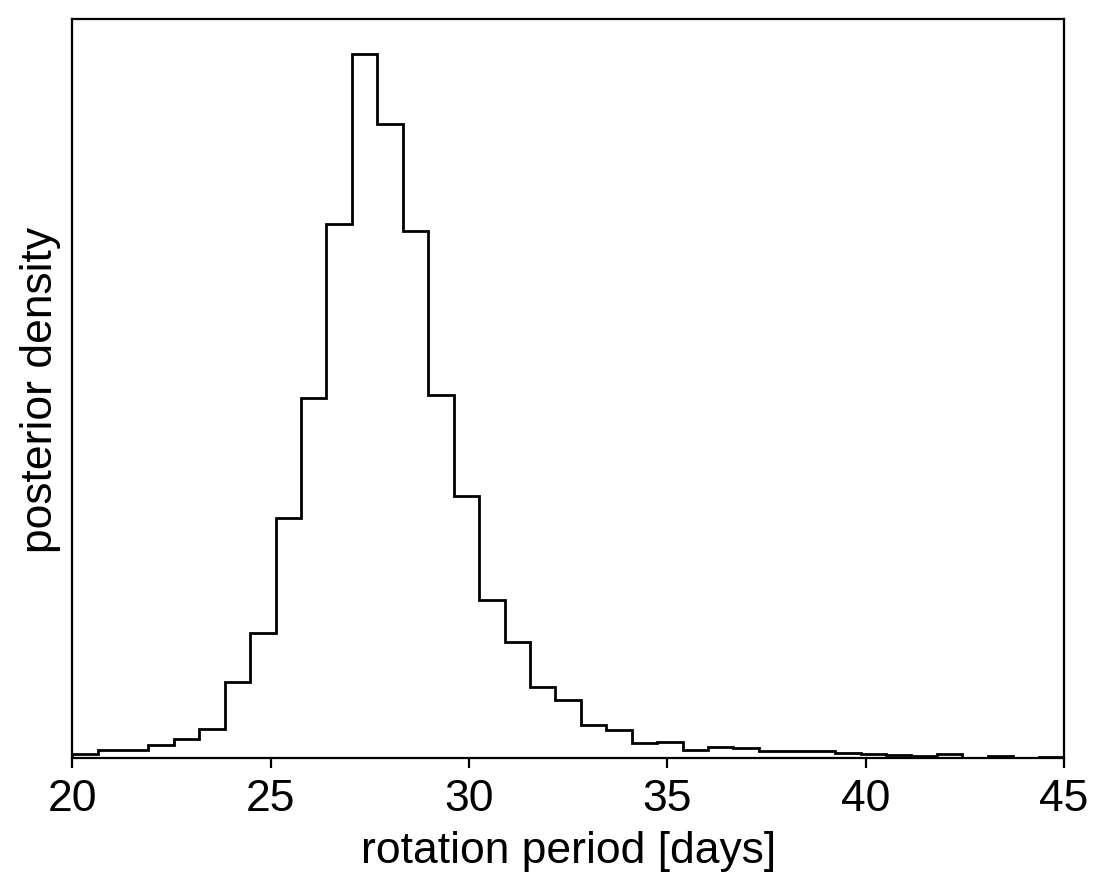

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
